In [2]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import isingmodellight
from isingmodellight import IsingModelLight
from scipy import stats
import time
import hcpdatautils as hcp
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [4]:
file_dir = 'E:\\Ising_model_results_daai'
other_file_dir = 'D:\\Ising_model_results_daai'

In [5]:
training_subject_start=0
training_subject_end = 670

In [6]:
plt.rcParams.update({'font.size': 20})

In [7]:
def depytorch(t:torch.Tensor):
    return t.detach().cpu().numpy()

In [8]:
def get_closest_match(values:torch.Tensor, target:float):
    return torch.argmin( torch.abs(values - target) )

In [9]:
num_beta = 101
min_beta = 1e-10
max_beta = 0.05
num_threshold = 31
min_threshold = 0.0
max_threshold = 3.0
threshold = torch.linspace(start=min_threshold, end=3, steps=num_threshold, dtype=float_type, device=device)
blue_thresh = get_closest_match(values=threshold, target=0.0)
green_thresh = get_closest_match(values=threshold, target=1.0)
red_thresh = get_closest_match(values=threshold, target=1.6)
data_string = f'thresholds_{num_threshold}_min_{min_threshold:.3g}_max_{max_threshold:.3g}'
param_string = f'light_group_{data_string}_betas_{num_beta}_min_{min_beta:.3g}_max_{max_beta}_steps_1200_lr_0.01_beta_updates_8_param_updates_40000'

In [14]:
def load_group_params():
    ising_model_file = os.path.join(file_dir, f'ising_model_{param_string}.pt')
    model = torch.load(ising_model_file, weights_only=False)
    print(f'loaded {ising_model_file}')
    print( 'h size', model.h.size() )
    print( 'J size', model.J.size() )
    triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=model.J.size(dim=-1), device=model.J.device )
    return model.h.mean(dim=0), model.J[:,:,triu_rows,triu_cols].mean(dim=0)
group_h, group_J = load_group_params()
print( 'h reduced to', group_h.size() )
print( 'J reduced to', group_J.size() )

loaded E:\Ising_model_results_daai\ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt
h size torch.Size([101, 31, 360])
J size torch.Size([101, 31, 360, 360])
h reduced to torch.Size([31, 360])
J reduced to torch.Size([31, 64620])


In [10]:
def make_scatter_plot_with_regression_line(ax, feature:torch.Tensor, param:torch.Tensor, feature_name:str, param_name:str):
    # We assume both Tensors are 1D and the same size.
    
    feature_std, feature_mean = torch.std_mean(feature)
    feature_z = (feature - feature_mean)/feature_std

    feature_z_and_1 = torch.stack(  ( feature_z, torch.ones_like(feature_z) ), dim=-1  )
    param_col = param.unsqueeze(dim=-1)
    lst_sq_result = torch.linalg.lstsq(feature_z_and_1, param_col)
    param_pred = torch.matmul(feature_z_and_1, lst_sq_result.solution).flatten()
    param_mean = torch.mean(param)
    r_squared = 1 - torch.sum( torch.square(param - param_pred) )/torch.sum( torch.square(param - param_mean) )
    
    slope = lst_sq_result.solution[0].item()
    intercept = lst_sq_result.solution[1].item()
    print(f'{param_name}={slope:.3g}z({feature_name})+{intercept:.3g}, R^2={r_squared:.3g}')
    
    feature_z_np = depytorch(feature_z)
    param_np = depytorch(param)
    param_pred_np = depytorch(param_pred)
    ax.scatter(feature_z_np, param_np, color='blue')
    ax.plot(feature_z_np, param_pred_np, color='orange', linewidth=3)
    # ax.text( x=0.0, y=param_mean.item(), s=f'R^2={r_squared:.3g}, corr.={corr:.3g}' )
    ax.set_xlabel(f'{feature_name} (z-score)')
    ax.set_ylabel(f'{param_name}')

In [11]:
def make_scatter_plot_with_regression_line_no_z(ax, feature:torch.Tensor, param:torch.Tensor, feature_name:str, param_name:str):
    # We assume both Tensors are 1D and the same size.

    feature_and_1 = torch.stack(  ( feature, torch.ones_like(feature) ), dim=-1  )
    param_col = param.unsqueeze(dim=-1)
    lst_sq_result = torch.linalg.lstsq(feature_and_1, param_col)
    param_pred = torch.matmul(feature_and_1, lst_sq_result.solution).flatten()
    param_mean = torch.mean(param)
    r_squared = 1 - torch.sum( torch.square(param - param_pred) )/torch.sum( torch.square(param - param_mean) )
    
    slope = lst_sq_result.solution[0].item()
    intercept = lst_sq_result.solution[1].item()
    print(f'{param_name}={slope:.3g}{feature_name}+{intercept:.3g}, R^2={r_squared:.3g}')
    
    feature_np = depytorch(feature)
    param_np = depytorch(param)
    param_pred_np = depytorch(param_pred)
    ax.scatter(feature_np, param_np, color='blue')
    ax.plot(feature_np, param_pred_np, color='orange', linewidth=3)
    # ax.text( x=0.0, y=param_mean.item(), s=f'R^2={r_squared:.3g}, corr.={corr:.3g}' )
    ax.set_xlabel(f'{feature_name}')
    ax.set_ylabel(f'{param_name}')

In [12]:
def get_correlation_and_p(feature:torch.Tensor, param:torch.Tensor, feature_name:str, param_name:str, num_perms:int=1000000):
    # We assume both Tensors are 1D and the same size.
    
    corr = isingmodellight.get_pairwise_correlation(mat1=param, mat2=feature, dim=0)
    
    num_greater = 0
    num_values = feature.numel()
    corr_abs = corr.abs()
    for _ in range(num_perms):
        perm = torch.randperm( n=num_values, dtype=int_type, device=feature.device )
        perm_corr_abs = isingmodellight.get_pairwise_correlation(mat1=param, mat2=feature[perm], dim=0).abs()
        num_greater += (perm_corr_abs >= corr_abs)
    p_value = num_greater/num_perms
    
    print(f'{param_name} v. {feature_name} corr.={corr:.3g}, p-value={p_value:.3g}')
    return corr, p_value

In [15]:
node_features = torch.load( os.path.join(other_file_dir, 'node_features_all_as_is.pt'), weights_only=False )[training_subject_start:training_subject_end,:,:4]
print( 'node features size', node_features.size() )
std_node_features, mean_node_features = torch.std_mean(node_features, dim=0)
print( 'mean node features size', mean_node_features.size() )
sc = torch.load( os.path.join(other_file_dir, 'edge_features_all_as_is.pt'), weights_only=False )[training_subject_start:training_subject_end,:,0]
print( 'SC size', sc.size() )
std_sc, mean_sc = torch.std_mean(sc, dim=0)
print( 'mean SC size', mean_sc.size() )

node features size torch.Size([670, 360, 4])
mean node features size torch.Size([360, 4])
SC size torch.Size([670, 64620])
mean SC size torch.Size([64620])


In [13]:
def write_node_file(file_name:str, coords:torch.Tensor, values_for_color:torch.Tensor=None, values_for_size:torch.Tensor=None, names:list=None):
    num_nodes = coords.size(dim=0)
    if type(values_for_color) == type(None):
        values_for_color = torch.zeros_like(coords[:,0])
    if type(values_for_size) == type(None):
        values_for_size = torch.ones_like(coords[:,0])
    if type(names) == type(None):
        names = ['-']*num_nodes
    node_lines = [ '\t'.join(['x', 'y', 'z', 'color', 'size', 'name'])+'\n' ] + [ '\t'.join([f'{x:.3g}', f'{y:.3g}', f'{z:.3g}', f'{c:.3g}', f'{s:.3g}', n])+'\n' for x, y, z, c, s, n in zip(coords[:,0], coords[:,1], coords[:,2], values_for_color, values_for_size, names) ]
    with open(file_name, 'w') as node_file:
        node_file.writelines(node_lines)

In [16]:
def get_group_fc():
    mean_state = torch.load( os.path.join(file_dir, f'mean_state_{data_string}.pt'), weights_only=False )
    print( 'mean state size', mean_state.size() )
    mean_state_product = torch.load( os.path.join(file_dir, f'mean_state_product_{data_string}.pt'), weights_only=False )
    print( 'mean state product size', mean_state_product.size() )
    group_fc = isingmodellight.get_fc(state_mean=mean_state, state_product_mean=mean_state_product, epsilon=0)
    triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=group_fc.size(dim=-1), device=group_fc.device )
    return group_fc[:,triu_rows,triu_cols]
group_fc = get_group_fc()
print( 'group FC size', group_fc.size() )

mean state size torch.Size([31, 360])
mean state product size torch.Size([31, 360, 360])
group FC size torch.Size([31, 64620])


In [17]:
num_thresholds, num_nodes = group_h.size()
adjusted_alpha = 0.05/(2 * num_thresholds)
print(f'group-level correlation adjusted alpha = {adjusted_alpha:.3g}')

group-level correlation adjusted alpha = 0.000806


In [18]:
h_node_corr_file = os.path.join(file_dir, f'h_node_corr_{param_string}.pt')
h_node_corr = torch.load(f=h_node_corr_file, weights_only=False)
print( f'loaded {h_node_corr_file}', h_node_corr.size() )

loaded E:\Ising_model_results_daai\h_node_corr_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt torch.Size([31, 4])


In [19]:
num_thresholds, num_features = h_node_corr.size()
adjusted_alpha = 0.05/(2 * num_thresholds)
print(f'group-level correlation adjusted alpha = {adjusted_alpha:.3g}')

group-level correlation adjusted alpha = 0.000806


In [20]:
h_node_corr_critical_file = os.path.join(file_dir, f'h_node_corr_critical_{param_string}_adj_alpha_{adjusted_alpha:.3g}.pt')
h_node_corr_critical = torch.load(f=h_node_corr_critical_file, weights_only=False)
print( f'loaded {h_node_corr_critical_file}', h_node_corr_critical.size() )

loaded E:\Ising_model_results_daai\h_node_corr_critical_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_adj_alpha_0.000806.pt torch.Size([31, 4])


In [21]:
J_sc_corr_file = os.path.join(file_dir, f'J_sc_corr_{param_string}.pt')
J_sc_corr = torch.load(f=J_sc_corr_file, weights_only=False)
print( f'loaded {J_sc_corr_file}', J_sc_corr.size() )

loaded E:\Ising_model_results_daai\J_sc_corr_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt torch.Size([31])


In [22]:
J_sc_corr_critical_file = os.path.join(file_dir, f'J_sc_corr_critical_{param_string}_adj_alpha_{adjusted_alpha:.3g}.pt')
J_sc_corr_critical = torch.load(f=J_sc_corr_critical_file, weights_only=False)
print( f'loaded {J_sc_corr_critical_file}', J_sc_corr_critical.size() )

loaded E:\Ising_model_results_daai\J_sc_corr_critical_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_adj_alpha_0.000806.pt torch.Size([31])


In [23]:
fc_sc_corr_file = os.path.join(file_dir, f'fc_sc_corr_{param_string}.pt')
fc_sc_corr = torch.load(f=fc_sc_corr_file, weights_only=False)
print( f'loaded {fc_sc_corr_file}', fc_sc_corr.size() )

loaded E:\Ising_model_results_daai\fc_sc_corr_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt torch.Size([31])


In [24]:
fc_sc_corr_critical_file = os.path.join(file_dir, f'fc_sc_corr_critical_{param_string}_adj_alpha_{adjusted_alpha:.3g}.pt')
fc_sc_corr_critical = torch.load(f=fc_sc_corr_critical_file, weights_only=False)
print( f'loaded {fc_sc_corr_critical_file}', fc_sc_corr_critical.size() )

loaded E:\Ising_model_results_daai\fc_sc_corr_critical_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_adj_alpha_0.000806.pt torch.Size([31])


In [25]:
brightness = 0.85
thickness_color = [brightness,0.0,0.0]
myelination_color = [0.0,brightness,0.0]
curvature_color = [0.0,0.0,brightness]
sulcus_depth_color = [brightness,0.0,brightness]
j_color = [brightness,brightness,0.0]
fc_color = [0.0,brightness,brightness]
crit_color = 'black'

In [26]:
h_node_corr_critical_min = h_node_corr_critical.min()
print( h_node_corr_critical_min )
h_node_corr_critical_max = h_node_corr_critical.max()
print( h_node_corr_critical_max )
J_sc_corr_critical_min = J_sc_corr_critical.min()
print( J_sc_corr_critical_min )
J_sc_corr_critical_max = J_sc_corr_critical.max()
print( J_sc_corr_critical_max )
fc_sc_corr_critical_min = fc_sc_corr_critical.min()
print( fc_sc_corr_critical_min )
fc_sc_corr_critical_max = fc_sc_corr_critical.max()
print( fc_sc_corr_critical_max )

tensor(0.1739, device='cuda:0')
tensor(0.1767, device='cuda:0')
tensor(0.0132, device='cuda:0')
tensor(0.0137, device='cuda:0')
tensor(0.0132, device='cuda:0')
tensor(0.0133, device='cuda:0')


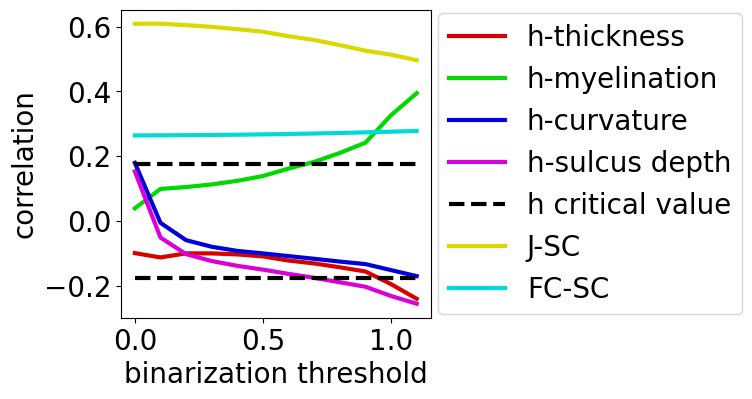

In [25]:
max_threshold = 1.1
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])
h_node_corr_np = depytorch(h_node_corr[:max_thresh_index,:])
J_sc_corr_np = depytorch(J_sc_corr[:max_thresh_index])
fc_sc_corr_np = depytorch(fc_sc_corr[:max_thresh_index])
horizontal_crit_np = depytorch( torch.full_like(input=threshold[:max_thresh_index], fill_value=h_node_corr_critical_max) )
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 4) )
line_width = 3
for feature_index, feature_name, feature_color in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],[thickness_color,myelination_color,curvature_color,sulcus_depth_color]):
    axs.plot(threshold_np, h_node_corr_np[:,feature_index], label=f'h-{feature_name}', color=feature_color, linewidth=line_width)
axs.plot(threshold_np, horizontal_crit_np, linestyle='--', label=f'h critical value', color=crit_color, linewidth=line_width)
axs.plot(threshold_np, -1*horizontal_crit_np, linestyle='--', color=crit_color, linewidth=line_width)
axs.plot(threshold_np, J_sc_corr_np, label='J-SC', color=j_color, linewidth=line_width)
axs.plot(threshold_np, fc_sc_corr_np, label='FC-SC', color=fc_color, linewidth=line_width)
# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
axs.legend( loc='center right', bbox_to_anchor=(2.05, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
plt.show()

In [27]:
num_thresholds, num_nodes = group_h.size()
num_features = mean_node_features.size(dim=-1)
mean_node_features_std, mean_node_features_mean = torch.std_mean(mean_node_features, dim=0, keepdim=True)
mean_node_features_z = (mean_node_features - mean_node_features_mean)/mean_node_features_std
ones_for_nodes = torch.ones( size=(num_nodes,1), dtype=mean_node_features_z.dtype, device=mean_node_features_z.device )
node_features_and_1 = torch.cat( (mean_node_features_z,ones_for_nodes), dim=-1 )
feature_coeffs = torch.zeros( size=(num_thresholds, num_features+1), dtype=mean_node_features_z.dtype, device=mean_node_features_z.device )
h_pred = torch.zeros_like(group_h)
for threshold_index in range(num_thresholds):
    h_for_threshold = group_h[threshold_index,:]
    regression = torch.linalg.lstsq( node_features_and_1, h_for_threshold.unsqueeze(dim=-1) )
    # print(f'threshold={threshold[threshold_index]:.3g}', regression)
    feature_coeffs[threshold_index,:] = regression.solution.flatten()
    h_pred[threshold_index,:] = torch.matmul(node_features_and_1, regression.solution).squeeze(dim=-1)
h_pred_corr = isingmodellight.get_pairwise_correlation( mat1=group_h, mat2=h_pred, epsilon=0, dim=-1 )
print('linear regression coefficients')
print( feature_coeffs.size() )
print('correlation between fitted and predicted h')
print( h_pred_corr.size() )

linear regression coefficients
torch.Size([31, 5])
correlation between fitted and predicted h
torch.Size([31])


In [28]:
def do_lstsq(h:torch.Tensor, features:torch.Tensor):
    coeffs = torch.linalg.lstsq(features, h).solution
    h_pred = torch.matmul(features, coeffs)
    corr = isingmodellight.get_pairwise_correlation( mat1=h, mat2=h_pred, epsilon=0, dim=1 )
    return coeffs, h_pred, corr

num_thresholds, num_nodes = group_h.size()
num_features = mean_node_features.size(dim=-1)
mean_node_features_for_lstsq = mean_node_features.unsqueeze(dim=0).repeat( (num_thresholds,1,1) )
print( 'mean_node_features_for_lstsq size', mean_node_features_for_lstsq.size() )
group_h_for_lstsq = group_h.unsqueeze(dim=-1)
print( 'group_h_for_lstsq size', group_h_for_lstsq.size() )
group_coeffs, group_h_pred, group_corr = do_lstsq(h=group_h_for_lstsq, features=mean_node_features_for_lstsq)
print('linear regression coefficients')
print( group_coeffs.size() )
print('correlation between fitted and predicted h')
print( group_corr.size() )
group_p_values = torch.zeros_like(group_corr)
num_perms = 1000000
start_time = time.time()
for _ in range(num_perms):
    perm = torch.randperm(n=num_nodes, dtype=int_type, device=device)
    _, _, group_corr_perm = do_lstsq(h=group_h_for_lstsq[:,perm,:], features=mean_node_features_for_lstsq)
    group_p_values += (group_corr_perm >= group_corr).float()
print( f'time {time.time()-start_time:.3f}' )
group_p_values /= num_perms
print( 'p-values size', group_p_values.size() )
group_corr = group_corr.squeeze(dim=-1)
group_p_values = group_p_values.squeeze(dim=-1)
print( f'min {group_p_values.min():.3g} mean {group_p_values.mean():.3g} max {group_p_values.max():.3g}' )

mean_node_features_for_lstsq size torch.Size([31, 360, 4])
group_h_for_lstsq size torch.Size([31, 360, 1])
linear regression coefficients
torch.Size([31, 4, 1])
correlation between fitted and predicted h
torch.Size([31, 1])
time 3014.553
p-values size torch.Size([31, 1])
min 0 mean 0.173 max 1


In [29]:
print( 'threshold', threshold.tolist() )
print( 'p-value', group_p_values.tolist() )

threshold [0.0, 0.10000000149011612, 0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929, 0.9000000357627869, 1.0, 1.100000023841858, 1.2000000476837158, 1.3000000715255737, 1.399999976158142, 1.5, 1.600000023841858, 1.6999999284744263, 1.7999999523162842, 1.899999976158142, 2.0, 2.0999999046325684, 2.200000047683716, 2.299999952316284, 2.4000000953674316, 2.5, 2.5999999046325684, 2.700000047683716, 2.799999952316284, 2.9000000953674316, 3.0]
p-value [0.0012550000101327896, 0.036038998514413834, 0.024397999048233032, 0.011296000331640244, 0.004792999941855669, 0.0015920000150799751, 0.00029799999902024865, 6.199999916134402e-05, 7.000000096013537e-06, 1.9999999949504854e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.022425999864935875, 0.0, 0.0, 0.0, 0.0023109999019652605, 0.5684400200843811, 0.0, 0.73614102602005, 0.9521520137786865, 0.0, 0.9886239767074585, 0.9998390078544617, 0.9996529817581177]


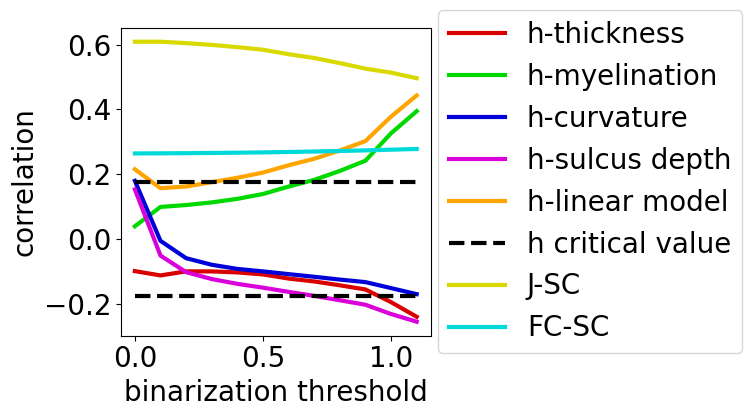

In [27]:
max_threshold = 1.1
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])
h_node_corr_np = depytorch(h_node_corr[:max_thresh_index,:])
h_pred_corr_np = depytorch(h_pred_corr[:max_thresh_index])
J_sc_corr_np = depytorch(J_sc_corr[:max_thresh_index])
fc_sc_corr_np = depytorch(fc_sc_corr[:max_thresh_index])
horizontal_crit_np = depytorch( torch.full_like(input=threshold[:max_thresh_index], fill_value=h_node_corr_critical_max) )
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 4) )
line_width = 3
for feature_index, feature_name, feature_color in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],[thickness_color,myelination_color,curvature_color,sulcus_depth_color]):
    axs.plot(threshold_np, h_node_corr_np[:,feature_index], label=f'h-{feature_name}', color=feature_color, linewidth=line_width)
axs.plot(threshold_np, h_pred_corr_np, label=f'h-linear model', color='orange', linewidth=line_width)
axs.plot(threshold_np, horizontal_crit_np, linestyle='--', label=f'h critical value', color=crit_color, linewidth=line_width)
axs.plot(threshold_np, -1*horizontal_crit_np, linestyle='--', color=crit_color, linewidth=line_width)
axs.plot(threshold_np, J_sc_corr_np, label='J-SC', color=j_color, linewidth=line_width)
axs.plot(threshold_np, fc_sc_corr_np, label='FC-SC', color=fc_color, linewidth=line_width)
# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
axs.legend( loc='center right', bbox_to_anchor=(2.05, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
plt.show()

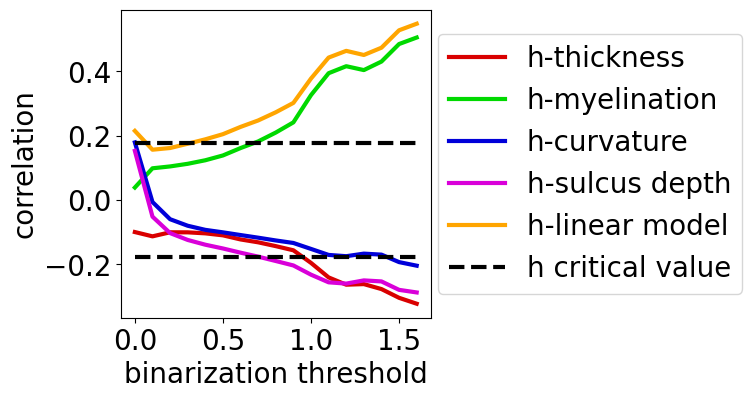

In [30]:
max_threshold = 1.6
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])
h_node_corr_np = depytorch(h_node_corr[:max_thresh_index,:])
h_pred_corr_np = depytorch(h_pred_corr[:max_thresh_index])
horizontal_crit_np = depytorch( torch.full_like(input=threshold[:max_thresh_index], fill_value=h_node_corr_critical_max) )
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 4) )
line_width = 3
for feature_index, feature_name, feature_color in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],[thickness_color,myelination_color,curvature_color,sulcus_depth_color]):
    axs.plot(threshold_np, h_node_corr_np[:,feature_index], label=f'h-{feature_name}', color=feature_color, linewidth=line_width)
axs.plot(threshold_np, h_pred_corr_np, label=f'h-linear model', color='orange', linewidth=line_width)
axs.plot(threshold_np, horizontal_crit_np, linestyle='--', label=f'h critical value', color=crit_color, linewidth=line_width)
axs.plot(threshold_np, -1*horizontal_crit_np, linestyle='--', color=crit_color, linewidth=line_width)
# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
axs.legend( loc='center right', bbox_to_anchor=(2.05, 0.5) )
axs.set_xticks( np.arange(0, max_threshold, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
plt.show()

feature order tensor([1, 2, 3, 0], device='cuda:0')


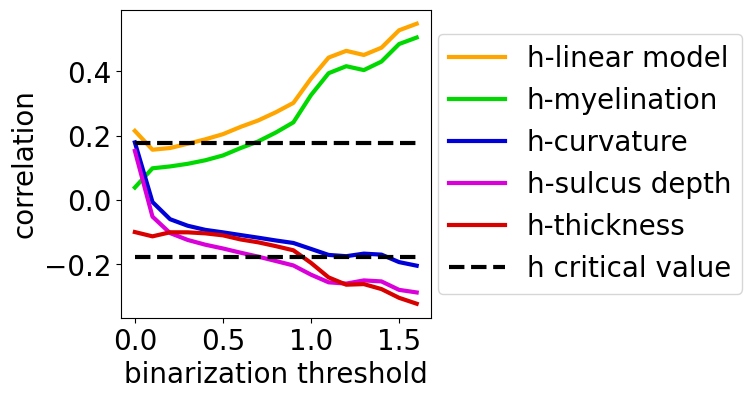

In [36]:
# Order the features in descending order of correlation at max threshold so that it will be easier to match the legend to the lines.
max_threshold = 1.6
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])
h_node_corr_np = depytorch(h_node_corr[:max_thresh_index,:])
h_pred_corr_np = depytorch(h_pred_corr[:max_thresh_index])
horizontal_crit_np = depytorch( torch.full_like(input=threshold[:max_thresh_index], fill_value=h_node_corr_critical_max) )
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 4) )
line_width = 3

axs.plot(threshold_np, h_pred_corr_np, label=f'h-linear model', color='orange', linewidth=line_width)

last_h_node_corr_sorted, feature_indices_sorted = torch.sort(h_node_corr[max_thresh_index-1,:], descending=True)
print('feature order', feature_indices_sorted)
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
feature_names_sorted = [feature_names[i] for i in feature_indices_sorted]
feature_colors = [thickness_color,myelination_color,curvature_color,sulcus_depth_color]
feature_colors_sorted = [feature_colors[i] for i in feature_indices_sorted]
for feature_index, feature_name, feature_color in zip(feature_indices_sorted,feature_names_sorted,feature_colors_sorted):
    axs.plot(threshold_np, h_node_corr_np[:,feature_index], label=f'h-{feature_name}', color=feature_color, linewidth=line_width)

axs.plot(threshold_np, horizontal_crit_np, linestyle='--', label=f'h critical value', color=crit_color, linewidth=line_width)
axs.plot(threshold_np, -1*horizontal_crit_np, linestyle='--', color=crit_color, linewidth=line_width)

# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
axs.legend( loc='center right', bbox_to_anchor=(2.05, 0.5) )
axs.set_xticks( np.arange(0, max_threshold, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
plt.show()

feature order tensor([1, 2, 3, 0], device='cuda:0')


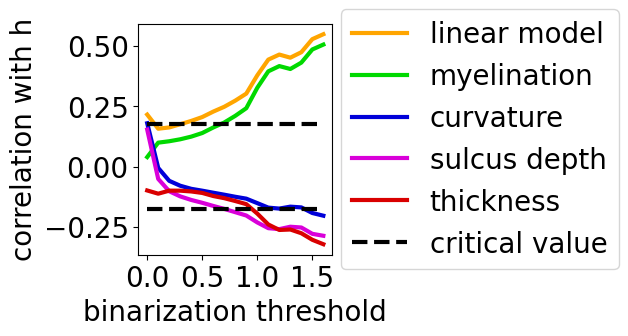

In [193]:
# Order the features in descending order of correlation at max threshold so that it will be easier to match the legend to the lines.
max_threshold = 1.6
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])
h_node_corr_np = depytorch(h_node_corr[:max_thresh_index,:])
h_pred_corr_np = depytorch(h_pred_corr[:max_thresh_index])
horizontal_crit_np = depytorch( torch.full_like(input=threshold[:max_thresh_index], fill_value=h_node_corr_critical_max) )
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(2.5, 3) )
line_width = 3

axs.plot(threshold_np, h_pred_corr_np, label=f'linear model', color='orange', linewidth=line_width)

last_h_node_corr_sorted, feature_indices_sorted = torch.sort(h_node_corr[max_thresh_index-1,:], descending=True)
print('feature order', feature_indices_sorted)
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
feature_names_sorted = [feature_names[i] for i in feature_indices_sorted]
feature_colors = [thickness_color,myelination_color,curvature_color,sulcus_depth_color]
feature_colors_sorted = [feature_colors[i] for i in feature_indices_sorted]
for feature_index, feature_name, feature_color in zip(feature_indices_sorted,feature_names_sorted,feature_colors_sorted):
    axs.plot(threshold_np, h_node_corr_np[:,feature_index], label=f'{feature_name}', color=feature_color, linewidth=line_width)

axs.plot(threshold_np, horizontal_crit_np, linestyle='--', label=f'critical value', color=crit_color, linewidth=line_width)
axs.plot(threshold_np, -1*horizontal_crit_np, linestyle='--', color=crit_color, linewidth=line_width)

# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
axs.legend( loc='center right', bbox_to_anchor=(2.55, 0.5) )
axs.set_xticks( np.arange(0, max_threshold, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation with h')
plt.show()

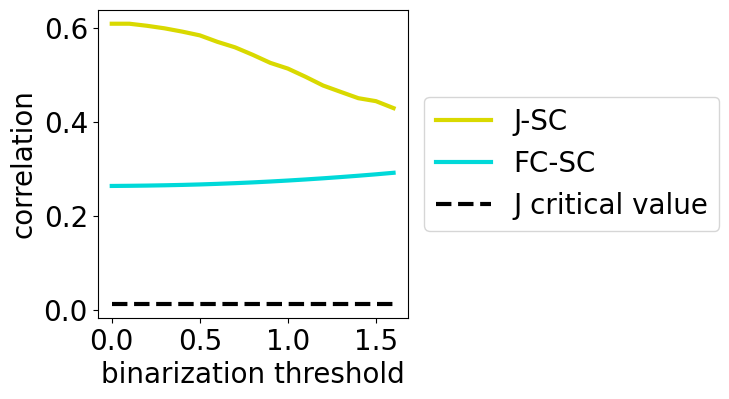

In [31]:
max_threshold = 1.6
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])
J_sc_corr_np = depytorch(J_sc_corr[:max_thresh_index])
fc_sc_corr_np = depytorch(fc_sc_corr[:max_thresh_index])
horizontal_crit_np = depytorch( torch.full_like(input=threshold[:max_thresh_index], fill_value=J_sc_corr_critical_max) )
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 4) )
line_width = 3
axs.plot(threshold_np, J_sc_corr_np, label='J-SC', color=j_color, linewidth=line_width)
axs.plot(threshold_np, fc_sc_corr_np, label='FC-SC', color=fc_color, linewidth=line_width)
axs.plot(threshold_np, horizontal_crit_np, linestyle='--', label=f'J critical value', color=crit_color, linewidth=line_width)
# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
axs.legend( loc='center right', bbox_to_anchor=(2.05, 0.5) )
axs.set_xticks( np.arange(0, max_threshold, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
plt.show()

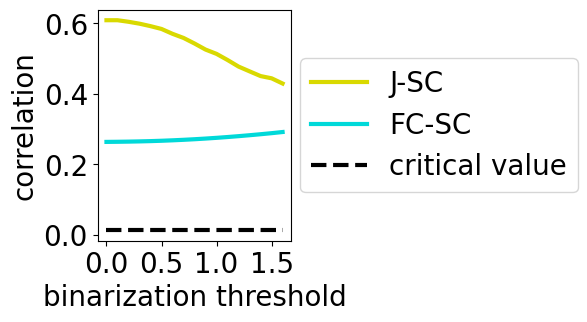

In [191]:
max_threshold = 1.6
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])
J_sc_corr_np = depytorch(J_sc_corr[:max_thresh_index])
fc_sc_corr_np = depytorch(fc_sc_corr[:max_thresh_index])
horizontal_crit_np = depytorch( torch.full_like(input=threshold[:max_thresh_index], fill_value=J_sc_corr_critical_max) )
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(2.5, 3) )
line_width = 3
axs.plot(threshold_np, J_sc_corr_np, label='J-SC', color=j_color, linewidth=line_width)
axs.plot(threshold_np, fc_sc_corr_np, label='FC-SC', color=fc_color, linewidth=line_width)
axs.plot(threshold_np, horizontal_crit_np, linestyle='--', label=f'critical value', color=crit_color, linewidth=line_width)
# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
axs.legend( loc='center right', bbox_to_anchor=(2.55, 0.5) )
axs.set_xticks( np.arange(0, max_threshold, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
plt.show()

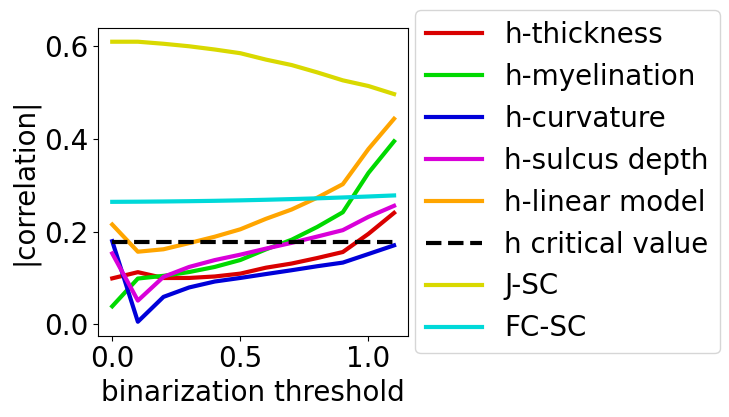

In [30]:
max_threshold = 1.1
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])
h_node_corr_np = depytorch(h_node_corr[:max_thresh_index,:])
h_pred_corr_np = depytorch(h_pred_corr[:max_thresh_index])
J_sc_corr_np = depytorch(J_sc_corr[:max_thresh_index])
fc_sc_corr_np = depytorch(fc_sc_corr[:max_thresh_index])
horizontal_crit_np = depytorch( torch.full_like(input=threshold[:max_thresh_index], fill_value=h_node_corr_critical_max) )
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 4) )
line_width = 3
for feature_index, feature_name, feature_color in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],[thickness_color,myelination_color,curvature_color,sulcus_depth_color]):
    axs.plot( threshold_np, np.abs(h_node_corr_np[:,feature_index]), label=f'h-{feature_name}', color=feature_color, linewidth=line_width )
axs.plot( threshold_np, np.abs(h_pred_corr_np), label=f'h-linear model', color='orange', linewidth=line_width )
axs.plot(threshold_np, horizontal_crit_np, linestyle='--', label=f'h critical value', color=crit_color, linewidth=line_width)
# axs.plot(threshold_np, -1*horizontal_crit_np, linestyle='--', color=crit_color, linewidth=line_width)
axs.plot( threshold_np, np.abs(J_sc_corr_np), label='J-SC', color=j_color, linewidth=line_width )
axs.plot( threshold_np, np.abs(fc_sc_corr_np), label='FC-SC', color=fc_color, linewidth=line_width )
# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
axs.legend( loc='center right', bbox_to_anchor=(2.05, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('|correlation|')
plt.show()

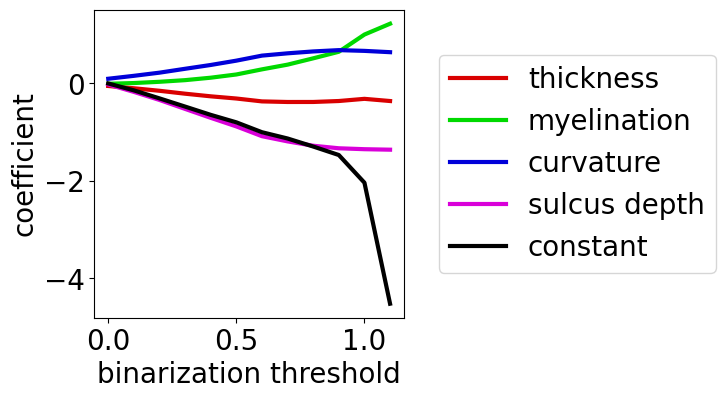

In [31]:
max_threshold = 1.1
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])
feature_coeffs_np = depytorch(feature_coeffs[:max_thresh_index,:])
horizontal_crit_np = depytorch( torch.full_like(input=threshold[:max_thresh_index], fill_value=h_node_corr_critical_max) )
constant_color = 'black'
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 4) )
line_width = 3
for feature_index, feature_name, feature_color in zip([0,1,2,3,4],['thickness', 'myelination', 'curvature', 'sulcus depth', 'constant'],[thickness_color,myelination_color,curvature_color,sulcus_depth_color,constant_color]):
    axs.plot(threshold_np, feature_coeffs_np[:,feature_index], label=f'{feature_name}', color=feature_color, linewidth=line_width)
# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
axs.legend( loc='center right', bbox_to_anchor=(2.05, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('coefficient')
plt.show()

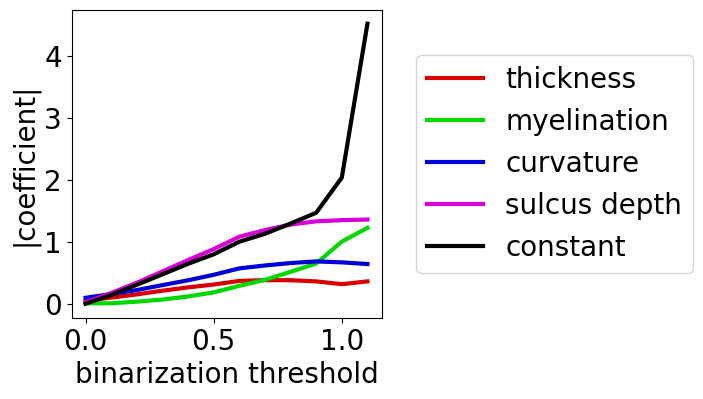

In [32]:
max_threshold = 1.1
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])
feature_coeffs_np = depytorch(feature_coeffs[:max_thresh_index,:])
horizontal_crit_np = depytorch( torch.full_like(input=threshold[:max_thresh_index], fill_value=h_node_corr_critical_max) )
constant_color = 'black'
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 4) )
line_width = 3
for feature_index, feature_name, feature_color in zip([0,1,2,3,4],['thickness', 'myelination', 'curvature', 'sulcus depth', 'constant'],[thickness_color,myelination_color,curvature_color,sulcus_depth_color,constant_color]):
    axs.plot( threshold_np, np.abs(feature_coeffs_np[:,feature_index]), label=f'{feature_name}', color=feature_color, linewidth=line_width )
# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
axs.legend( loc='center right', bbox_to_anchor=(2.05, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('|coefficient|')
plt.show()

z(h (threshold=1))=-0.824thickness+-2.04, R^2=0.0385
z(h (threshold=1))=1.37myelination+-2.04, R^2=0.107
z(h (threshold=1))=-0.639curvature+-2.04, R^2=0.0232
z(h (threshold=1))=-0.975sulcus depth+-2.04, R^2=0.054
z(J (threshold=1))=2.02SC+0.835, R^2=0.264
z(FC (threshold=1))=0.0254SC+0.223, R^2=0.0759


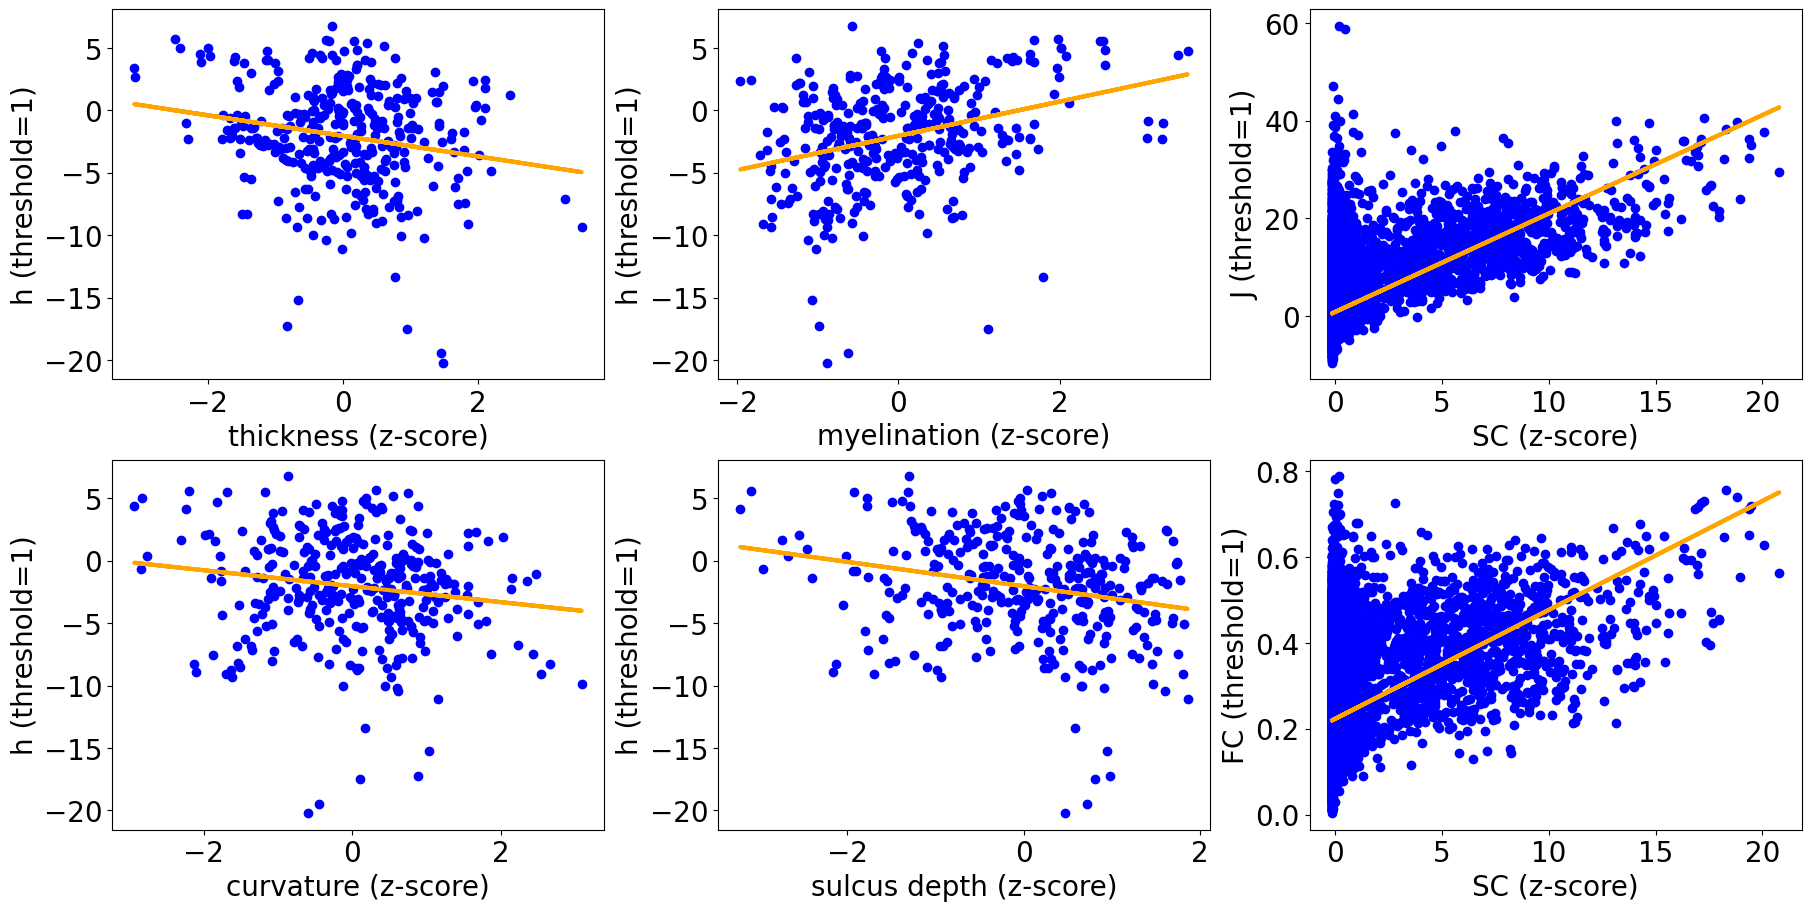

In [33]:
fig, axs = plt.subplots( nrows=2, ncols=3, figsize=(18, 9), layout='constrained' )
selected_threshold_index = get_closest_match(values=threshold, target=1.0)
selected_threshold = threshold[selected_threshold_index]

for feature_index, feature_name, feature_row, feature_col in zip([0,1,2,3],['thickness', 'myelination', 'curvature', 'sulcus depth'],[0,0,1,1],[0,1,0,1]):
    selected_h = group_h[selected_threshold_index,:]
    make_scatter_plot_with_regression_line(ax=axs[feature_row,feature_col], feature=mean_node_features[:,feature_index], param=selected_h, feature_name=feature_name, param_name=f'h (threshold={selected_threshold:.3g})')

# selected_threshold_index = torch.argmax( J_sc_corr.abs() )
selected_J = group_J[selected_threshold_index,:]
make_scatter_plot_with_regression_line(ax=axs[0,2], feature=mean_sc, param=selected_J, feature_name='SC', param_name=f'J (threshold={selected_threshold:.3g})')

# selected_threshold_index = torch.argmax( fc_sc_corr.abs() )
selected_fc = group_fc[selected_threshold_index,:]
make_scatter_plot_with_regression_line(ax=axs[1,2], feature=mean_sc, param=selected_fc, feature_name='SC', param_name=f'FC (threshold={selected_threshold:.3g})')

# log_sc = torch.log(mean_sc)
# make_scatter_plot_with_regression_line(ax=axs[2,0], feature=log_sc, param=selected_J, feature_name='log(SC)', param_name='J')
# make_scatter_plot_with_regression_line(ax=axs[2,1], feature=log_sc, param=selected_fc, feature_name='log(SC)', param_name='FC')

# plt.tight_layout()
plt.show()

z(group J (threshold=1))=2.02SC+0.835, R^2=0.264


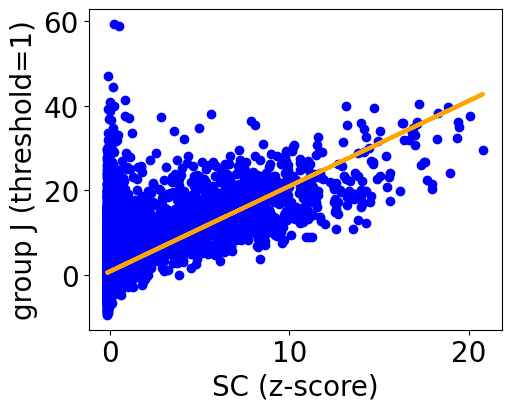

In [34]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )
selected_threshold_index = get_closest_match(values=threshold, target=1.0)
selected_threshold = threshold[selected_threshold_index]

# selected_threshold_index = torch.argmax( J_sc_corr.abs() )
selected_J = group_J[selected_threshold_index,:]
make_scatter_plot_with_regression_line(ax=axs, feature=mean_sc, param=selected_J, feature_name='SC', param_name=f'group J (threshold={selected_threshold:.3g})')

plt.show()

h (threshold=1)=1linear model h prediction+-4.91e-07, R^2=0.143


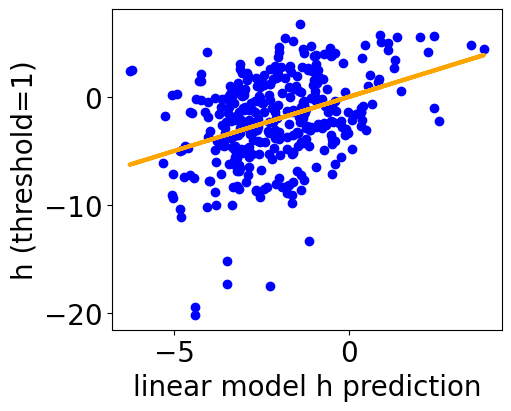

In [35]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )
selected_threshold_index = get_closest_match(values=threshold, target=1.0)
selected_threshold = threshold[selected_threshold_index]
selected_h = group_h[selected_threshold_index,:]
selected_h_pred = h_pred[selected_threshold_index,:]
make_scatter_plot_with_regression_line_no_z(ax=axs, feature=selected_h_pred, param=selected_h, feature_name='linear model h prediction', param_name=f'h (threshold={selected_threshold:.3g})')

# plt.tight_layout()
plt.show()

In [36]:
get_correlation_and_p(feature=selected_h_pred, param=selected_h, feature_name='linear model h prediction', param_name=f'h (threshold={selected_threshold:.3g})', num_perms=1000)

h (threshold=1) v. linear model h prediction corr.=0.378, p-value=0


(tensor(0.3777, device='cuda:0'), tensor(0., device='cuda:0'))

In [57]:
saved_h_node_group_corrs = torch.load( os.path.join(file_dir, 'h_node_corr_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt'), weights_only=False )
print( saved_h_node_group_corrs.size() )

torch.Size([31, 4])


In [71]:
selected_threshold_index = get_closest_match(values=threshold, target=1.0)
selected_threshold = threshold[selected_threshold_index]
print(saved_h_node_group_corrs[selected_threshold_index])

tensor([-0.1951,  0.3263, -0.1517, -0.2317], device='cuda:0')


In [72]:
print(h_node_corr_critical[selected_threshold_index])

tensor([0.1753, 0.1753, 0.1750, 0.1749], device='cuda:0')


In [73]:
for feature_index in range(num_features):
    print( feature_names[feature_index], threshold[ h_node_corr[:,feature_index].abs() > h_node_corr_critical[:,feature_index] ] )

thickness tensor([1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000, 1.8000,
        1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000, 2.7000,
        2.8000, 2.9000, 3.0000], device='cuda:0')
myelination tensor([0.7000, 0.8000, 0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000,
        1.6000, 1.7000, 1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000,
        2.5000, 2.6000, 2.7000, 2.8000, 2.9000, 3.0000], device='cuda:0')
curvature tensor([0.0000, 1.5000, 1.6000, 1.7000, 1.8000, 1.9000, 2.0000, 2.1000, 2.2000,
        2.3000, 2.4000, 2.5000, 2.6000, 2.7000, 2.8000, 2.9000, 3.0000],
       device='cuda:0')
sulcus depth tensor([0.7000, 0.8000, 0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000,
        1.6000, 1.7000, 1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000,
        2.5000, 2.6000, 2.7000, 2.8000, 2.9000, 3.0000], device='cuda:0')


In [74]:
print( h_node_corr_critical.min().item(), h_node_corr_critical.max().item() )

0.17389321327209473 0.17669451236724854


z(group h (threshold=1))=1.37myelination+-2.04, R^2=0.107


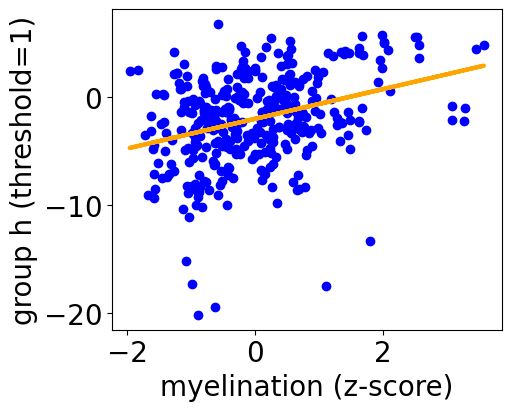

In [37]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )
selected_threshold_index = get_closest_match(values=threshold, target=1.0)
selected_threshold = threshold[selected_threshold_index]

feature_index = 1
feature_name = 'myelination'
selected_h = group_h[selected_threshold_index,:]
make_scatter_plot_with_regression_line(ax=axs, feature=mean_node_features[:,feature_index], param=selected_h, feature_name=feature_name, param_name=f'group h (threshold={selected_threshold:.3g})')

# plt.tight_layout()
plt.show()

In [37]:
data_string = 'all_mean_std_1'
param_string = f'{data_string}_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000'

In [93]:
def load_mean_params(param_string:str):
    model_file = os.path.join( other_file_dir, f'ising_model_light_{param_string}.pt' )
    model = torch.load(model_file, weights_only=False)
    num_nodes = model.J.size(dim=-1)
    triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=num_nodes, device=model.J.device )
    return model.h[:,training_subject_start:training_subject_end,:].mean(dim=0), model.J[:,training_subject_start:training_subject_end,triu_rows,triu_cols].mean(dim=0)
h, J = load_mean_params(param_string=param_string)
print( 'h size', h.size() )
print( 'J size', J.size() )

h size torch.Size([670, 360])
J size torch.Size([670, 64620])


In [94]:
def get_data_fc_triu(data_string:str):
    mean_state = torch.load( os.path.join(other_file_dir, f'mean_state_{data_string}.pt'), weights_only=False )[:,training_subject_start:training_subject_end,:].mean(dim=0)
    print( 'mean state size', mean_state.size() )
    mean_state_product = torch.load( os.path.join(other_file_dir, f'mean_state_product_{data_string}.pt'), weights_only=False )[:,training_subject_start:training_subject_end,:,:].mean(dim=0)
    print( 'mean state product size', mean_state_product.size() )
    fc = isingmodellight.get_fc(state_mean=mean_state, state_product_mean=mean_state_product, epsilon=0)
    print( 'fc size', fc.size() )
    triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=mean_state.size(dim=-1), device=mean_state.device )
    return fc[:,triu_rows,triu_cols]
fc = get_data_fc_triu(data_string=data_string)
print( 'triu fc size', fc.size() )

mean state size torch.Size([670, 360])
mean state product size torch.Size([670, 360, 360])
fc size torch.Size([670, 360, 360])
triu fc size torch.Size([670, 64620])


In [95]:
h_std, h_mean = torch.std_mean(h, dim=0)
J_std, J_mean = torch.std_mean(J, dim=0)

SD of h (threshold=1)=-3.17mean myelination+9.3, R^2=0.199


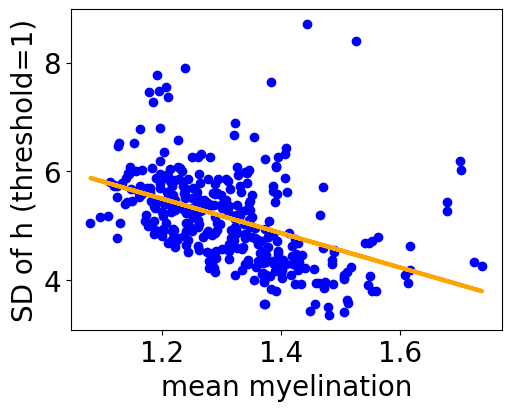

In [125]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )
selected_threshold_index = get_closest_match(values=threshold, target=1.0)
selected_threshold = threshold[selected_threshold_index]

feature_index = 1
feature_name = 'myelination'
selected_h = group_h[selected_threshold_index,:]
make_scatter_plot_with_regression_line_no_z(ax=axs, feature=mean_node_features[:,feature_index], param=h_std, feature_name=f'mean {feature_name}', param_name=f'SD of h (threshold={selected_threshold:.3g})')

# plt.tight_layout()
plt.show()

In [43]:
get_correlation_and_p(feature=mean_node_features[:,feature_index], param=h_std, feature_name=feature_name, param_name=f'SD of h (threshold={selected_threshold:.3g})', num_perms=1000)

SD of h (threshold=1) v. myelination corr.=-0.445, p-value=0


(tensor(-0.4453, device='cuda:0'), tensor(0., device='cuda:0'))

z(SD of J (threshold=1))=0.327SC+4.27, R^2=0.123


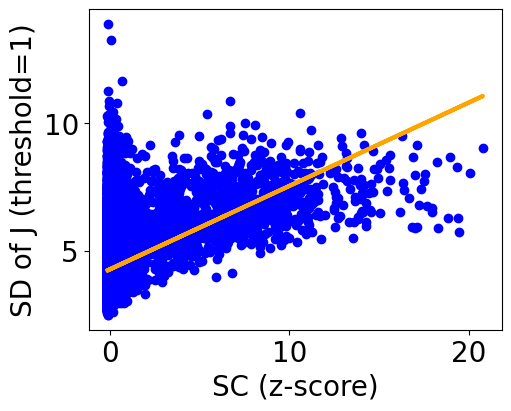

In [44]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )
selected_threshold_index = get_closest_match(values=threshold, target=1.0)
selected_threshold = threshold[selected_threshold_index]

# selected_threshold_index = torch.argmax( J_sc_corr.abs() )
make_scatter_plot_with_regression_line(ax=axs, feature=mean_sc, param=J_std, feature_name='SC', param_name=f'SD of J (threshold={selected_threshold:.3g})')

plt.show()

In [45]:
get_correlation_and_p(feature=mean_sc, param=J_std, feature_name='SC', param_name=f'SD of J (threshold={selected_threshold:.3g})', num_perms=1000)

SD of J (threshold=1) v. SC corr.=0.35, p-value=0


(tensor(0.3503, device='cuda:0'), tensor(0., device='cuda:0'))

In [47]:
print( node_features.size(), h.size() )
# feature_names_file = ['thickness', 'myelination', 'curvature', 'sulcus_depth']
# h_node_feature_corr_tensor = torch.stack( [ torch.load( os.path.join(file_dir, f'h_{feature_name}_corr_{param_string}.pt'), weights_only=False ) for feature_name in feature_names_file ], dim=-1 )
h_node_feature_corr_tensor = isingmodellight.get_pairwise_correlation( mat1=node_features, mat2=h.unsqueeze(dim=-1), epsilon=0.0, dim=0 )
print( h_node_feature_corr_tensor.size() )
print( h_node_feature_corr_tensor.min(dim=0).values.tolist() )
print( h_node_feature_corr_tensor.max(dim=0).values.tolist() )

torch.Size([670, 360, 4]) torch.Size([670, 360])
torch.Size([360, 4])
[-0.11804887652397156, -0.26351335644721985, -0.2219689041376114, -0.18898098170757294]
[0.16923202574253082, 0.43872854113578796, 0.39650464057922363, 0.37393948435783386]


z(h-myelination corr.)=-0.00669myelination+0.0128, R^2=0.0065


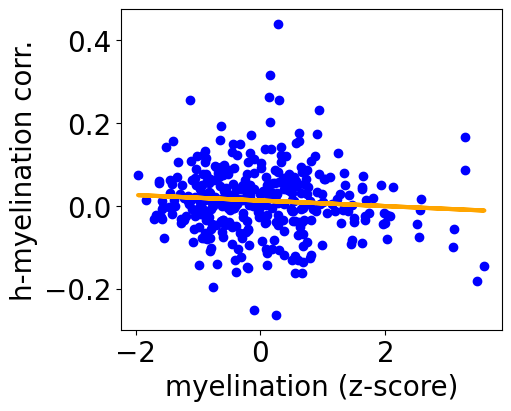

In [48]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )

feature_index = 1
feature_name = 'myelination'
make_scatter_plot_with_regression_line(ax=axs, feature=mean_node_features[:,feature_index], param=h_node_feature_corr_tensor[:,feature_index], feature_name=feature_name, param_name=f'h-{feature_name} corr.')

# plt.tight_layout()
plt.show()

z(h-sulcus depth corr.)=0.0229myelination+0.0277, R^2=0.0642
h-sulcus depth corr. v. myelination corr.=0.253, p-value=0


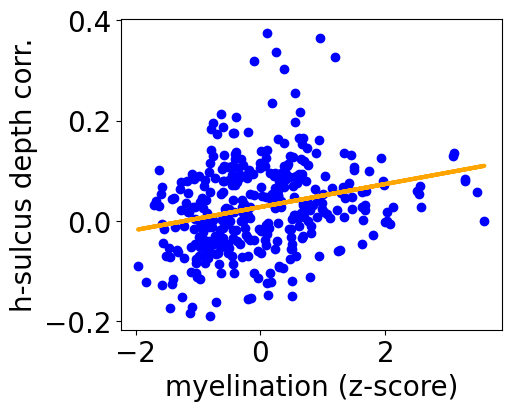

In [49]:
feature_names_file = ['thickness', 'myelination', 'curvature', 'sulcus depth']
num_features = len(feature_names_file)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )
feature_index = 1
corr_feature_index = 3
selected_features = mean_node_features[:,feature_index]
selected_feature_name = feature_names_file[feature_index]
selected_corrs = h_node_feature_corr_tensor[:,corr_feature_index]
selected_corr_name = f'h-{feature_names_file[corr_feature_index]} corr.'
make_scatter_plot_with_regression_line(ax=axs, feature=selected_features, param=selected_corrs, feature_name=selected_feature_name, param_name=selected_corr_name)
get_correlation_and_p(feature=selected_features, param=selected_corrs, feature_name=selected_feature_name, param_name=selected_corr_name, num_perms=1000)
# plt.tight_layout()
plt.show()

z(h-thickness corr.)=-0.00911myelination+0.0329, R^2=0.0285
h-thickness corr. v. myelination corr.=-0.168, p-value=0.002
z(h-myelination corr.)=-0.00669myelination+0.0128, R^2=0.0065
h-myelination corr. v. myelination corr.=-0.0804, p-value=0.122
z(h-curvature corr.)=0.0149myelination+0.05, R^2=0.0309
h-curvature corr. v. myelination corr.=0.175, p-value=0.002
z(h-sulcus depth corr.)=0.0229myelination+0.0277, R^2=0.0642
h-sulcus depth corr. v. myelination corr.=0.253, p-value=0


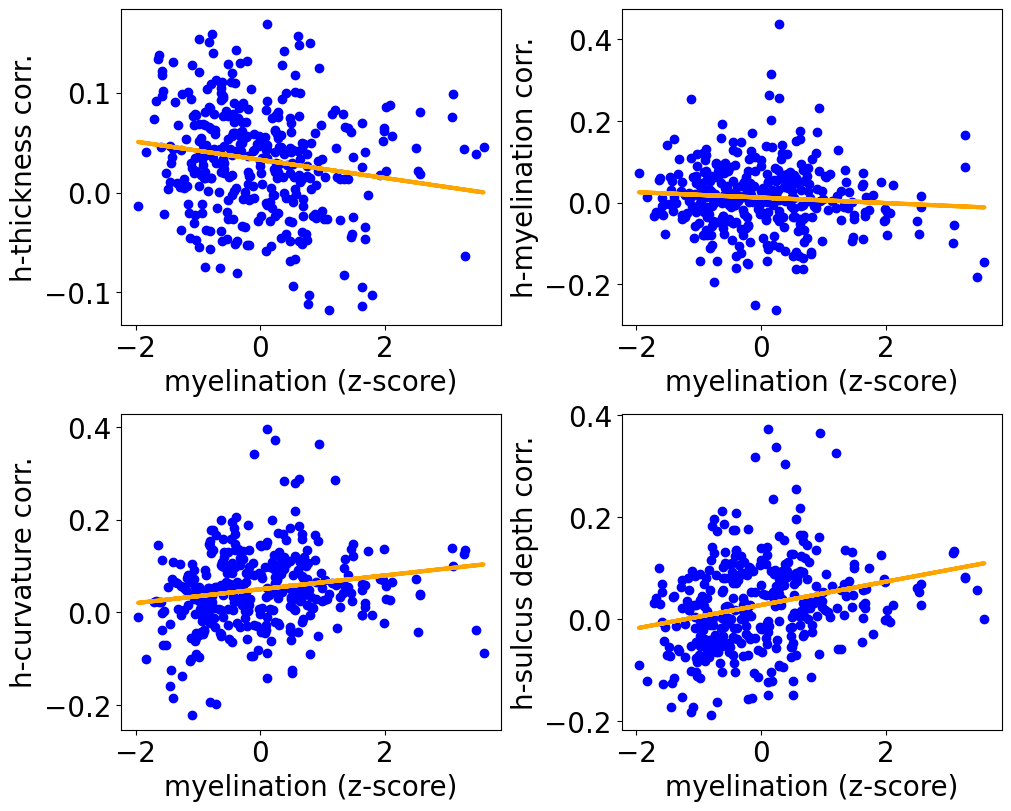

In [50]:
feature_names_file = ['thickness', 'myelination', 'curvature', 'sulcus depth']
num_features = len(feature_names_file)
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(10, 8), layout='constrained' )
row_indices = [0, 0, 1, 1]
col_indices = [0, 1, 0, 1]
feature_index = 1
for corr_feature_index in range(num_features):
    ax = axs[ row_indices[corr_feature_index], col_indices[corr_feature_index] ]
    selected_features = mean_node_features[:,feature_index]
    selected_feature_name = feature_names_file[feature_index]
    selected_corrs = h_node_feature_corr_tensor[:,corr_feature_index]
    selected_corr_name = f'h-{feature_names_file[corr_feature_index]} corr.'
    make_scatter_plot_with_regression_line(ax=ax, feature=selected_features, param=selected_corrs, feature_name=selected_feature_name, param_name=selected_corr_name)
    get_correlation_and_p(feature=selected_features, param=selected_corrs, feature_name=selected_feature_name, param_name=selected_corr_name, num_perms=1000)
# plt.tight_layout()
plt.show()

z(h-thickness corr.)=0.00477thickness+0.0329, R^2=0.00779
h-thickness corr. v. thickness corr.=0.088, p-value=0.086
z(h-myelination corr.)=-0.00778thickness+0.0128, R^2=0.0088
h-myelination corr. v. thickness corr.=-0.0935, p-value=0.084
z(h-curvature corr.)=-0.00741thickness+0.05, R^2=0.00759
h-curvature corr. v. thickness corr.=-0.0869, p-value=0.089
z(h-sulcus depth corr.)=-0.0114thickness+0.0277, R^2=0.0159
h-sulcus depth corr. v. thickness corr.=-0.126, p-value=0.016
z(h-thickness corr.)=-0.00911myelination+0.0329, R^2=0.0285
h-thickness corr. v. myelination corr.=-0.168, p-value=0.001
z(h-myelination corr.)=-0.00669myelination+0.0128, R^2=0.0065
h-myelination corr. v. myelination corr.=-0.0804, p-value=0.126
z(h-curvature corr.)=0.0149myelination+0.05, R^2=0.0309
h-curvature corr. v. myelination corr.=0.175, p-value=0.001
z(h-sulcus depth corr.)=0.0229myelination+0.0277, R^2=0.0642
h-sulcus depth corr. v. myelination corr.=0.253, p-value=0
z(h-thickness corr.)=0.000304curvature+0

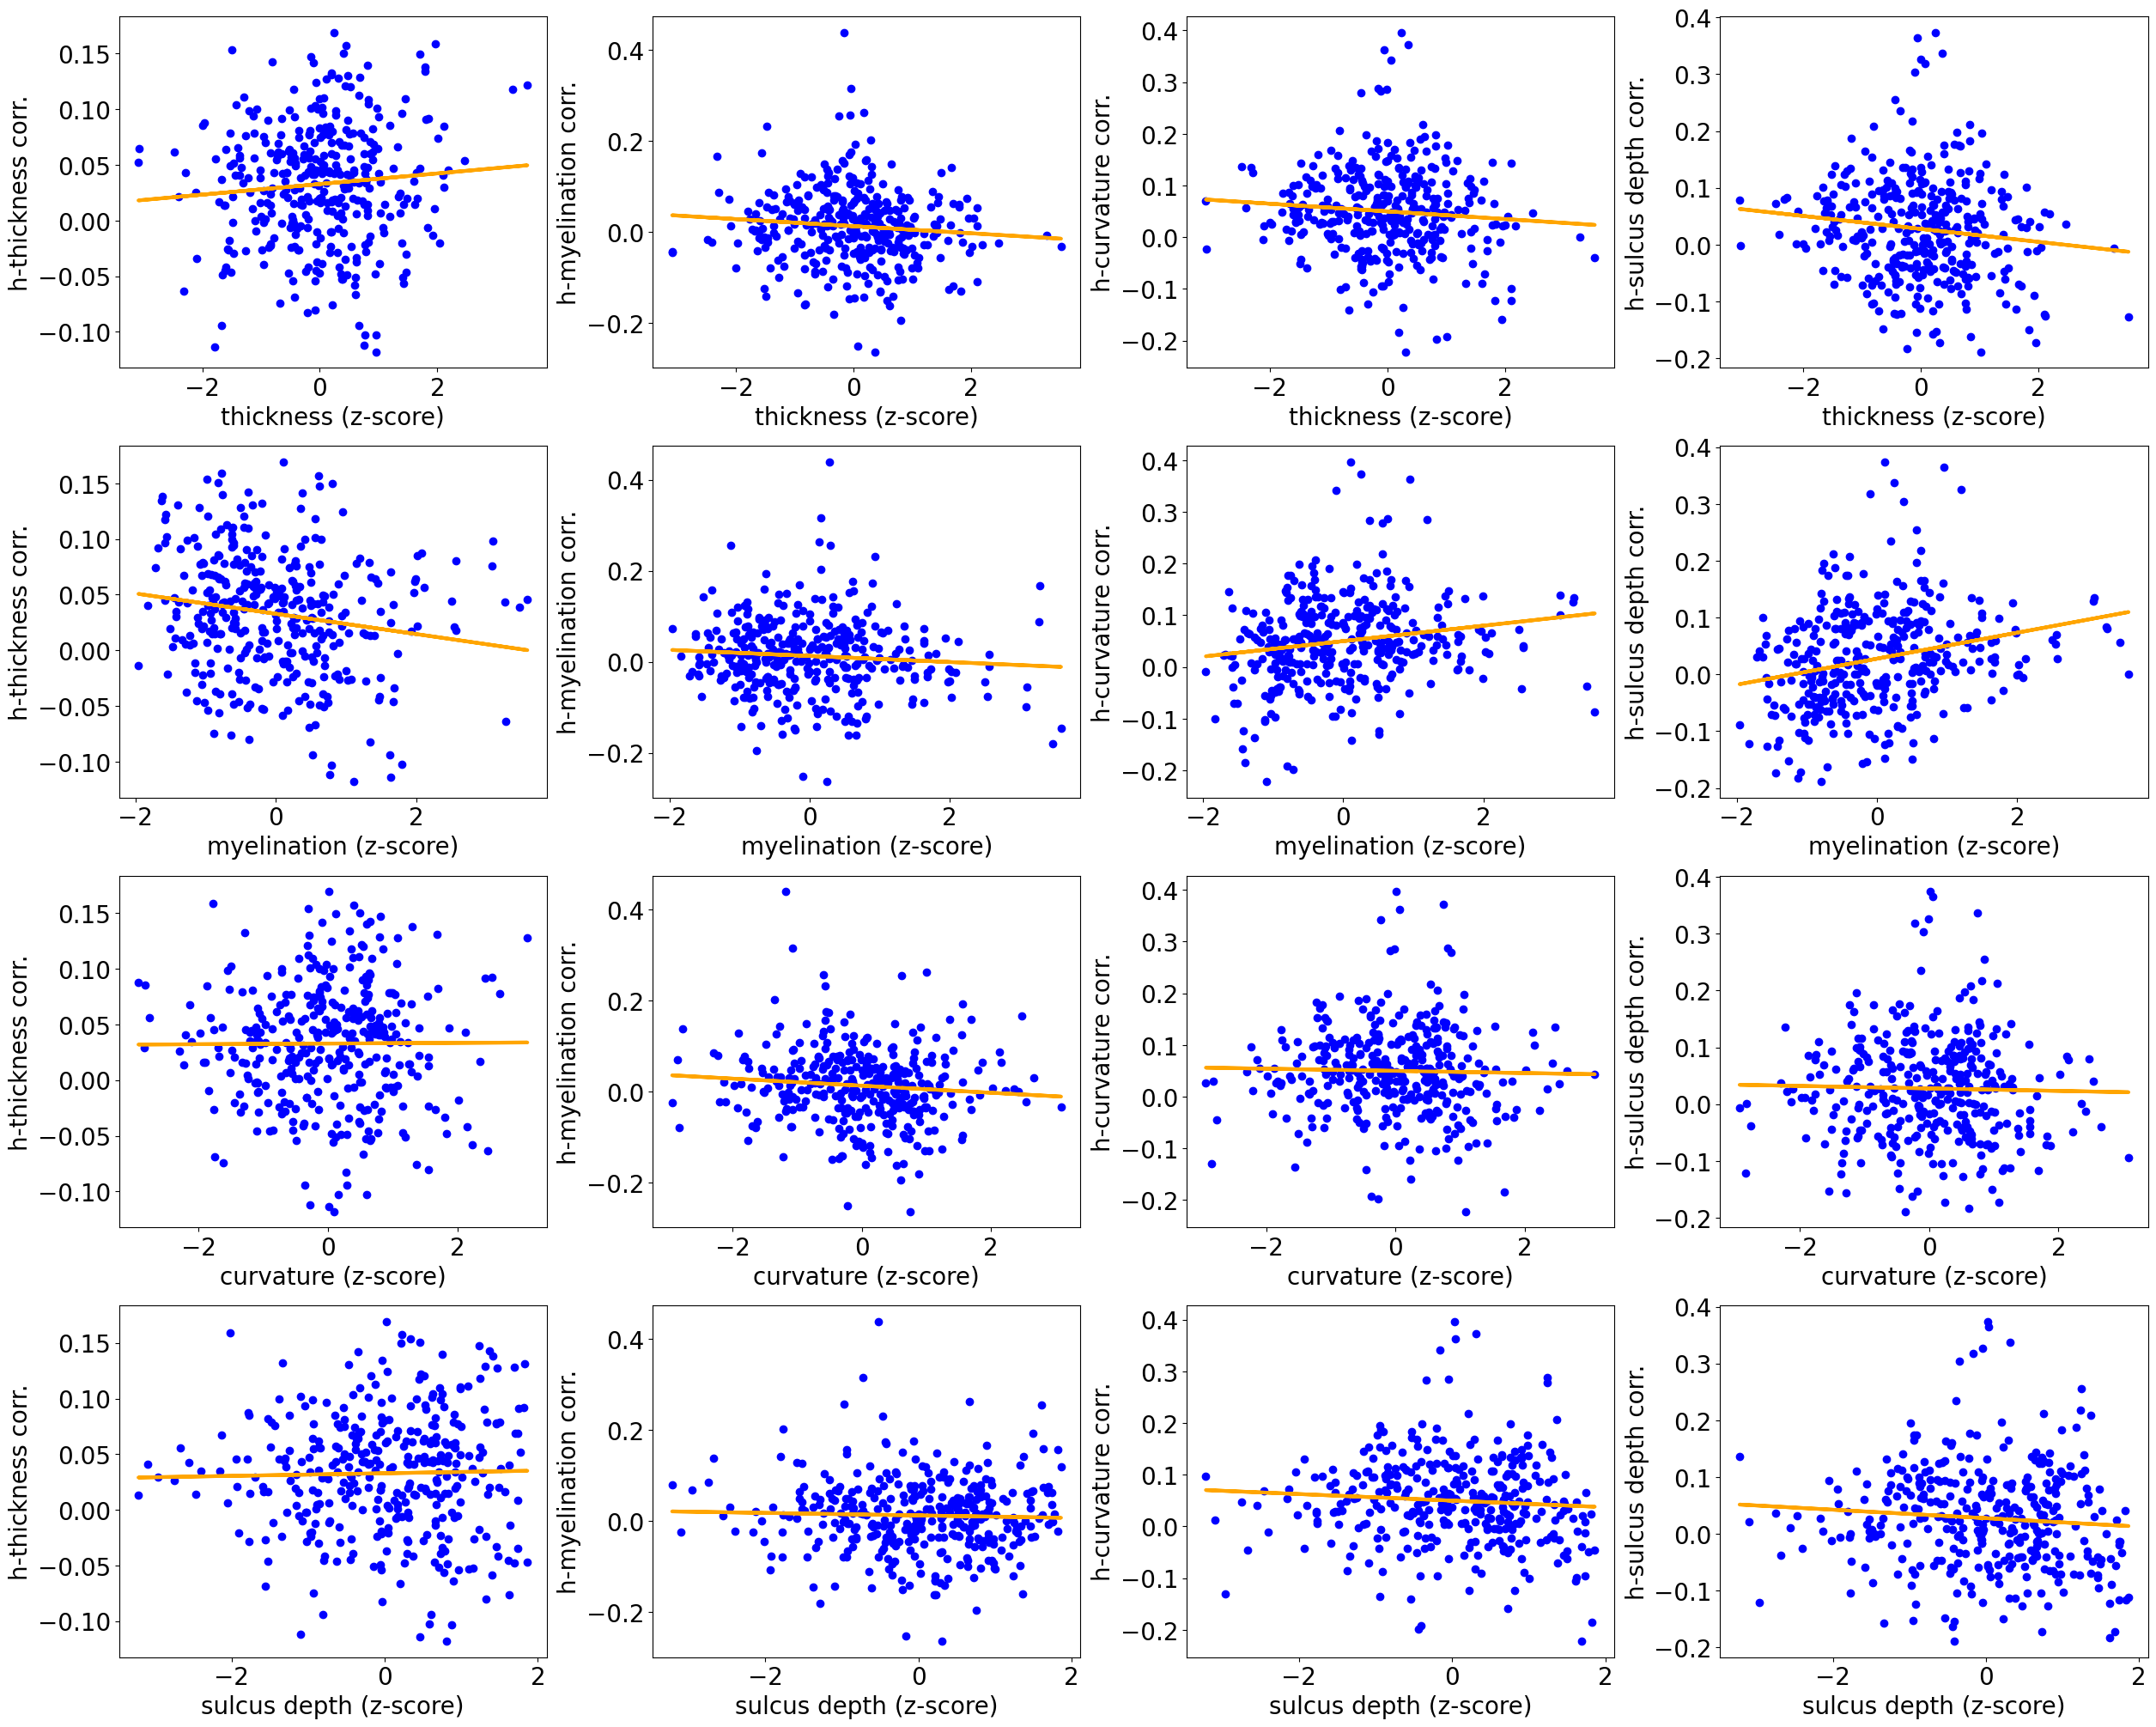

In [51]:
feature_names_file = ['thickness', 'myelination', 'curvature', 'sulcus depth']
num_features = len(feature_names_file)
fig, axs = plt.subplots( nrows=num_features, ncols=num_features, figsize=(25, 20), layout='constrained' )
for feature_index in range(num_features):
    for corr_feature_index in range(num_features):
        selected_features = mean_node_features[:,feature_index]
        selected_feature_name = feature_names_file[feature_index]
        selected_corrs = h_node_feature_corr_tensor[:,corr_feature_index]
        selected_corr_name = f'h-{feature_names_file[corr_feature_index]} corr.'
        make_scatter_plot_with_regression_line(ax=axs[feature_index, corr_feature_index], feature=selected_features, param=selected_corrs, feature_name=selected_feature_name, param_name=selected_corr_name)
        get_correlation_and_p(feature=selected_features, param=selected_corrs, feature_name=selected_feature_name, param_name=selected_corr_name, num_perms=1000)
# plt.tight_layout()
plt.show()

h-thickness corr.=0.164SD(thickness)+0.00415, R^2=0.0178
h-thickness corr. v. SD(thickness) corr.=0.133, p-value=0.016
h-myelination corr.=-0.245SD(thickness)+0.0558, R^2=0.0169
h-myelination corr. v. SD(thickness) corr.=-0.13, p-value=0.012
h-curvature corr.=-0.0904SD(thickness)+0.0659, R^2=0.00219
h-curvature corr. v. SD(thickness) corr.=-0.0466, p-value=0.39
h-sulcus depth corr.=-0.184SD(thickness)+0.0599, R^2=0.00802
h-sulcus depth corr. v. SD(thickness) corr.=-0.0893, p-value=0.091
h-thickness corr.=-0.261SD(myelination)+0.0401, R^2=0.0217
h-thickness corr. v. SD(myelination) corr.=-0.147, p-value=0.007
h-myelination corr.=0.156SD(myelination)+0.00843, R^2=0.00329
h-myelination corr. v. SD(myelination) corr.=0.0572, p-value=0.254
h-curvature corr.=-0.0177SD(myelination)+0.0505, R^2=4.01e-05
h-curvature corr. v. SD(myelination) corr.=-0.00631, p-value=0.895
h-sulcus depth corr.=-0.0267SD(myelination)+0.0284, R^2=8.15e-05
h-sulcus depth corr. v. SD(myelination) corr.=-0.009, p-value

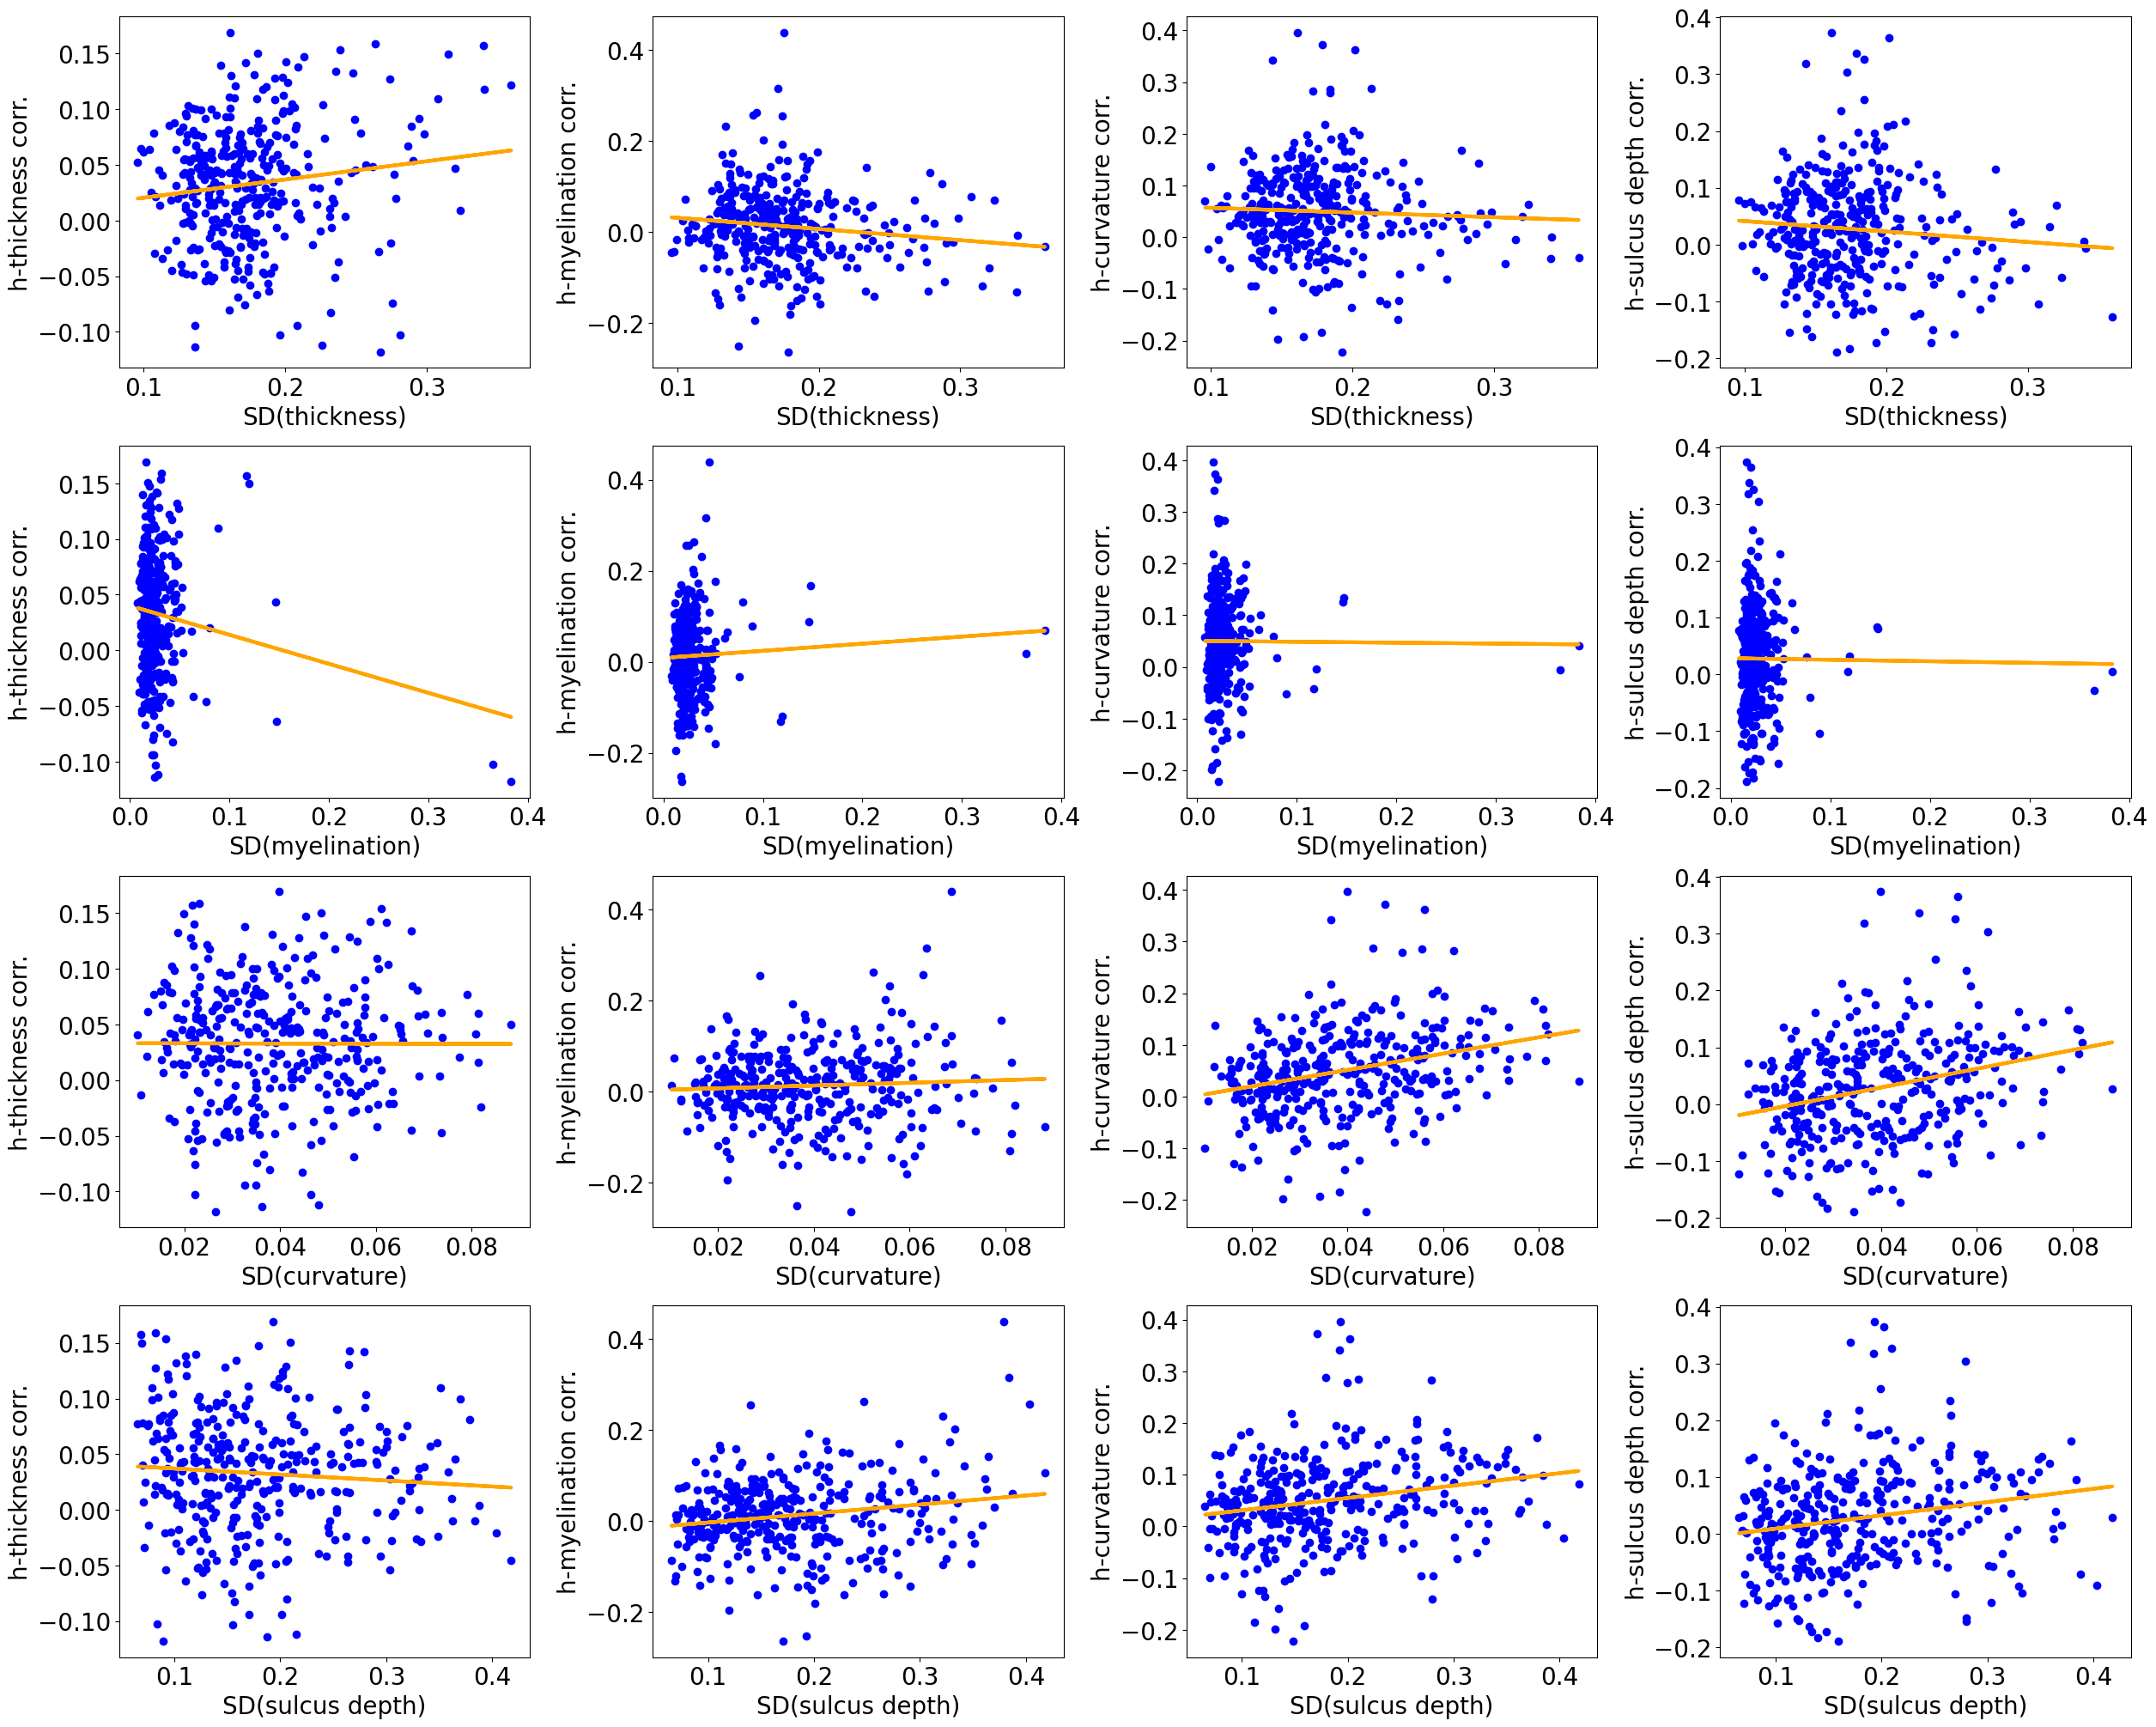

In [56]:
feature_names_file = ['thickness', 'myelination', 'curvature', 'sulcus depth']
num_features = len(feature_names_file)
fig, axs = plt.subplots( nrows=num_features, ncols=num_features, figsize=(25, 20), layout='constrained' )
for feature_index in range(num_features):
    for corr_feature_index in range(num_features):
        selected_features = std_node_features[:,feature_index]
        selected_feature_name = f'SD({feature_names_file[feature_index]})'
        selected_corrs = h_node_feature_corr_tensor[:,corr_feature_index]
        selected_corr_name = f'h-{feature_names_file[corr_feature_index]} corr.'
        make_scatter_plot_with_regression_line_no_z(ax=axs[feature_index, corr_feature_index], feature=selected_features, param=selected_corrs, feature_name=selected_feature_name, param_name=selected_corr_name)
        get_correlation_and_p(feature=selected_features, param=selected_corrs, feature_name=selected_feature_name, param_name=selected_corr_name, num_perms=1000)
# plt.tight_layout()
plt.show()

In [65]:
# J_sc_corr = torch.load( os.path.join(file_dir, f'J_sc_corr_{param_string}.pt'), weights_only=False )
print( sc.size(), J.size() )
J_sc_corr = isingmodellight.get_pairwise_correlation( mat1=sc, mat2=J, epsilon=0.0, dim=0 )
print( J_sc_corr.size() )
print( J_sc_corr.min() )
print( J_sc_corr.max() )

torch.Size([670, 64620]) torch.Size([670, 64620])
torch.Size([64620])
tensor(-0.1859, device='cuda:0')
tensor(0.4125, device='cuda:0')


J-SC corr.=0.78mean SC+0.0026, R^2=0.0611


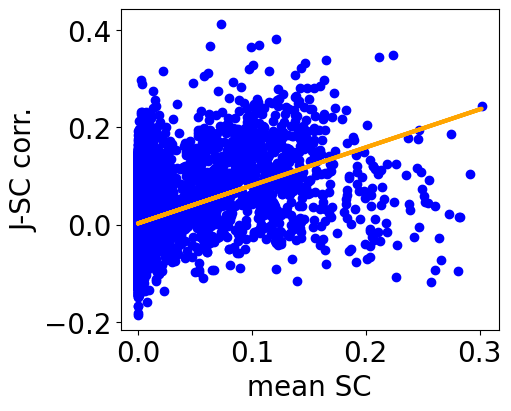

In [69]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )

feature_name = 'SC'
make_scatter_plot_with_regression_line_no_z(ax=axs, feature=mean_sc, param=J_sc_corr, feature_name=f'mean {feature_name}', param_name=f'J-{feature_name} corr.')

# plt.tight_layout()
plt.show()

In [76]:
get_correlation_and_p(feature=mean_sc, param=J_sc_corr, feature_name=f'mean({feature_name})', param_name=f'J-{feature_name} corr.', num_perms=1000)

J-SC corr. v. mean(SC) corr.=0.247, p-value=0


(tensor(0.2471, device='cuda:0'), tensor(0., device='cuda:0'))

J-SC corr.=4.65SD(SC)+0.000294, R^2=0.084


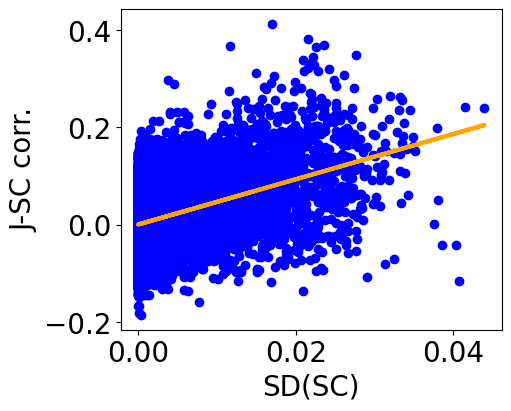

In [70]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )

feature_name = 'SC'
make_scatter_plot_with_regression_line_no_z(ax=axs, feature=std_sc, param=J_sc_corr, feature_name=f'SD({feature_name})', param_name=f'J-{feature_name} corr.')

# plt.tight_layout()
plt.show()

In [75]:
get_correlation_and_p(feature=std_sc, param=J_sc_corr, feature_name=f'SD({feature_name})', param_name=f'J-{feature_name} corr.', num_perms=1000)

J-SC corr. v. SD(SC) corr.=0.29, p-value=0


(tensor(0.2898, device='cuda:0'), tensor(0., device='cuda:0'))

In [67]:
# fc_sc_corr = torch.load( os.path.join(file_dir, f'fc_sc_corr_{param_string}.pt'), weights_only=False )
print( sc.size(), fc.size() )
fc_sc_corr = isingmodellight.get_pairwise_correlation( mat1=sc, mat2=fc, epsilon=0.0, dim=0 )
print( fc_sc_corr.size() )
print( fc_sc_corr.min() )
print( fc_sc_corr.max() )

torch.Size([670, 64620]) torch.Size([670, 64620])
torch.Size([64620])
tensor(-0.1799, device='cuda:0')
tensor(0.2936, device='cuda:0')


torch.Size([64620]) torch.Size([64620])
FC-SC corr.=0.554mean SC+-0.00149, R^2=0.0281


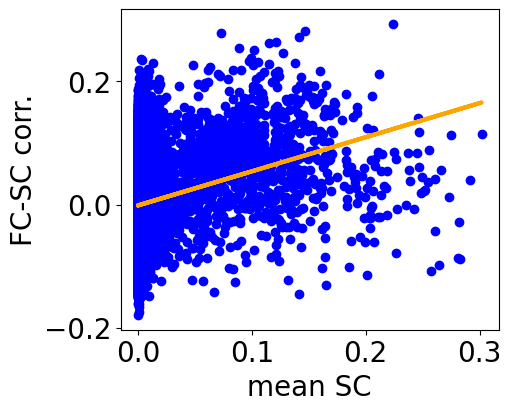

In [71]:
print( fc_sc_corr.size(), mean_sc.size() )
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )

feature_name = 'SC'
make_scatter_plot_with_regression_line_no_z(ax=axs, feature=mean_sc, param=fc_sc_corr, feature_name=f'mean {feature_name}', param_name=f'FC-{feature_name} corr.')

# plt.tight_layout()
plt.show()

In [74]:
get_correlation_and_p(feature=mean_sc, param=fc_sc_corr, feature_name=f'mean({feature_name})', param_name=f'FC-{feature_name} corr.', num_perms=1000)

FC-SC corr. v. mean(SC) corr.=0.168, p-value=0


(tensor(0.1677, device='cuda:0'), tensor(0., device='cuda:0'))

torch.Size([64620]) torch.Size([64620])
FC-SC corr.=3.4SD(SC)+-0.00322, R^2=0.041


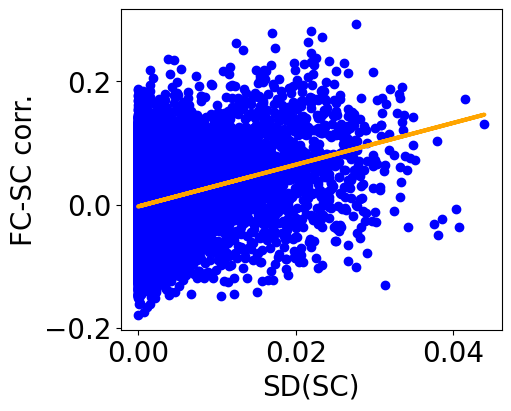

In [77]:
print( fc_sc_corr.size(), mean_sc.size() )
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )

feature_name = 'SC'
make_scatter_plot_with_regression_line_no_z(ax=axs, feature=std_sc, param=fc_sc_corr, feature_name=f'SD({feature_name})', param_name=f'FC-{feature_name} corr.')

# plt.tight_layout()
plt.show()

In [78]:
get_correlation_and_p(feature=std_sc, param=fc_sc_corr, feature_name=f'SD({feature_name})', param_name=f'FC-{feature_name} corr.', num_perms=1000)

FC-SC corr. v. SD(SC) corr.=0.202, p-value=0


(tensor(0.2024, device='cuda:0'), tensor(0., device='cuda:0'))

group h (threshold=1)=11.6mean myelination+-17.2, R^2=0.107
SD of h (threshold=1)=-3.17mean myelination+9.3, R^2=0.199
h-sulcus depth corr.=0.193mean myelination+-0.226, R^2=0.0642
group J (threshold=1)=140mean SC+0.53, R^2=0.264
SD of J (threshold=1)=22.7mean SC+4.22, R^2=0.123
J-SC corr.=0.78mean SC+0.0026, R^2=0.0611


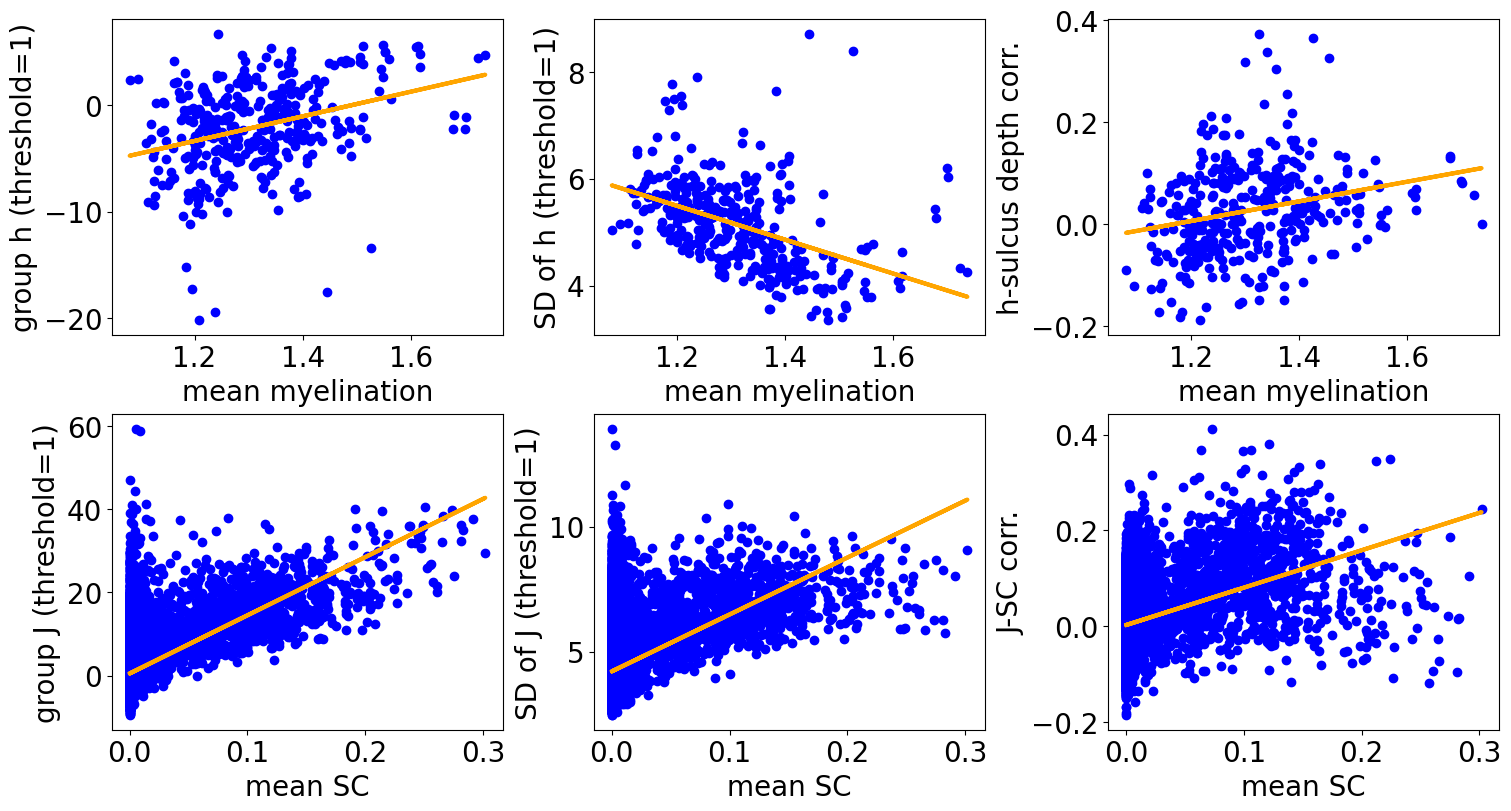

In [80]:
fig, axs = plt.subplots( nrows=2, ncols=3, figsize=(15, 8), layout='constrained' )

selected_threshold_index = get_closest_match(values=threshold, target=1.0)
selected_threshold = threshold[selected_threshold_index]
selected_h = group_h[selected_threshold_index,:]
selected_J = group_J[selected_threshold_index,:]

feature_index = 1
feature_name = 'mean myelination'
selected_feature = mean_node_features[:,feature_index]

corr_index = 3
corr_name = 'h-sulcus depth corr.'
selected_corrs = h_node_feature_corr_tensor[:,corr_feature_index]

make_scatter_plot_with_regression_line_no_z(ax=axs[0,0], feature=selected_feature, param=selected_h, feature_name=feature_name, param_name=f'group h (threshold={selected_threshold:.3g})')
make_scatter_plot_with_regression_line_no_z(ax=axs[0,1], feature=selected_feature, param=h_std, feature_name=feature_name, param_name=f'SD of h (threshold={selected_threshold:.3g})')
make_scatter_plot_with_regression_line_no_z(ax=axs[0,2], feature=selected_feature, param=selected_corrs, feature_name=feature_name, param_name=corr_name)

make_scatter_plot_with_regression_line_no_z(ax=axs[1,0], feature=mean_sc, param=selected_J, feature_name='mean SC', param_name=f'group J (threshold={selected_threshold:.3g})')
make_scatter_plot_with_regression_line_no_z(ax=axs[1,1], feature=mean_sc, param=J_std, feature_name='mean SC', param_name=f'SD of J (threshold={selected_threshold:.3g})')
make_scatter_plot_with_regression_line_no_z(ax=axs[1,2], feature=mean_sc, param=J_sc_corr, feature_name='mean SC', param_name=f'J-SC corr.')

# plt.tight_layout()
plt.show()

In [81]:
print( h.size() )
print( node_features.size() )
h_for_lstsq = h.transpose(dim0=0, dim1=1).unsqueeze(dim=-1)
node_features_for_lstsq = torch.cat(  ( node_features.transpose(dim0=0, dim1=1), torch.ones_like(h_for_lstsq) ), dim=-1  )
local_regressions = torch.linalg.lstsq(node_features_for_lstsq, h_for_lstsq)
# print( local_regressions )
local_coeffs = local_regressions.solution
print( local_coeffs.size() )
h_pred_for_lstsq = torch.matmul(node_features_for_lstsq, local_coeffs)
print( h_pred_for_lstsq.size() )
local_h_pred_corr = isingmodellight.get_pairwise_correlation( mat1=h_for_lstsq, mat2=h_pred_for_lstsq, epsilon=0, dim=1 ).squeeze(dim=-1)
print( 'correlation size', local_h_pred_corr.size(), 'min', local_h_pred_corr.min().item(), 'mean', local_h_pred_corr.mean().item(), 'max', local_h_pred_corr.max().item() )

torch.Size([670, 360])
torch.Size([670, 360, 4])
torch.Size([360, 5, 1])
torch.Size([360, 670, 1])
correlation size torch.Size([360]) min 0.03156592324376106 mean 0.14099037647247314 max 0.4708344340324402


In [192]:
num_permutations = 10000
local_p_values = torch.zeros_like(local_h_pred_corr)
num_subjects = h_for_lstsq.size(dim=1)
num_greater_perms = torch.zeros_like(local_h_pred_corr)
for _ in range(num_permutations):
    perm = torch.randperm(n=num_subjects, dtype=int_type, device=h_for_lstsq.device)
    h_perm_for_lstsq = h_for_lstsq[:,perm,:]
    num_greater_perms += (   isingmodellight.get_pairwise_correlation(  mat1=h_perm_for_lstsq, mat2=torch.matmul( node_features_for_lstsq, torch.linalg.lstsq(node_features_for_lstsq, h_perm_for_lstsq).solution ), epsilon=0, dim=1  ).squeeze(dim=-1) >= local_h_pred_corr   ).float()
p_values = num_greater_perms/num_permutations
num_nodes = h_for_lstsq.size(dim=0)
alpha = 0.05/num_nodes
is_sig = p_values < alpha
num_sig = torch.count_nonzero(is_sig)
print( f'num perms {num_permutations}, p-value min {p_values.min():.3g}, mean {p_values.mean():.3g}, max {p_values.max():.3g}, num significant (< {alpha:.3g}) {num_sig}' )

num perms 10000, p-value min 0, mean 0.123, max 0.957, num significant (< 0.000139) 63


In [126]:
torch.save( obj=local_coeffs, f=os.path.join(file_dir, f'coeffs_node_features_to_h_1_{param_string}') )

In [127]:
torch.save( obj=h_pred_for_lstsq, f=os.path.join(file_dir, f'h_pred_node_features_to_h_1_{param_string}') )

In [128]:
torch.save( obj=local_h_pred_corr, f=os.path.join(file_dir, f'h_pred_corr_node_features_to_h_1_{param_string}') )

In [129]:
torch.save( obj=p_values, f=os.path.join(file_dir, f'p_values_node_features_to_h_1_{param_string}') )

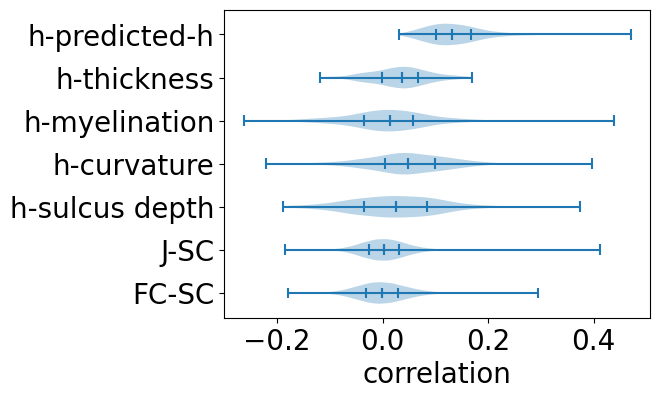

In [83]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5.5, 4) )
corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(local_h_pred_corr)] + [depytorch(h_node_feature_corr_tensor[:,feature_index]) for feature_index in range( h_node_feature_corr_tensor.size(dim=-1) )] + [depytorch(J_sc_corr), depytorch(fc_sc_corr)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# all_max_crit_corrs = [cc.item() for cc in max_h_node_feature_crit_corr_tensor] + [fc_sc_crit_corr_max, fc_sc_crit_corr_max]
# axs.scatter(  list( reversed(all_max_crit_corrs) ), label_x, color='red', marker='|', linewidth=2, s=80  )
# axs.scatter(  list( reversed([-cc for cc in all_max_crit_corrs]) ), label_x, color='red', marker='|', linewidth=2, s=80  )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
plt.show()

In [84]:
combined_h_pred_corr = local_h_pred_corr

In [105]:
print( h.size() )
print( node_features.size() )
num_features = node_features.size(dim=-1)
h_for_lstsq = h.transpose(dim0=0, dim1=1).unsqueeze(dim=-1)
node_features_for_lstsq = torch.cat(  ( node_features.transpose(dim0=0, dim1=1), torch.ones_like(h_for_lstsq) ), dim=-1  )
num_nodes = h_for_lstsq.size(dim=0)
single_feature_local_h_pred_corr = torch.zeros( (num_nodes, num_features), dtype=h.dtype, device=h.device )
for feature_index in range(num_features):
    node_feature_and_1 = node_features_for_lstsq[ :, :, [feature_index,-1] ]
    feature_coeffs = torch.linalg.lstsq(node_feature_and_1, h_for_lstsq).solution
    h_pred_for_lstsq_feature = torch.matmul(node_feature_and_1, feature_coeffs)
    local_h_pred_corr_feature = isingmodellight.get_pairwise_correlation( mat1=h_for_lstsq, mat2=h_pred_for_lstsq_feature, epsilon=0, dim=1 ).squeeze(dim=-1)
    print( 'correlation size', local_h_pred_corr_feature.size(), 'min', local_h_pred_corr_feature.min().item(), 'mean', local_h_pred_corr_feature.mean().item(), 'max', local_h_pred_corr_feature.max().item() )
    single_feature_local_h_pred_corr[:,feature_index] = local_h_pred_corr_feature

torch.Size([670, 360])
torch.Size([670, 360, 4])
correlation size torch.Size([360]) min -0.0006727965082973242 mean 0.05170496925711632 max 0.16923122107982635
correlation size torch.Size([360]) min 0.0 mean 0.06199647858738899 max 0.4387303590774536
correlation size torch.Size([360]) min 0.0006932370597496629 mean 0.07595488429069519 max 0.39650458097457886
correlation size torch.Size([360]) min -0.009351980872452259 mean 0.07252230495214462 max 0.3739393949508667


In [139]:
print( J.size() )
print( sc.size() )
J_for_lstsq = J.transpose(dim0=0, dim1=1).unsqueeze(dim=-1)
sc_for_lstsq = torch.cat(  ( sc.transpose(dim0=0, dim1=1).unsqueeze(dim=-1), torch.ones_like(J_for_lstsq) ), dim=-1  )
# print( local_regressions )
local_coeffs_J = torch.linalg.lstsq(sc_for_lstsq, J_for_lstsq).solution
print( local_coeffs_J.size() )
J_pred_for_lstsq = torch.matmul(sc_for_lstsq, local_coeffs_J)
print( J_pred_for_lstsq.size() )
local_J_pred_corr = isingmodellight.get_pairwise_correlation( mat1=J_for_lstsq, mat2=J_pred_for_lstsq, epsilon=0, dim=1 ).squeeze(dim=-1)
print( 'correlation size', local_J_pred_corr.size(), 'min', local_J_pred_corr.min().item(), 'mean', local_J_pred_corr.mean().item(), 'max', local_J_pred_corr.max().item() )

torch.Size([670, 64620])
torch.Size([670, 64620])
torch.Size([64620, 2, 1])
torch.Size([64620, 670, 1])
correlation size torch.Size([64620]) min -0.08865534514188766 mean 0.035023897886276245 max 0.4124874472618103


In [88]:
print( fc.size() )
print( sc.size() )
fc_for_lstsq = fc.transpose(dim0=0, dim1=1).unsqueeze(dim=-1)
sc_for_lstsq = torch.cat(  ( sc.transpose(dim0=0, dim1=1).unsqueeze(dim=-1), torch.ones_like(fc_for_lstsq) ), dim=-1  )
# print( local_regressions )
local_coeffs_fc = torch.linalg.lstsq(sc_for_lstsq, fc_for_lstsq).solution
# print( local_coeffs_fc.size() )
fc_pred_for_lstsq = torch.matmul(sc_for_lstsq, local_coeffs_fc)
print( sc_for_lstsq.size(), 'x', local_coeffs_fc.size(), '=', fc_pred_for_lstsq.size() )
local_fc_pred_corr = isingmodellight.get_pairwise_correlation( mat1=fc_for_lstsq, mat2=fc_pred_for_lstsq, epsilon=0, dim=1 ).squeeze(dim=-1)
print( 'correlation size', local_fc_pred_corr.size(), 'min', local_fc_pred_corr.min().item(), 'mean', local_fc_pred_corr.mean().item(), 'max', local_fc_pred_corr.max().item() )

torch.Size([670, 64620])
torch.Size([670, 64620])
torch.Size([64620, 670, 2]) x torch.Size([64620, 2, 1]) = torch.Size([64620, 670, 1])
correlation size torch.Size([64620]) min -0.07420987635850906 mean 0.037573639303445816 max 0.29355645179748535


FC=-0.0472SC+0.282, R^2=0
FC v. SC corr.=0.000218, p-value=0.998


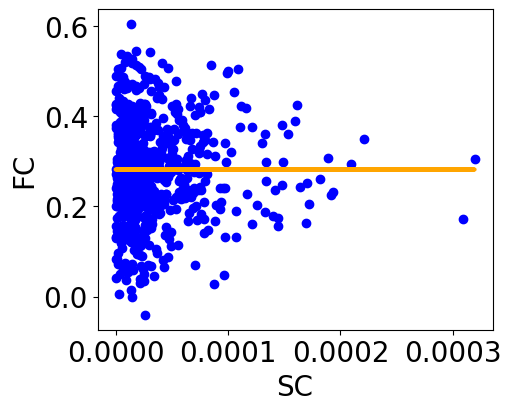

In [89]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )

min_corr_index = local_fc_pred_corr.argmin()
worst_sc = sc_for_lstsq[min_corr_index,:,0]
worst_fc = fc_for_lstsq[min_corr_index,:,0]
make_scatter_plot_with_regression_line_no_z(ax=axs, feature=worst_sc, param=worst_fc, feature_name='SC', param_name='FC')
get_correlation_and_p(feature=worst_sc, param=worst_fc, feature_name='SC', param_name=f'FC', num_perms=1000)

# plt.tight_layout()
plt.show()

previously calculated predicted-actual FC corr. -0.0742
true FC=-11.6predicted FC+3.55, R^2=1.19e-07
true FC v. predicted FC corr.=-0.032, p-value=0.376


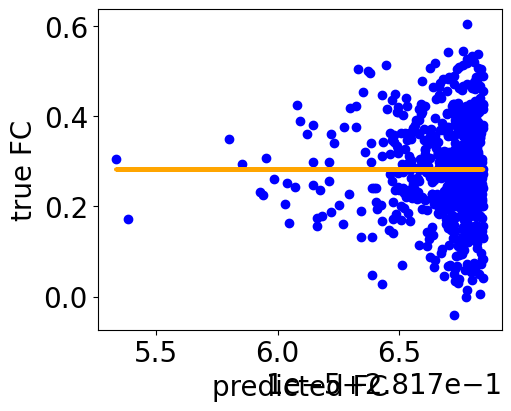

In [90]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )

min_corr_index = local_fc_pred_corr.argmin()
print(f'previously calculated predicted-actual FC corr. {local_fc_pred_corr[min_corr_index]:.3g}')
worst_fc_pred = fc_pred_for_lstsq[min_corr_index,:,0]
worst_fc = fc_for_lstsq[min_corr_index,:,0]
make_scatter_plot_with_regression_line_no_z(ax=axs, feature=worst_fc_pred, param=worst_fc, feature_name='predicted FC', param_name='true FC')
get_correlation_and_p(feature=worst_fc_pred, param=worst_fc, feature_name='predicted FC', param_name='true FC', num_perms=1000)

# plt.tight_layout()
plt.show()

In [91]:
print( local_fc_pred_corr.size() )
print(min_corr_index)
print( worst_fc.size() )

torch.Size([64620])
tensor(26909, device='cuda:0')
torch.Size([670])


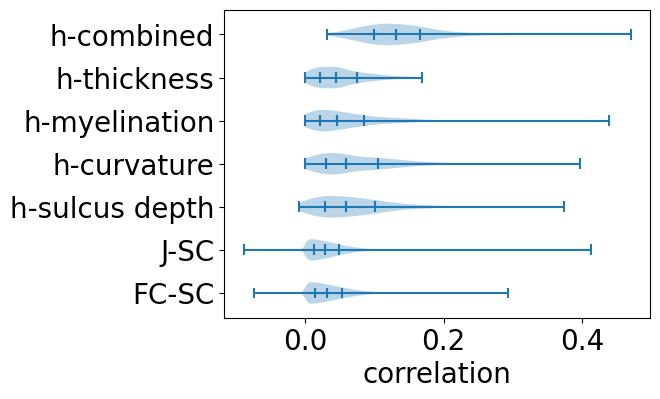

In [92]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5.5, 4) )
corr_labels = ['h-combined'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(local_h_pred_corr)] + [depytorch(single_feature_local_h_pred_corr[:,feature_index]) for feature_index in range( single_feature_local_h_pred_corr.size(dim=-1) )] + [depytorch(local_J_pred_corr), depytorch(local_fc_pred_corr)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# all_max_crit_corrs = [cc.item() for cc in max_h_node_feature_crit_corr_tensor] + [fc_sc_crit_corr_max, fc_sc_crit_corr_max]
# axs.scatter(  list( reversed(all_max_crit_corrs) ), label_x, color='red', marker='|', linewidth=2, s=80  )
# axs.scatter(  list( reversed([-cc for cc in all_max_crit_corrs]) ), label_x, color='red', marker='|', linewidth=2, s=80  )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
plt.show()

previously calculated predicted-actual h corr. 0.0316
true h=1predicted h+3.85e-06, R^2=0.000999
true h v. predicted h corr.=0.0316, p-value=0.407


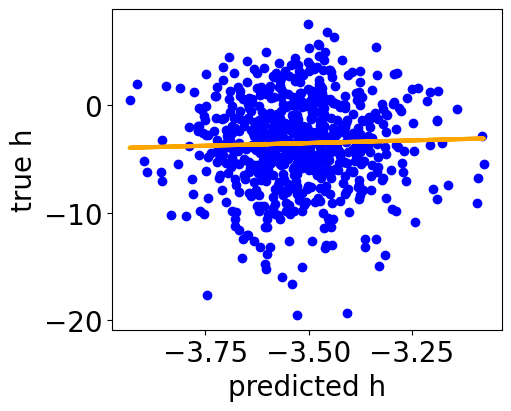

In [93]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )

min_corr_index = local_h_pred_corr.argmin()
print(f'previously calculated predicted-actual h corr. {local_h_pred_corr[min_corr_index]:.3g}')
worst_h_pred = h_pred_for_lstsq[min_corr_index,:,0]
worst_h = h_for_lstsq[min_corr_index,:,0]
make_scatter_plot_with_regression_line_no_z(ax=axs, feature=worst_h_pred, param=worst_h, feature_name='predicted h', param_name='true h')
get_correlation_and_p(feature=worst_h_pred, param=worst_h, feature_name='predicted h', param_name='true h', num_perms=1000)

# plt.tight_layout()
plt.show()

In [94]:
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']

In [98]:
print( h.size() )
print( node_features.size() )
num_features = node_features.size(dim=-1)
h_for_lstsq = h.transpose(dim0=0, dim1=1).unsqueeze(dim=-1)
node_features_for_lstsq = torch.cat(  ( node_features.transpose(dim0=0, dim1=1), torch.ones_like(h_for_lstsq) ), dim=-1  )
num_nodes = h_for_lstsq.size(dim=0)
single_feature_local_h_pred_corr = torch.zeros( (num_nodes, num_features), dtype=h.dtype, device=h.device )

feature_index = 3
feature_name = feature_names[feature_index]

node_feature_and_1 = node_features_for_lstsq[ :, :, [feature_index,-1] ]
feature_coeffs = torch.linalg.lstsq(node_feature_and_1, h_for_lstsq).solution
h_pred_for_lstsq_feature = torch.matmul(node_feature_and_1, feature_coeffs)
local_h_pred_corr_feature = isingmodellight.get_pairwise_correlation( mat1=h_for_lstsq, mat2=h_pred_for_lstsq_feature, epsilon=0, dim=1 ).squeeze(dim=-1)
print( f'h-h({feature_name}) correlation size', local_h_pred_corr_feature.size(), 'min', local_h_pred_corr_feature.min().item(), 'mean', local_h_pred_corr_feature.mean().item(), 'max', local_h_pred_corr_feature.max().item() )

torch.Size([670, 360])
torch.Size([670, 360, 4])
h-h(sulcus depth) correlation size torch.Size([360]) min -0.009351980872452259 mean 0.07252230495214462 max 0.3739393949508667


previously calculated predicted-actual h corr. 0.374
true h=1predicted h(sulcus depth)+-7.58e-08, R^2=0.14
true h v. predicted h(sulcus depth) corr.=0.374, p-value=0


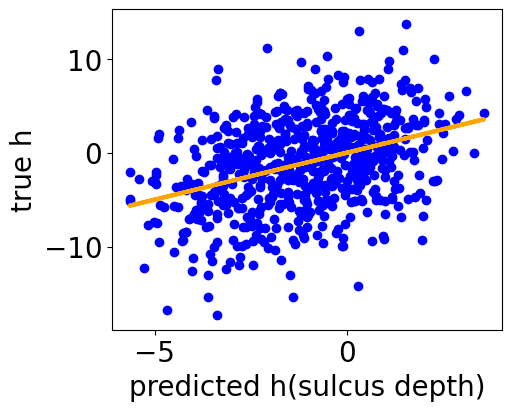

In [99]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )

# min_corr_index = local_h_pred_corr_feature.argmin()
min_corr_index = local_h_pred_corr_feature.argmax()
print(f'previously calculated predicted-actual h corr. {local_h_pred_corr_feature[min_corr_index]:.3g}')
worst_h_pred = h_pred_for_lstsq_feature[min_corr_index,:,0]
worst_h = h_for_lstsq[min_corr_index,:,0]
make_scatter_plot_with_regression_line_no_z(ax=axs, feature=worst_h_pred, param=worst_h, feature_name=f'predicted h({feature_name})', param_name='true h')
get_correlation_and_p(feature=worst_h_pred, param=worst_h, feature_name=f'predicted h({feature_name})', param_name='true h', num_perms=1000)

# plt.tight_layout()
plt.show()

In [185]:
J_sc_results_from_script = torch.load( os.path.join(file_dir, 'sc_J_linear_model_ising_model_light_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000.pt'), weights_only=False )
print( len(J_sc_results_from_script) )

8


In [186]:
sc_J_coeffs = J_sc_results_from_script[0]
print( sc_J_coeffs.size() )
sc_J_dependent_prediction = J_sc_results_from_script[1]
print( sc_J_dependent_prediction.size() )
sc_J_r_squared = J_sc_results_from_script[2]
print( sc_J_r_squared.size() )
sc_J_pred_corr = J_sc_results_from_script[3]
print( sc_J_pred_corr.size() )
sc_J_p_r_squared = J_sc_results_from_script[4]
print( sc_J_p_r_squared.size() )
sc_J_p_pred_corr = J_sc_results_from_script[5]
print( sc_J_p_pred_corr.size() )
sc_J_corr = J_sc_results_from_script[6]
print( sc_J_corr.size() )
sc_J_p_corr = J_sc_results_from_script[7]
print( sc_J_p_corr.size() )

torch.Size([64620, 2, 1])
torch.Size([64620, 837, 1])
torch.Size([64620])
torch.Size([64620])
torch.Size([64620])
torch.Size([64620])
torch.Size([64620])
torch.Size([64620])


In [187]:
print( f'SC-J direct correlation min {sc_J_corr.min():.3g} mean {sc_J_corr.mean():.3g} max {sc_J_corr.max():.3g}' )
print( f'predicted J(SC)-J correlation min {sc_J_pred_corr.min():.3g} mean {sc_J_pred_corr.mean():.3g} max {sc_J_pred_corr.max():.3g}' )

SC-J direct correlation min -0.166 mean 0.00434 max 0.404
predicted J(SC)-J correlation min -0.0941 mean 0.0322 max 0.404


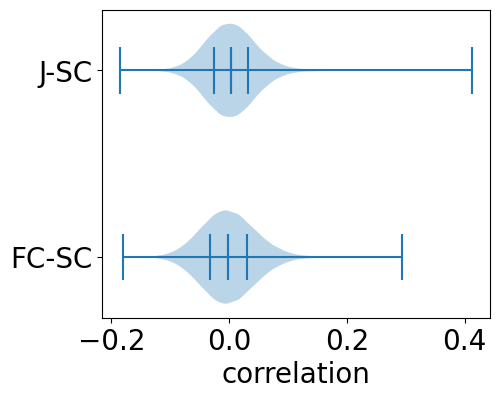

WilcoxonResult(statistic=np.float64(1153151997.0), pvalue=np.float64(1.2212472448656888e-117))


In [100]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
corr_labels = ['J-SC', 'FC-SC']
label_x = range( 1, len(corr_labels)+1 )
J_sc_corr_np = depytorch(J_sc_corr)
fc_sc_corr_np = depytorch(fc_sc_corr)
all_corrs = [J_sc_corr_np, fc_sc_corr_np]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# all_max_crit_corrs = [cc.item() for cc in max_h_node_feature_crit_corr_tensor] + [fc_sc_crit_corr_max, fc_sc_crit_corr_max]
# axs.scatter(  list( reversed(all_max_crit_corrs) ), label_x, color='red', marker='|', linewidth=2, s=80  )
# axs.scatter(  list( reversed([-cc for cc in all_max_crit_corrs]) ), label_x, color='red', marker='|', linewidth=2, s=80  )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
plt.show()
test_result = stats.wilcoxon(x=J_sc_corr_np, y=fc_sc_corr_np, alternative='greater')
print( test_result )

In [101]:
is_greater = (J_sc_corr - fc_sc_corr) > 0
num_greater = torch.count_nonzero(is_greater)
num_pairs = is_greater.numel()
print(f'{num_greater} of {num_pairs} ({num_greater/num_pairs:.3g}) pairs have greater J-SC correlations than FC-SC correlations.')

34648 of 64620 (0.536) pairs have greater J-SC correlations than FC-SC correlations.


J-SC corr.=0.408FC-SC corr.+0.00442, R^2=0.183
J-SC corr. v. FC-SC corr. corr.=0.428, p-value=0


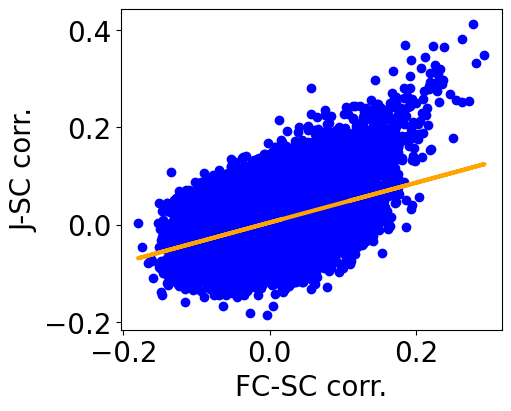

In [102]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )

make_scatter_plot_with_regression_line_no_z(ax=axs, feature=fc_sc_corr, param=J_sc_corr, feature_name='FC-SC corr.', param_name='J-SC corr.')
get_correlation_and_p(feature=fc_sc_corr, param=J_sc_corr, feature_name='FC-SC corr.', param_name='J-SC corr.', num_perms=1000)

# plt.tight_layout()
plt.show()

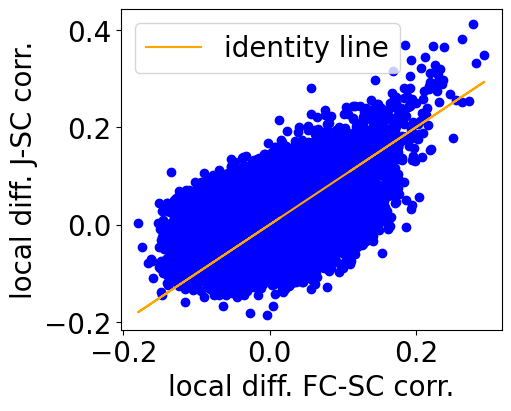

In [124]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )
axs.scatter( depytorch(fc_sc_corr), depytorch(J_sc_corr), color='blue' )
identity_ones = depytorch(fc_sc_corr)
axs.plot( identity_ones, identity_ones, color='orange', label='identity line' )
axs.set_xlabel('local diff. FC-SC corr.')
axs.set_ylabel('local diff. J-SC corr.')
# axs.legend(loc='lower right')
axs.legend()

In [38]:
fc_sc_corr_old = torch.load( os.path.join(file_dir, f'fc_sc_corr_{param_string}.pt'), weights_only=False )
print( fc_sc_corr_old.size() )

torch.Size([64620])


In [39]:
fc_sc_crit_corr = torch.load( os.path.join(file_dir, f'fc_sc_corr_critical_{param_string}_perms_258480000_alpha_1.93e-08.pt'), weights_only=False )
# fc_sc_crit_corr = torch.load( os.path.join(file_dir, f'fc_sc_corr_critical_{param_string}_perms_25848000_alpha_1.93e-08.pt'), weights_only=False )
print( fc_sc_crit_corr.size() )

torch.Size([64620])


In [40]:
J_sc_corr_old = torch.load( os.path.join(file_dir, f'J_sc_corr_{param_string}.pt'), weights_only=False )
print( J_sc_corr_old.size() )

torch.Size([64620])


In [41]:
J_sc_crit_corr = torch.load( os.path.join(file_dir, f'J_sc_corr_critical_{param_string}_perms_258480000_alpha_1.93e-08.pt'), weights_only=False )
# J_sc_crit_corr = torch.load( os.path.join(file_dir, f'J_sc_corr_critical_{param_string}_perms_25848000_alpha_1.93e-08.pt'), weights_only=False )
print( J_sc_crit_corr.size() )

torch.Size([64620])


In [42]:
fc_sc_is_sig = fc_sc_corr_old.abs() > fc_sc_crit_corr
print(f'{torch.count_nonzero(fc_sc_is_sig)} FC-SC correlations are significant.')

92 FC-SC correlations are significant.


In [43]:
J_sc_is_sig = J_sc_corr_old.abs() > J_sc_crit_corr
print(f'{torch.count_nonzero(J_sc_is_sig)} J-SC correlations are significant.')

221 J-SC correlations are significant.


In [45]:
# J_sc_is_sig
# fc_sc_is_sig
# J_sc_corr_old
# fc_sc_corr_old
J_sc_not_sig = torch.logical_not(J_sc_is_sig)
fc_sc_not_sig = torch.logical_not(fc_sc_is_sig)
fc_J_sc_neither_sig = torch.logical_and(J_sc_not_sig, fc_sc_not_sig)
fc_sc_only_sig = torch.logical_and(J_sc_not_sig, fc_sc_is_sig)
J_sc_only_sig = torch.logical_and(J_sc_is_sig, fc_sc_not_sig)
fc_J_sc_both_sig = torch.logical_and(J_sc_is_sig, fc_sc_is_sig)

In [46]:
num_pairs = fc_J_sc_neither_sig.numel()
num_neither = torch.count_nonzero(fc_J_sc_neither_sig)
num_fc_only = torch.count_nonzero(fc_sc_only_sig)
num_J_only = torch.count_nonzero(J_sc_only_sig)
num_both = torch.count_nonzero(fc_J_sc_both_sig)
print(f'{num_neither} ({num_neither/num_pairs:.3g}) pairs have neither FC-SC nor J-SC correlations that are significant.')
print(f'{num_fc_only} ({num_fc_only/num_pairs:.3g}) pairs have only FC-SC correlations that are significant.')
print(f'{num_J_only} ({num_J_only/num_pairs:.3g}) pairs have only J-SC correlations that are significant.')
print(f'{num_both} ({num_both/num_pairs:.3g}) pairs have both FC-SC and J-SC correlations that are significant.')

64376 (0.996) pairs have neither FC-SC nor J-SC correlations that are significant.
23 (0.000356) pairs have only FC-SC correlations that are significant.
152 (0.00235) pairs have only J-SC correlations that are significant.
69 (0.00107) pairs have both FC-SC and J-SC correlations that are significant.


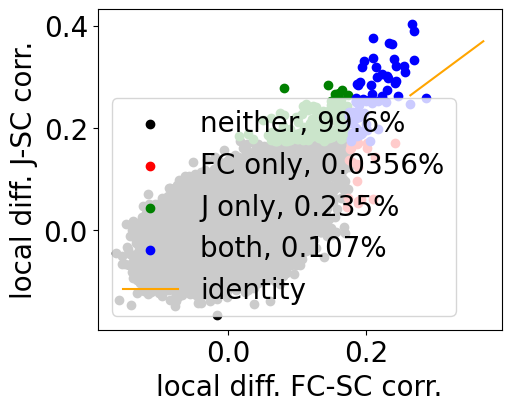

In [47]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )
sig_indices_list = [fc_J_sc_neither_sig, fc_sc_only_sig, J_sc_only_sig, fc_J_sc_both_sig]
sig_color_list = ['black', 'red', 'green', 'blue']
sig_count_list = [num_neither, num_fc_only, num_J_only, num_both]
sig_label_list = ['neither', 'FC only', 'J only', 'both']
for sig_indices, sig_color, sig_count, sig_label in zip(sig_indices_list, sig_color_list, sig_count_list, sig_label_list):
    axs.scatter( depytorch(fc_sc_corr_old[sig_indices]), depytorch(J_sc_corr_old[sig_indices]), color=sig_color, label=f'{sig_label}, {100*sig_count/num_pairs:.3g}%' )
    # axs.scatter( depytorch(fc_sc_corr_old[sig_indices]), depytorch(J_sc_corr_old[sig_indices]), color=sig_color, label=f'{sig_label}' )
identity_ones = depytorch(fc_sc_corr)
axs.plot( identity_ones, identity_ones, color='orange', label='identity' )
axs.set_xlabel('local diff. FC-SC corr.')
axs.set_ylabel('local diff. J-SC corr.')
axs.legend(loc='lower left')
# axs.legend()

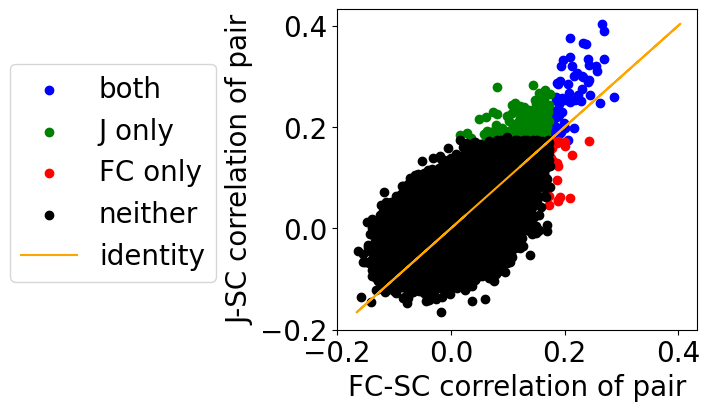

In [102]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5.5, 4), layout='constrained' )
sig_indices_list = [fc_J_sc_both_sig, J_sc_only_sig, fc_sc_only_sig, fc_J_sc_neither_sig]
sig_color_list = ['blue', 'green', 'red', 'black']
sig_count_list = [num_both, num_J_only, num_fc_only, num_neither]
sig_label_list = ['both', 'J only', 'FC only', 'neither']
for sig_indices, sig_color, sig_count, sig_label in zip(sig_indices_list, sig_color_list, sig_count_list, sig_label_list):
    axs.scatter( depytorch(fc_sc_corr_old[sig_indices]), depytorch(J_sc_corr_old[sig_indices]), color=sig_color, label=f'{sig_label}' )
    # axs.scatter( depytorch(fc_sc_corr_old[sig_indices]), depytorch(J_sc_corr_old[sig_indices]), color=sig_color, label=f'{sig_label}' )
identity_ones = depytorch( fc_sc_corr_old.sign() * torch.maximum( fc_sc_corr_old.abs(), J_sc_corr_old.abs() ) )
axs.plot( identity_ones, identity_ones, color='orange', label='identity' )
both_ax_ticks = np.arange(-0.2, 0.4, 0.2)
axs.set_xticks(both_ax_ticks)
axs.set_yticks(both_ax_ticks)
axs.set_xlabel('FC-SC correlation of pair')
axs.set_ylabel('J-SC correlation of pair')
# axs.legend(loc='upper left')
# axs.legend(loc='lower right')
# axs.legend(loc=[1.03, 0.15])
axs.legend(loc=[-0.91, 0.15])

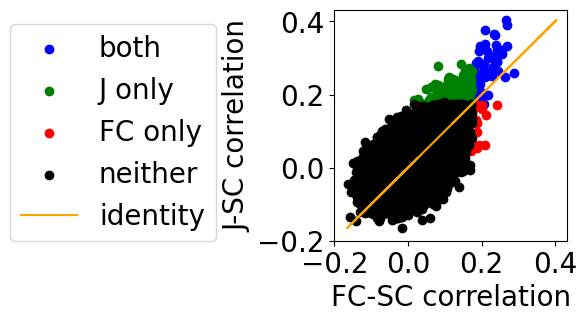

In [168]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(3, 3), layout='constrained' )
sig_indices_list = [fc_J_sc_both_sig, J_sc_only_sig, fc_sc_only_sig, fc_J_sc_neither_sig]
sig_color_list = ['blue', 'green', 'red', 'black']
sig_count_list = [num_both, num_J_only, num_fc_only, num_neither]
sig_label_list = ['both', 'J only', 'FC only', 'neither']
for sig_indices, sig_color, sig_count, sig_label in zip(sig_indices_list, sig_color_list, sig_count_list, sig_label_list):
    axs.scatter( depytorch(fc_sc_corr_old[sig_indices]), depytorch(J_sc_corr_old[sig_indices]), color=sig_color, label=f'{sig_label}' )
    # axs.scatter( depytorch(fc_sc_corr_old[sig_indices]), depytorch(J_sc_corr_old[sig_indices]), color=sig_color, label=f'{sig_label}' )
identity_ones = depytorch( fc_sc_corr_old.sign() * torch.maximum( fc_sc_corr_old.abs(), J_sc_corr_old.abs() ) )
axs.plot( identity_ones, identity_ones, color='orange', label='identity' )
both_ax_ticks = np.arange(-0.2, 0.4, 0.2)
axs.set_xticks(both_ax_ticks)
axs.set_yticks(both_ax_ticks)
axs.set_xlabel('FC-SC correlation')
axs.set_ylabel('J-SC correlation')
# axs.legend(loc='upper left')
# axs.legend(loc='lower right')
# axs.legend(loc=[1.03, 0.15])
axs.legend( bbox_to_anchor=(-0.45, 1) )
# fig.tight_layout()
plt.show()

In [231]:
sig_both_fc_sc_corr = fc_sc_corr[both_sc_is_sig]
sig_both_J_sc_corr = J_sc_corr[both_sc_is_sig]

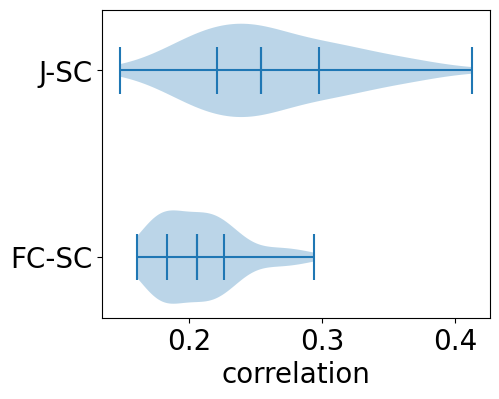

WilcoxonResult(statistic=np.float64(2331.0), pvalue=np.float64(9.25319592080014e-12))


In [218]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
corr_labels = ['J-SC', 'FC-SC']
label_x = range( 1, len(corr_labels)+1 )
J_sc_corr_np = depytorch(sig_both_J_sc_corr)
fc_sc_corr_np = depytorch(sig_both_fc_sc_corr)
all_corrs = [J_sc_corr_np, fc_sc_corr_np]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
plt.show()
test_result = stats.wilcoxon(x=J_sc_corr_np, y=fc_sc_corr_np, alternative='greater')
print( test_result )

In [219]:
is_greater = (sig_both_J_sc_corr - sig_both_fc_sc_corr) > 0
num_greater = torch.count_nonzero(is_greater)
num_pairs = is_greater.numel()
print(f'{num_greater} of {num_pairs} ({num_greater/num_pairs:.3g}) pairs where both correlations are significant have greater J-SC correlations than FC-SC correlations.')

60 of 69 (0.87) pairs where both correlations are significant have greater J-SC correlations than FC-SC correlations.


In [221]:
print( torch.abs(fc_sc_corr_old - fc_sc_corr).max().item() )

0.11093835532665253


In [222]:
print( torch.abs(J_sc_corr_old - J_sc_corr).max().item() )

0.14444434642791748


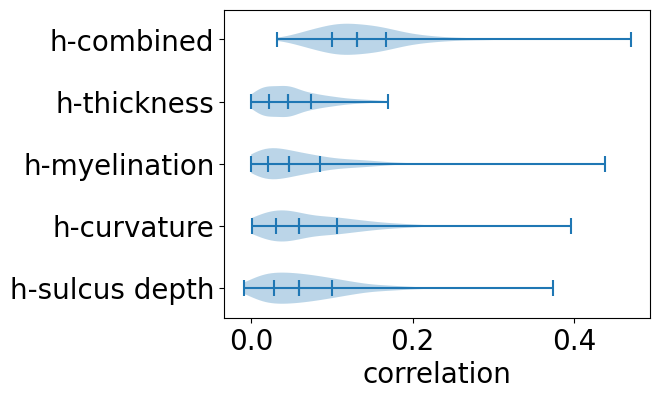

In [106]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5.5, 4) )
corr_labels = ['h-combined'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(local_h_pred_corr)] + [depytorch(single_feature_local_h_pred_corr[:,feature_index]) for feature_index in range( single_feature_local_h_pred_corr.size(dim=-1) )]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# all_max_crit_corrs = [cc.item() for cc in max_h_node_feature_crit_corr_tensor] + [fc_sc_crit_corr_max, fc_sc_crit_corr_max]
# axs.scatter(  list( reversed(all_max_crit_corrs) ), label_x, color='red', marker='|', linewidth=2, s=80  )
# axs.scatter(  list( reversed([-cc for cc in all_max_crit_corrs]) ), label_x, color='red', marker='|', linewidth=2, s=80  )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
plt.show()

In [107]:
local_h_pred_corr_np = depytorch(local_h_pred_corr)
num_nodes = local_h_pred_corr.numel()
for feature_index in range( len(feature_names) ):
    feature_local_h_pred_corr = single_feature_local_h_pred_corr[:,feature_index]
    num_greater = torch.count_nonzero(local_h_pred_corr > feature_local_h_pred_corr)
    test_result = stats.wilcoxon( x=local_h_pred_corr_np, y=depytorch(feature_local_h_pred_corr), alternative='greater' )
    print( feature_names[feature_index], test_result, f'{num_greater} of {num_nodes} ({num_greater/num_nodes:.3g}) combined correlations greater' )

thickness WilcoxonResult(statistic=np.float64(64980.0), pvalue=np.float64(4.7017897367405964e-61)) 360 of 360 (1) combined correlations greater
myelination WilcoxonResult(statistic=np.float64(64980.0), pvalue=np.float64(4.7017897367405964e-61)) 360 of 360 (1) combined correlations greater
curvature WilcoxonResult(statistic=np.float64(64980.0), pvalue=np.float64(4.7017897367405964e-61)) 360 of 360 (1) combined correlations greater
sulcus depth WilcoxonResult(statistic=np.float64(64980.0), pvalue=np.float64(4.7017897367405964e-61)) 360 of 360 (1) combined correlations greater


In [161]:
p_values = torch.load( f=os.path.join(file_dir, f'p_values_node_features_to_h_1_{param_string}'), weights_only=False )
print( p_values.size() )

torch.Size([360])


In [162]:
local_h_pred_corr = torch.load( f=os.path.join(file_dir, f'h_pred_corr_node_features_to_h_1_{param_string}'), weights_only=False )

In [163]:
alpha = 0.05/p_values.numel()
print( torch.count_nonzero(p_values < alpha) )

tensor(92, device='cuda:0')


In [133]:
region_names, region_coords = hcp.load_roi_info( directory_path='D:\\HCP_data', dtype=float_type, device=device )
print( region_coords.size() )

torch.Size([360, 3])


In [215]:
linear_model_corr_file_name = os.path.join(file_dir, f'linear_model_h_corr.dlm')
write_node_file(file_name=linear_model_corr_file_name, coords=region_coords, values_for_color=local_h_pred_corr, values_for_size=p_values, names=region_names)
print(f'saved {linear_model_corr_file_name}')

saved E:\Ising_model_results_daai\linear_model_h_corr.dlm


In [222]:
print(  ( torch.nonzero(local_h_pred_corr >= 0.24).flatten()+1 ).tolist()  )

[7, 11, 12, 18, 22, 79, 80, 90, 138, 140, 141, 157, 187, 191, 198, 202, 209, 228, 260, 268, 318, 320, 337]


predicted v. true h corr.=0.00259z(thickness)+0.141, R^2=0.00171
predicted v. true h corr. v. thickness corr.=0.0413, p-value=0.447
predicted v. true h corr.=0.00119z(myelination)+0.141, R^2=0.000361
predicted v. true h corr. v. myelination corr.=0.019, p-value=0.742
predicted v. true h corr.=-0.00133z(curvature)+0.141, R^2=0.00045
predicted v. true h corr. v. curvature corr.=-0.0212, p-value=0.7
predicted v. true h corr.=-0.000301z(sulcus depth)+0.141, R^2=2.29e-05
predicted v. true h corr. v. sulcus depth corr.=-0.00479, p-value=0.935


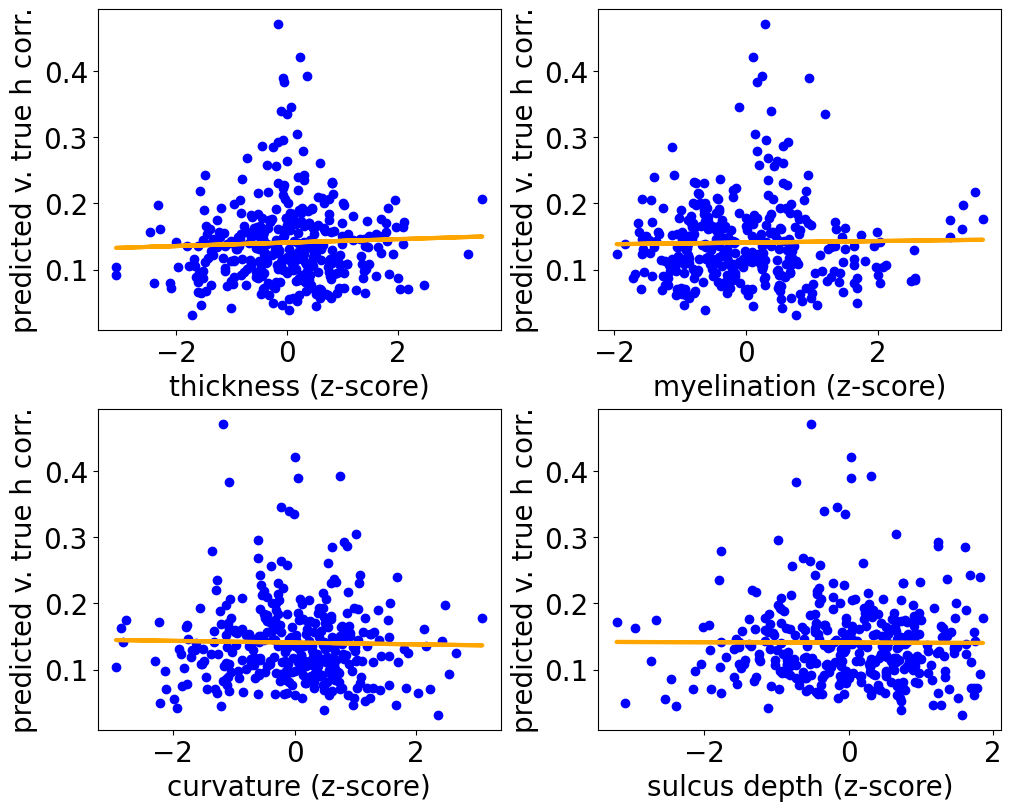

In [181]:
feature_names_file = ['thickness', 'myelination', 'curvature', 'sulcus depth']
num_features = len(feature_names_file)
selected_corrs = local_h_pred_corr
selected_corr_name = f'predicted v. true h corr.'
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(10, 8), layout='constrained' )
row_indices = [0, 0, 1, 1]
col_indices = [0, 1, 0, 1]
for feature_index in range(num_features):
    selected_features = mean_node_features[:,feature_index]
    selected_feature_name = feature_names_file[feature_index]
    r = row_indices[feature_index]
    c = col_indices[feature_index]
    make_scatter_plot_with_regression_line(ax=axs[r,c], feature=selected_features, param=selected_corrs, feature_name=selected_feature_name, param_name=selected_corr_name)
    get_correlation_and_p(feature=selected_features, param=selected_corrs, feature_name=selected_feature_name, param_name=selected_corr_name, num_perms=1000)
# plt.tight_layout()
plt.show()

predicted v. true h corr.=0.147SD(thickness)+0.115, R^2=0.0106
predicted v. true h corr. v. SD(thickness) corr.=0.103, p-value=0.052
predicted v. true h corr.=0.125SD(myelination)+0.137, R^2=0.00374
predicted v. true h corr. v. SD(myelination) corr.=0.0609, p-value=0.23
predicted v. true h corr.=1.14SD(curvature)+0.0965, R^2=0.0813
predicted v. true h corr. v. SD(curvature) corr.=0.284, p-value=0
predicted v. true h corr.=0.239SD(sulcus depth)+0.0982, R^2=0.0845
predicted v. true h corr. v. SD(sulcus depth) corr.=0.29, p-value=0


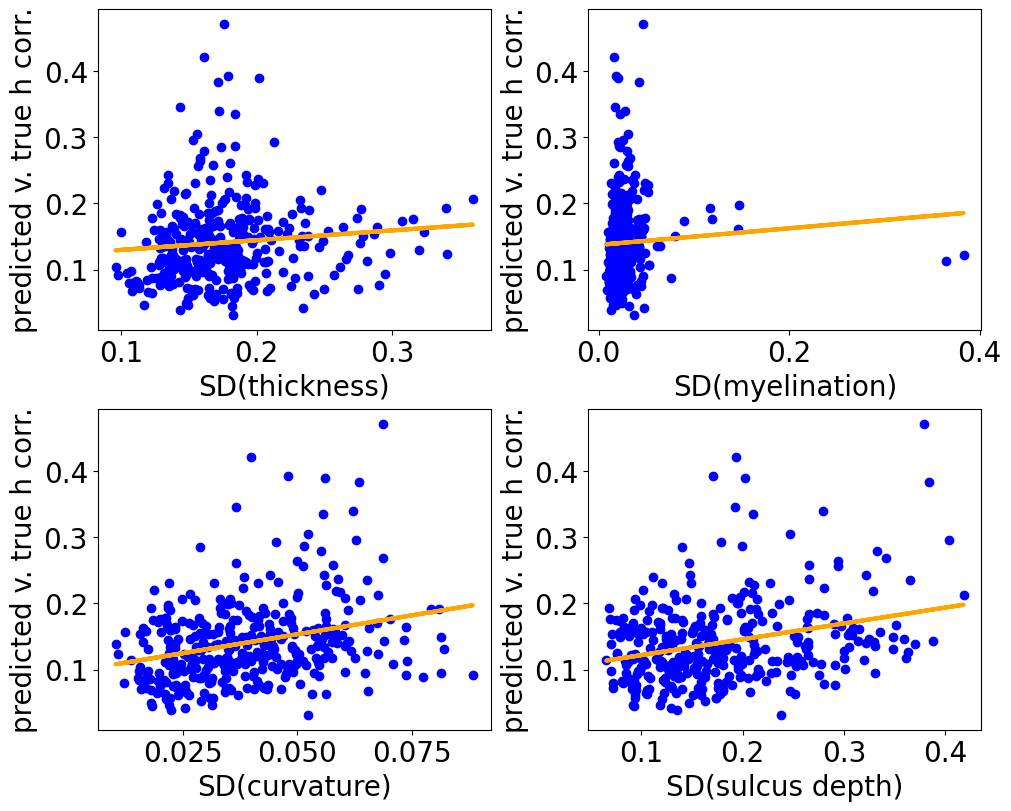

In [182]:
feature_names_file = ['thickness', 'myelination', 'curvature', 'sulcus depth']
num_features = len(feature_names_file)
selected_corrs = local_h_pred_corr
selected_corr_name = f'predicted v. true h corr.'
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(10, 8), layout='constrained' )
row_indices = [0, 0, 1, 1]
col_indices = [0, 1, 0, 1]
for feature_index in range(num_features):
    selected_features = std_node_features[:,feature_index]
    selected_feature_name = f'SD({feature_names_file[feature_index]})'
    r = row_indices[feature_index]
    c = col_indices[feature_index]
    make_scatter_plot_with_regression_line_no_z(ax=axs[r,c], feature=selected_features, param=selected_corrs, feature_name=selected_feature_name, param_name=selected_corr_name)
    get_correlation_and_p(feature=selected_features, param=selected_corrs, feature_name=selected_feature_name, param_name=selected_corr_name, num_perms=1000)
# plt.tight_layout()
plt.show()

predicted v. true h corr.=-0.0609|thickness - mean|+0.155, R^2=0.0332
predicted v. true h corr. v. |thickness - mean| corr.=-0.182, p-value=0
predicted v. true h corr.=-0.0896|myelination - mean|+0.149, R^2=0.0107
predicted v. true h corr. v. |myelination - mean| corr.=-0.103, p-value=0.046
predicted v. true h corr.=-0.239|curvature - mean|+0.15, R^2=0.0118
predicted v. true h corr. v. |curvature - mean| corr.=-0.108, p-value=0.037
predicted v. true h corr.=-0.0328|sulcus depth - mean|+0.15, R^2=0.0118
predicted v. true h corr. v. |sulcus depth - mean| corr.=-0.108, p-value=0.036


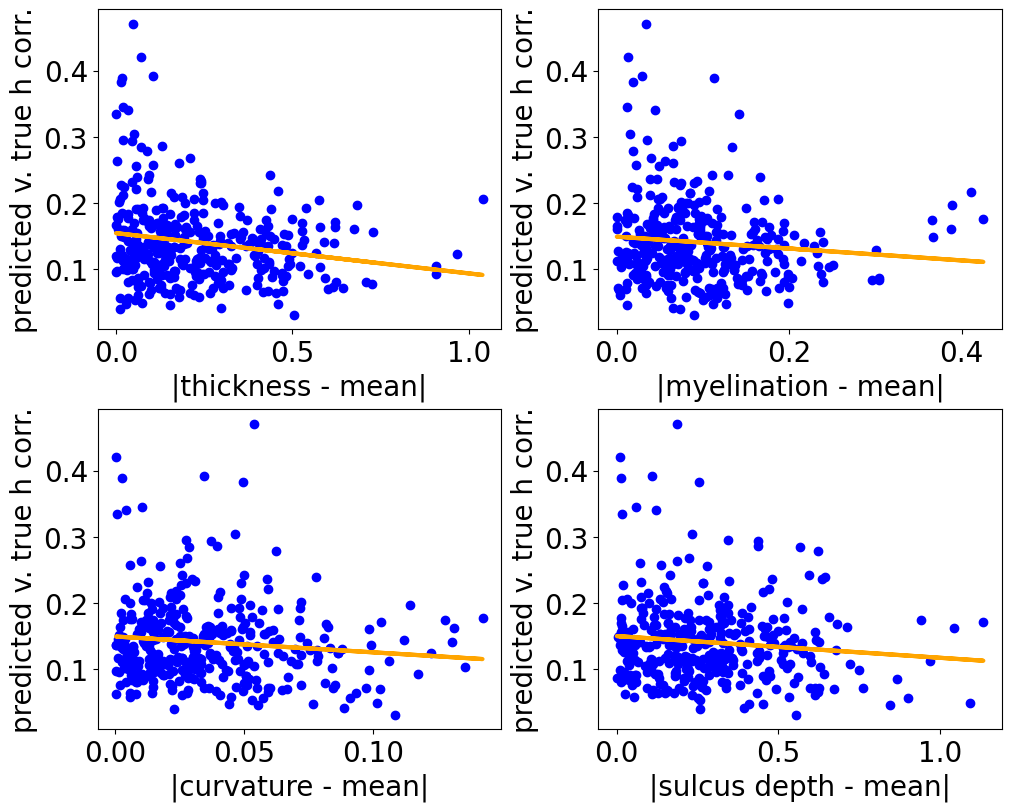

In [183]:
feature_names_file = ['thickness', 'myelination', 'curvature', 'sulcus depth']
num_features = len(feature_names_file)
selected_corrs = local_h_pred_corr
selected_corr_name = f'predicted v. true h corr.'
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(10, 8), layout='constrained' )
row_indices = [0, 0, 1, 1]
col_indices = [0, 1, 0, 1]
for feature_index in range(num_features):
    selected_features = mean_node_features[:,feature_index]
    selected_features_diff_from_mean = torch.abs( selected_features - selected_features.mean() )
    selected_feature_name = f'|{feature_names_file[feature_index]} - mean|'
    r = row_indices[feature_index]
    c = col_indices[feature_index]
    make_scatter_plot_with_regression_line_no_z(ax=axs[r,c], feature=selected_features_diff_from_mean, param=selected_corrs, feature_name=selected_feature_name, param_name=selected_corr_name)
    get_correlation_and_p(feature=selected_features_diff_from_mean, param=selected_corrs, feature_name=selected_feature_name, param_name=selected_corr_name, num_perms=1000)
# plt.tight_layout()
plt.show()

In [90]:
node_features_test = torch.load( os.path.join(other_file_dir, 'node_features_all_as_is.pt'), weights_only=False )[training_subject_end:,:,:4]
print( 'node features size', node_features_test.size() )
std_node_features_test, mean_node_features_test = torch.std_mean(node_features_test, dim=0)
print( 'mean node features size', mean_node_features_test.size() )
sc_test = torch.load( os.path.join(other_file_dir, 'edge_features_all_as_is.pt'), weights_only=False )[training_subject_end:,:,0]
print( 'SC size', sc_test.size() )
std_sc_test, mean_sc_test = torch.std_mean(sc_test, dim=0)
print( 'mean SC size', mean_sc_test.size() )

node features size torch.Size([167, 360, 4])
mean node features size torch.Size([360, 4])
SC size torch.Size([167, 64620])
mean SC size torch.Size([64620])


In [96]:
def load_mean_params_test(param_string:str):
    model_file = os.path.join( other_file_dir, f'ising_model_light_{param_string}.pt' )
    model = torch.load(model_file, weights_only=False)
    num_nodes = model.J.size(dim=-1)
    triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=num_nodes, device=model.J.device )
    return model.h[:,training_subject_end:,:].mean(dim=0), model.J[:,training_subject_end:,triu_rows,triu_cols].mean(dim=0)
h_test, J_test = load_mean_params_test(param_string=param_string)
print( 'h size', h_test.size() )
print( 'J size', J_test.size() )

h size torch.Size([167, 360])
J size torch.Size([167, 64620])


In [97]:
def get_data_fc_triu_test(data_string:str):
    mean_state = torch.load( os.path.join(other_file_dir, f'mean_state_{data_string}.pt'), weights_only=False )[:,training_subject_end:,:].mean(dim=0)
    print( 'mean state size', mean_state.size() )
    mean_state_product = torch.load( os.path.join(other_file_dir, f'mean_state_product_{data_string}.pt'), weights_only=False )[:,training_subject_end:,:,:].mean(dim=0)
    print( 'mean state product size', mean_state_product.size() )
    fc = isingmodellight.get_fc(state_mean=mean_state, state_product_mean=mean_state_product, epsilon=0)
    print( 'fc size', fc.size() )
    triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=mean_state.size(dim=-1), device=mean_state.device )
    return fc[:,triu_rows,triu_cols]
fc_test = get_data_fc_triu_test(data_string=data_string)
print( 'triu fc size', fc_test.size() )

mean state size torch.Size([167, 360])
mean state product size torch.Size([167, 360, 360])
fc size torch.Size([167, 360, 360])
triu fc size torch.Size([167, 64620])


In [98]:
local_coeffs = torch.load( f=os.path.join(file_dir, f'coeffs_node_features_to_h_1_{param_string}'), weights_only=False )
print( local_coeffs.size() )

torch.Size([360, 5, 1])


In [100]:
h_for_lstsq = h.transpose(dim0=0, dim1=1).unsqueeze(dim=-1)
node_features_for_lstsq = torch.cat(  ( node_features.transpose(dim0=0, dim1=1), torch.ones_like(h_for_lstsq) ), dim=-1  )
# local_regressions = torch.linalg.lstsq(node_features_for_lstsq, h_for_lstsq)
# print( local_regressions )
# local_coeffs = local_regressions.solution
print( local_coeffs.size() )
h_pred_for_lstsq = torch.matmul(node_features_for_lstsq, local_coeffs)
print( h_pred_for_lstsq.size() )
local_h_pred_corr = isingmodellight.get_pairwise_correlation( mat1=h_for_lstsq, mat2=h_pred_for_lstsq, epsilon=0, dim=1 ).squeeze(dim=-1)
print( 'correlation size', local_h_pred_corr.size(), 'min', local_h_pred_corr.min().item(), 'mean', local_h_pred_corr.mean().item(), 'max', local_h_pred_corr.max().item() )

torch.Size([360, 5, 1])
torch.Size([360, 670, 1])
correlation size torch.Size([360]) min 0.024479204788804054 mean 0.13719762861728668 max 0.470639169216156


In [99]:
h_for_lstsq_test = h_test.transpose(dim0=0, dim1=1).unsqueeze(dim=-1)
node_features_for_lstsq_test = torch.cat(  ( node_features_test.transpose(dim0=0, dim1=1), torch.ones_like(h_for_lstsq_test) ), dim=-1  )
# local_regressions = torch.linalg.lstsq(node_features_for_lstsq, h_for_lstsq)
# print( local_regressions )
# local_coeffs = local_regressions.solution
print( local_coeffs.size() )
h_pred_for_lstsq_test = torch.matmul(node_features_for_lstsq_test, local_coeffs)
print( h_pred_for_lstsq_test.size() )
local_h_pred_corr_test = isingmodellight.get_pairwise_correlation( mat1=h_for_lstsq_test, mat2=h_pred_for_lstsq_test, epsilon=0, dim=1 ).squeeze(dim=-1)
print( 'correlation size', local_h_pred_corr_test.size(), 'min', local_h_pred_corr_test.min().item(), 'mean', local_h_pred_corr_test.mean().item(), 'max', local_h_pred_corr_test.max().item() )

torch.Size([360, 5, 1])
torch.Size([360, 167, 1])
correlation size torch.Size([360]) min -0.07737921178340912 mean 0.13854242861270905 max 0.5427932143211365


In [115]:
local_h_pred_rmse = isingmodellight.get_pairwise_rmse( mat1=h_for_lstsq, mat2=h_pred_for_lstsq, dim=1 ).squeeze(dim=-1)
print( 'training RMSE size', local_h_pred_rmse.size(), 'min', local_h_pred_rmse.min().item(), 'mean', local_h_pred_rmse.mean().item(), 'max', local_h_pred_rmse.max().item() )
local_h_pred_rmse_test = isingmodellight.get_pairwise_rmse( mat1=h_for_lstsq_test, mat2=h_pred_for_lstsq_test, dim=1 ).squeeze(dim=-1)
print( 'test RMSE size', local_h_pred_rmse_test.size(), 'min', local_h_pred_rmse_test.min().item(), 'mean', local_h_pred_rmse_test.mean().item(), 'max', local_h_pred_rmse_test.max().item() )

training RMSE size torch.Size([360]) min 3.3364391326904297 mean 5.074653148651123 max 8.642990112304688
test RMSE size torch.Size([360]) min 3.1097211837768555 mean 4.9554033279418945 max 7.7198896408081055


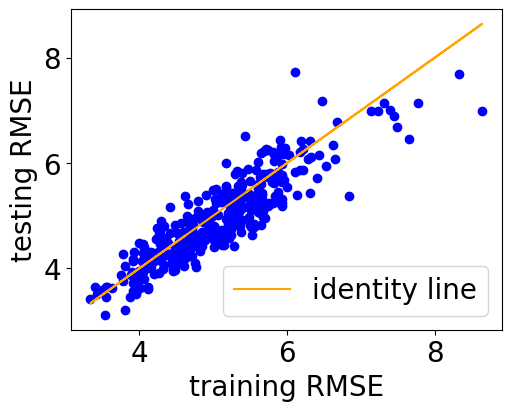

In [117]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )
axs.scatter( depytorch(local_h_pred_rmse), depytorch(local_h_pred_rmse_test), color='blue' )
identity_ones = depytorch(local_h_pred_rmse)
axs.plot( identity_ones, identity_ones, color='orange', label='identity line' )
axs.set_xlabel('training RMSE')
axs.set_ylabel('testing RMSE')
axs.legend()

In [118]:
is_overfit = local_h_pred_rmse < local_h_pred_rmse_test
num_overfit = torch.count_nonzero(is_overfit)
num_nodes = torch.numel(is_overfit)
fraction_overfit = num_overfit/num_nodes
print(f'{num_overfit} out of {num_nodes} ({fraction_overfit:.3g}) regions have worse testing RMSE than training RMSE')

136 out of 360 (0.378) regions have worse testing RMSE than training RMSE


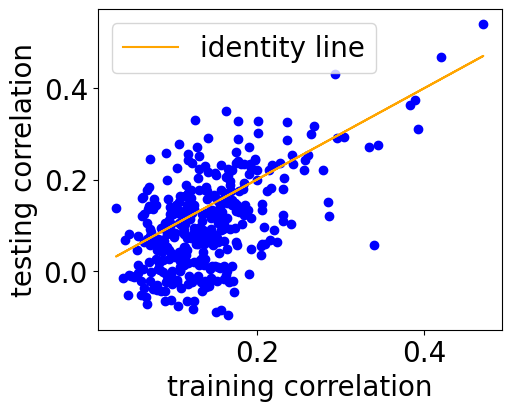

In [126]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )
axs.scatter( depytorch(local_h_pred_corr), depytorch(local_h_pred_corr_test), color='blue' )
identity_ones = depytorch(local_h_pred_corr)
axs.plot( identity_ones, identity_ones, color='orange', label='identity line' )
axs.set_xlabel('training correlation')
axs.set_ylabel('testing correlation')
axs.legend()

In [128]:
is_overfit = local_h_pred_corr > local_h_pred_corr_test
num_overfit = torch.count_nonzero(is_overfit)
num_nodes = torch.numel(is_overfit)
fraction_overfit = num_overfit/num_nodes
print(f'{num_overfit} out of {num_nodes} ({fraction_overfit:.3g}) regions have worse testing correlation than training correlation.')

237 out of 360 (0.658) regions have worse testing correlation than training correlation.


J-SC corr.=0.00957SD(J)+-0.0365, R^2=0.0386
J-SC corr. v. SD(J) corr.=0.196, p-value=0


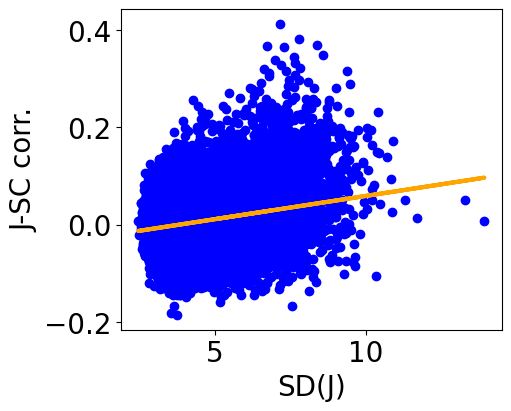

In [130]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )

make_scatter_plot_with_regression_line_no_z(ax=axs, feature=J_std, param=J_sc_corr, feature_name='SD(J)', param_name='J-SC corr.')
get_correlation_and_p(feature=J_std, param=J_sc_corr, feature_name='SD(J)', param_name='J-SC corr.', num_perms=1000)

# plt.tight_layout()
plt.show()

linear model h corr.=0.0124SD(h)+0.0773, R^2=0.0277
linear model h corr. v. SD(h) corr.=0.166, p-value=0.001


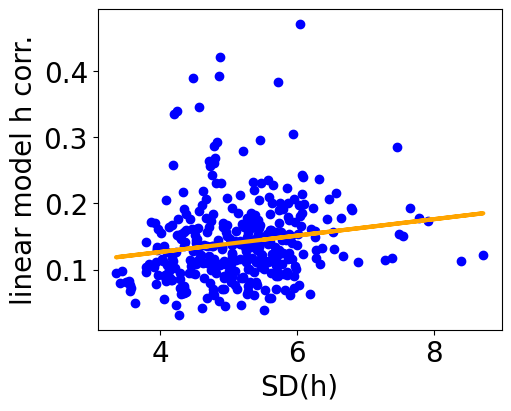

In [134]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )

make_scatter_plot_with_regression_line_no_z(ax=axs, feature=h_std, param=local_h_pred_corr, feature_name='SD(h)', param_name='linear model h corr.')
get_correlation_and_p(feature=h_std, param=local_h_pred_corr, feature_name='SD(h)', param_name='linear model h corr.', num_perms=1000)

# plt.tight_layout()
plt.show()

linear model h RMSE=0.979SD(h)+0.0404, R^2=0.993
linear model h RMSE v. SD(h) corr.=0.994, p-value=0


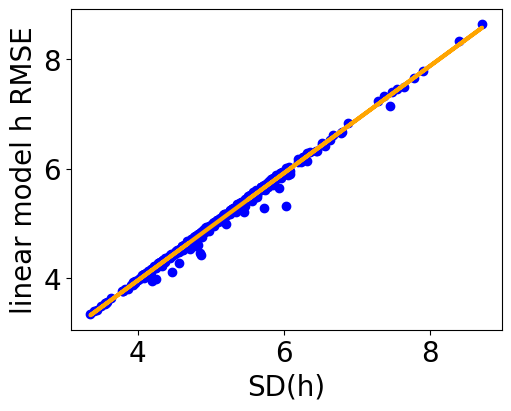

In [135]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )

make_scatter_plot_with_regression_line_no_z(ax=axs, feature=h_std, param=local_h_pred_rmse, feature_name='SD(h)', param_name='linear model h RMSE')
get_correlation_and_p(feature=h_std, param=local_h_pred_rmse, feature_name='SD(h)', param_name='linear model h RMSE', num_perms=1000)

# plt.tight_layout()
plt.show()

In [137]:
J_sc_cov = torch.mean(J * sc, dim=0) - torch.mean(J, dim=0) * torch.mean(sc, dim=0)
print( J_sc_cov.size() )

torch.Size([64620])


J-SC covariance=0.000846SD(J)+-0.00334, R^2=0.0936
J-SC covariance v. SD(J) corr.=0.306, p-value=0


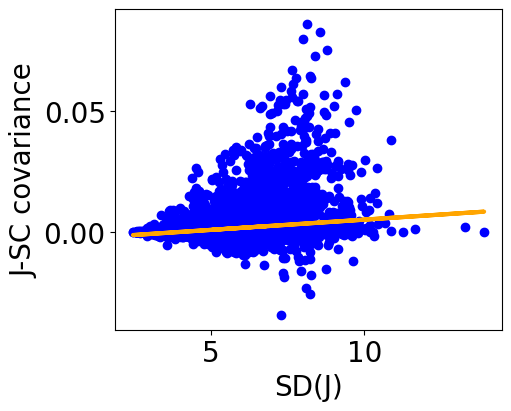

In [138]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )

make_scatter_plot_with_regression_line_no_z(ax=axs, feature=J_std, param=J_sc_cov, feature_name='SD(J)', param_name='J-SC covariance')
get_correlation_and_p(feature=J_std, param=J_sc_cov, feature_name='SD(J)', param_name='J-SC covariance', num_perms=1000)

# plt.tight_layout()
plt.show()

In [141]:
print( J_pred_for_lstsq.size() )
local_J_pred_rmse = isingmodellight.get_pairwise_rmse( mat1=J_for_lstsq, mat2=J_pred_for_lstsq, dim=1 ).squeeze(dim=-1)
print( 'J(SC) training RMSE size', local_J_pred_rmse.size(), 'min', local_J_pred_rmse.min().item(), 'mean', local_J_pred_rmse.mean().item(), 'max', local_J_pred_rmse.max().item() )

torch.Size([64620, 670, 1])
J(SC) training RMSE size torch.Size([64620]) min 2.4603419303894043 mean 4.259800434112549 max 13.89647388458252


linear model J RMSE=0.994SD(J)+0.019, R^2=1
linear model J RMSE v. SD(J) corr.=1, p-value=0


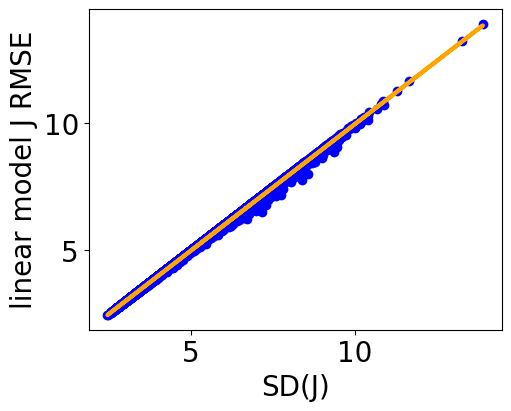

In [142]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )

make_scatter_plot_with_regression_line_no_z(ax=axs, feature=J_std, param=local_J_pred_rmse, feature_name='SD(J)', param_name='linear model J RMSE')
get_correlation_and_p(feature=J_std, param=local_J_pred_rmse, feature_name='SD(J)', param_name='linear model J RMSE', num_perms=1000)

# plt.tight_layout()
plt.show()

In [143]:
h_std_test, h_mean_test = torch.std_mean(h_test, dim=0)
print( h_std_test.size() )

torch.Size([360])


linear model h RMSE=0.981test data SD(h)+0.0698, R^2=0.984
test data linear model h RMSE v. SD(h) corr.=0.989, p-value=0


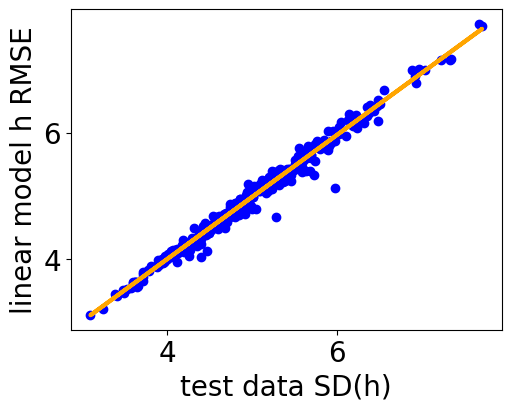

In [144]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )

make_scatter_plot_with_regression_line_no_z(ax=axs, feature=h_std_test, param=local_h_pred_rmse_test, feature_name='test data SD(h)', param_name='linear model h RMSE')
get_correlation_and_p(feature=h_std_test, param=local_h_pred_rmse_test, feature_name='SD(h)', param_name='test data linear model h RMSE', num_perms=1000)

# plt.tight_layout()
plt.show()

In [156]:
h_std_pred, h_mean_pred = torch.std_mean( h_pred_for_lstsq.squeeze(dim=-1), dim=-1 )
print( h_std_pred.size() )

torch.Size([360])


linear model h RMSE=0.922SD(predicted h)+4.4, R^2=0.163
linear model h RMSE v. SD(predicted h) corr.=0.403, p-value=0


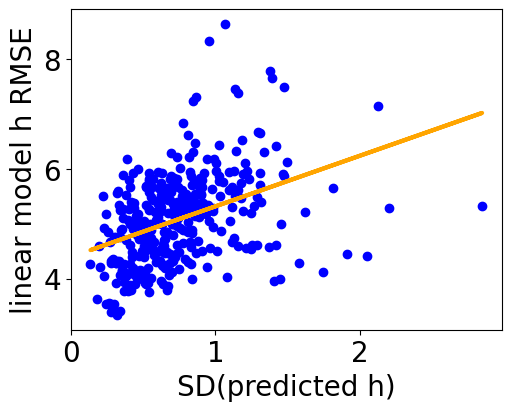

In [147]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )

make_scatter_plot_with_regression_line_no_z(ax=axs, feature=h_std_pred, param=local_h_pred_rmse, feature_name='SD(predicted h)', param_name='linear model h RMSE')
get_correlation_and_p(feature=h_std_pred, param=local_h_pred_rmse, feature_name='SD(predicted h)', param_name='linear model h RMSE', num_perms=1000)

# plt.tight_layout()
plt.show()

In [189]:
h_correlation_results_v1 = torch.load( os.path.join(file_dir, 'all_features_h_linear_model_ising_model_light_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000.pt'), weights_only=False )
print( len(h_correlation_results_v1) )

6


In [190]:
 all_features_h_coeffs_v1 = h_correlation_results_v1[0]
 all_features_h_dependent_prediction_v1 = h_correlation_results_v1[1]
 all_features_h_r_squared_v1 = h_correlation_results_v1[2]
 all_features_h_pred_corr_v1 = h_correlation_results_v1[3]
 all_features_h_p_r_squared_v1 = h_correlation_results_v1[4]
 all_features_h_p_pred_corr_v1 = h_correlation_results_v1[5]

In [157]:
h_correlation_results_v2 = torch.load( os.path.join(file_dir, 'all_features_h_linear_model_ising_model_light_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000.pt'), weights_only=False )
print( len(h_correlation_results_v2) )

6


In [158]:
 all_features_h_coeffs = h_correlation_results_v2[0]
 all_features_h_dependent_prediction = h_correlation_results_v2[1]
 all_features_h_r_squared = h_correlation_results_v2[2]
 all_features_h_pred_corr = h_correlation_results_v2[3]
 all_features_h_p_r_squared = h_correlation_results_v2[4]
 all_features_h_p_pred_corr = h_correlation_results_v2[5]

In [159]:
print( 'all_features_h_p_pred_corr size', all_features_h_p_pred_corr.size(), f'min {all_features_h_p_pred_corr.min()} mean {all_features_h_p_pred_corr.mean():.3g} max {all_features_h_p_pred_corr.max():.3g}' )

all_features_h_p_pred_corr size torch.Size([360]) min 0.0 mean 0.0945 max 0.925


In [160]:
alpha = 0.05/all_features_h_p_pred_corr.numel()
all_features_h_pred_cor_is_sig = all_features_h_p_pred_corr < alpha
all_features_h_pred_cor_num_sig = torch.count_nonzero(all_features_h_pred_cor_is_sig)
print(all_features_h_pred_cor_num_sig)

tensor(118, device='cuda:0')


In [191]:
print( 'all_features_h_p_pred_corr_v1 size', all_features_h_p_pred_corr_v1.size(), f'min {all_features_h_p_pred_corr_v1.min()} mean {all_features_h_p_pred_corr_v1.mean():.3g} max {all_features_h_p_pred_corr_v1.max():.3g}' )

all_features_h_p_pred_corr_v1 size torch.Size([360]) min 0.0 mean 0.0945 max 0.925


In [188]:
all_features_h_p_pred_corr_old = torch.load( f=os.path.join(file_dir, f'p_values_node_features_to_h_1_{param_string}'), weights_only=False )
print( 'all_features_h_p_pred_corr_old size', all_features_h_p_pred_corr_old.size(), f'min {all_features_h_p_pred_corr_old.min()} mean {all_features_h_p_pred_corr_old.mean():.3g} max {all_features_h_p_pred_corr_old.max():.3g}' )

all_features_h_p_pred_corr_old size torch.Size([360]) min 0.0 mean 0.0942 max 0.917


In [184]:
num_nodes = all_features_h_p_pred_corr.numel()
alpha_nodes = 0.05/num_nodes
is_sig_nodes = all_features_h_p_pred_corr < alpha_nodes
num_sig_nodes = torch.count_nonzero(is_sig_nodes)
fraction_sig_nodes = num_sig_nodes/num_nodes
print(f'{num_sig_nodes} of {num_nodes} ({fraction_sig_nodes:.3g}) have h-h pred correlation p < {alpha_nodes:.3g}.')

63 of 360 (0.175) have h-h pred correlation p < 0.000139.


In [153]:
print( 'all_features_h_pred_corr size', all_features_h_pred_corr.size(), f'min {all_features_h_pred_corr.min()} mean {all_features_h_pred_corr.mean():.3g} max {all_features_h_pred_corr.max():.3g}' )

all_features_h_pred_corr size torch.Size([360]) min 0.03156427666544914 mean 0.141 max 0.471


In [154]:
print( 'local_h_pred_corr size', local_h_pred_corr.size(), f'min {local_h_pred_corr.min()} mean {local_h_pred_corr.mean():.3g} max {local_h_pred_corr.max():.3g}' )

local_h_pred_corr size torch.Size([360]) min 0.03156592324376106 mean 0.141 max 0.471


In [185]:
h_pred_corr_error = torch.abs(local_h_pred_corr - all_features_h_pred_corr)
print( h_pred_corr_error.max().item() )

8.784234523773193e-06


J=119SC+0.694, R^2=0.0982
J v. SC corr.=0.313, p-value=0


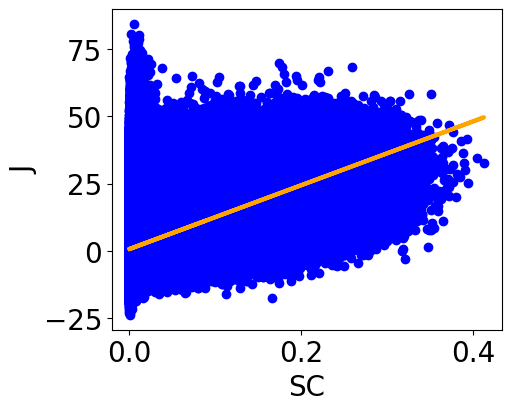

In [155]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )

make_scatter_plot_with_regression_line_no_z( ax=axs, feature=sc.flatten(), param=J.flatten(), feature_name='SC', param_name='J' )
get_correlation_and_p( feature=sc.flatten(), param=J.flatten(), feature_name='SC', param_name='J', num_perms=1000 )

# plt.tight_layout()
plt.show()

predicted h=0.354true h+-2.96, R^2=0.354
predicted h v. true h corr.=0.595, p-value=0


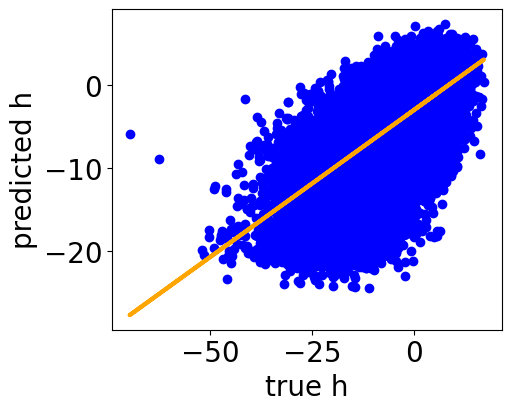

In [157]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )

make_scatter_plot_with_regression_line_no_z( ax=axs, feature=h_for_lstsq.flatten(), param=h_pred_for_lstsq.flatten(), feature_name='true h', param_name='predicted h' )
get_correlation_and_p( feature=h_for_lstsq.flatten(), param=h_pred_for_lstsq.flatten(), feature_name='true h', param_name='predicted h', num_perms=1000 )

# plt.tight_layout()
plt.show()

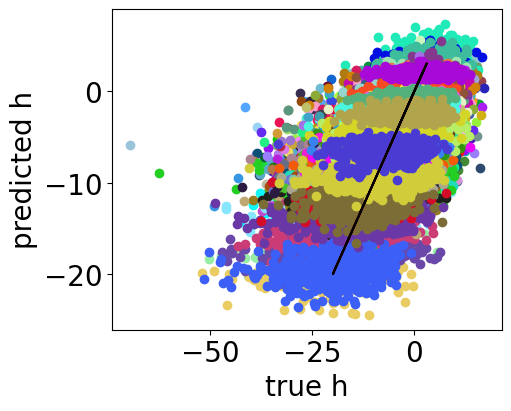

In [173]:
# selected_node = torch.argmin(local_h_pred_corr)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )
num_nodes = h_for_lstsq.size(dim=0)
colors=torch.rand( size=(num_nodes,3), dtype=float_type, device=device )
h_2d = depytorch( h_for_lstsq.squeeze(dim=-1) )
h_pred_2d = depytorch( h_pred_for_lstsq.squeeze(dim=-1) )
for node_index in range(num_nodes):
    axs.scatter( h_2d[node_index,:], h_pred_2d[node_index,:], color=colors[node_index,:].tolist() )
mean_true_h = depytorch(  h_for_lstsq.mean( dim=(1,2) )  )
axs.plot(   mean_true_h, depytorch(  h_pred_for_lstsq.mean( dim=(1,2) )  ), color='red'   )
axs.plot(   mean_true_h, mean_true_h, color='black'   )
axs.set_xlabel(f'true h')
axs.set_ylabel(f'predicted h')
plt.show()

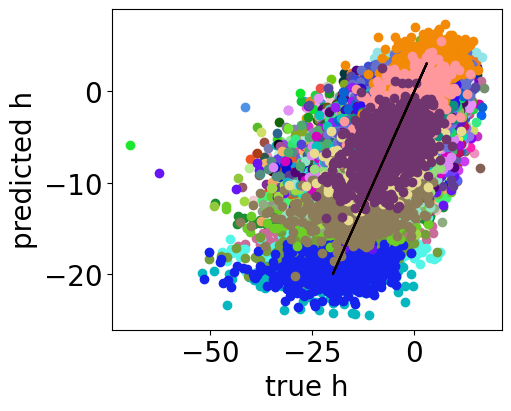

In [179]:
# selected_node = torch.argmin(local_h_pred_corr)
sorted_h_pred_corr, node_order = torch.sort(local_h_pred_corr)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )
num_nodes = h_for_lstsq.size(dim=0)
colors=torch.rand( size=(num_nodes,3), dtype=float_type, device=device )
h_2d = depytorch( h_for_lstsq.squeeze(dim=-1) )
h_pred_2d = depytorch( h_pred_for_lstsq.squeeze(dim=-1) )
for node_index in node_order:
    current_corr_2 = 2*local_h_pred_corr[node_index].item()
    axs.scatter( h_2d[node_index,:], h_pred_2d[node_index,:], color=colors[node_index,:].tolist() )
mean_true_h = depytorch(  h_for_lstsq.mean( dim=(1,2) )  )
axs.plot(   mean_true_h, depytorch(  h_pred_for_lstsq.mean( dim=(1,2) )  ), color='red'   )
axs.plot(   mean_true_h, mean_true_h, color='black'   )
axs.set_xlabel(f'true h')
axs.set_ylabel(f'predicted h')
plt.show()

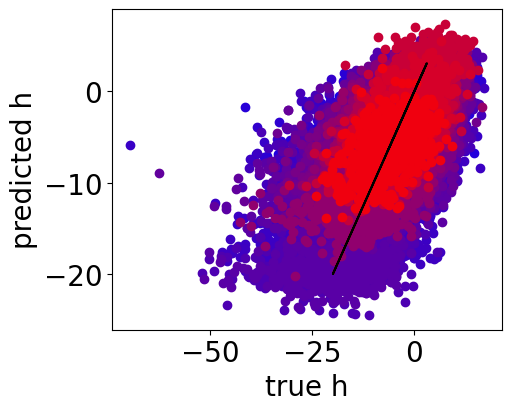

In [178]:
# selected_node = torch.argmin(local_h_pred_corr)
sorted_h_pred_corr, node_order = torch.sort(local_h_pred_corr)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4), layout='constrained' )
num_nodes = h_for_lstsq.size(dim=0)
# colors=torch.rand( size=(num_nodes,3), dtype=float_type, device=device )
h_2d = depytorch( h_for_lstsq.squeeze(dim=-1) )
h_pred_2d = depytorch( h_pred_for_lstsq.squeeze(dim=-1) )
for node_index in node_order:
    current_corr_2 = 2*local_h_pred_corr[node_index].item()
    axs.scatter( h_2d[node_index,:], h_pred_2d[node_index,:], color=[current_corr_2, 0, 1-current_corr_2] )
mean_true_h = depytorch(  h_for_lstsq.mean( dim=(1,2) )  )
axs.plot(   mean_true_h, depytorch(  h_pred_for_lstsq.mean( dim=(1,2) )  ), color='red'   )
axs.plot(   mean_true_h, mean_true_h, color='black'   )
axs.set_xlabel(f'true h')
axs.set_ylabel(f'predicted h')
plt.show()

In [175]:
print( local_h_pred_corr.max().item() )

0.4708344340324402


In [153]:
single_feature_h_corr_results_new = torch.load( os.path.join(file_dir, 'one_feature_h_linear_model_ising_model_light_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000.pt'), weights_only=False )
print( len(single_feature_h_corr_results_new) )

8


In [154]:
single_feature_h_coeffs = single_feature_h_corr_results_new[0]
single_feature_h_predictions = single_feature_h_corr_results_new[1]
single_feature_h_p_r_squared = single_feature_h_corr_results_new[2]
single_feature_h_pred_corr = single_feature_h_corr_results_new[3]
single_feature_h_p_r_squared = single_feature_h_corr_results_new[4]
single_feature_h_p_pred_corr = single_feature_h_corr_results_new[5]
single_feature_h_corr = single_feature_h_corr_results_new[6]
single_feature_h_p_corr = single_feature_h_corr_results_new[7]

In [155]:
print( 'single_feature_h_corr size', single_feature_h_corr.size() )
print( 'single_feature_h_p_corr size', single_feature_h_p_corr.size() )

single_feature_h_corr size torch.Size([360, 4])
single_feature_h_p_corr size torch.Size([360, 4])


In [156]:
num_nodes, num_features = single_feature_h_p_corr.size()
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
alpha = 0.05/num_nodes
print(f'alpha = {alpha:.3g}')
single_feature_h_corr_is_sig = single_feature_h_p_corr < alpha
for feature_index in range(num_features):
    num_sig = torch.count_nonzero(single_feature_h_corr_is_sig[:,feature_index])
    fraction_sig = num_sig/num_nodes
    print(f'{num_sig} out of {num_nodes} ({fraction_sig:.3g}) {feature_names[feature_index]}-h correlations are significant.')
    print(f'corr min {single_feature_h_corr[:,feature_index].min():.3g} mean {single_feature_h_corr[:,feature_index].mean():.3g} max {single_feature_h_corr[:,feature_index].max():.3g}')
    print(f'p value min {single_feature_h_p_corr[:,feature_index].min():.3g} mean {single_feature_h_p_corr[:,feature_index].mean():.3g} max {single_feature_h_p_corr[:,feature_index].max():.3g}')

alpha = 0.000139
22 out of 360 (0.0611) thickness-h correlations are significant.
corr min -0.0955 mean 0.0368 max 0.183
p value min 0 mean 0.311 max 0.999
47 out of 360 (0.131) myelination-h correlations are significant.
corr min -0.251 mean 0.0118 max 0.452
p value min 0 mean 0.295 max 0.998
70 out of 360 (0.194) curvature-h correlations are significant.
corr min -0.217 mean 0.0508 max 0.415
p value min 0 mean 0.226 max 0.998
60 out of 360 (0.167) sulcus depth-h correlations are significant.
corr min -0.199 mean 0.0294 max 0.382
p value min 0 mean 0.236 max 0.974


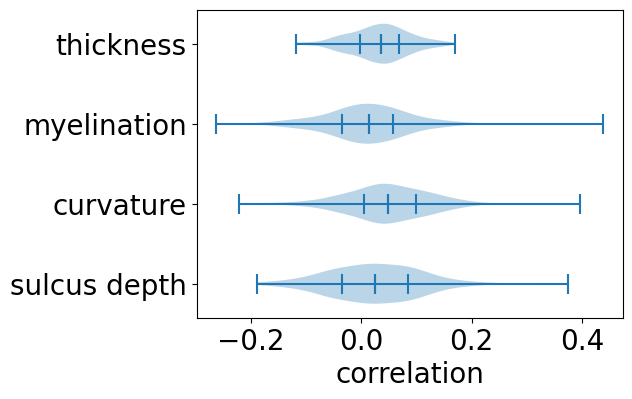

In [52]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5.5, 4) )
label_x = range( 1, len(feature_names)+1 )
single_corrs_list = [depytorch(single_feature_h_corr[:,feature_index]) for feature_index in range(num_features)]
axs.violinplot(  list( reversed(single_corrs_list) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(single_corrs_list), orientation='horizontal'  )
# all_max_crit_corrs = [cc.item() for cc in max_h_node_feature_crit_corr_tensor] + [fc_sc_crit_corr_max, fc_sc_crit_corr_max]
# axs.scatter(  list( reversed(all_max_crit_corrs) ), label_x, color='red', marker='|', linewidth=2, s=80  )
# axs.scatter(  list( reversed([-cc for cc in all_max_crit_corrs]) ), label_x, color='red', marker='|', linewidth=2, s=80  )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(  list( reversed(feature_names) )  )
axs.set_xlabel('correlation')
plt.show()

In [53]:
feature_names_file = ['thickness', 'myelination', 'curvature', 'sulcus_depth']
single_feature_h_corr_old = torch.zeros( size=(num_nodes, num_features), dtype=float_type, device=device )
single_feature_h_corr_crit_old = torch.zeros( size=(num_nodes, num_features), dtype=float_type, device=device )
for feature_index in range(num_features):
    feature_name = feature_names_file[feature_index]
    print(f'{feature_name}')
    feature_corr_file = os.path.join(file_dir, f'h_{feature_name}_corr_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000.pt')
    feature_corr_one = torch.load(f=feature_corr_file, weights_only=False)
    feature_crit_corr_file = os.path.join(file_dir, f'h_{feature_name}_corr_critical_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000_perms_1440000_alpha_3.47e-06.pt')
    feature_crit_corr_one = torch.load(f=feature_crit_corr_file, weights_only=False)
    print( feature_corr_one.size() )
    single_feature_h_corr_old[:,feature_index] = feature_corr_one
    single_feature_h_corr_crit_old[:,feature_index] = feature_crit_corr_one

thickness
torch.Size([360])
myelination
torch.Size([360])
curvature
torch.Size([360])
sulcus_depth
torch.Size([360])


In [54]:
num_nodes, num_features = single_feature_h_corr_old.size()
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
single_feature_h_corr_is_sig_old = single_feature_h_corr_old.abs() >= single_feature_h_corr_crit_old
for feature_index in range(num_features):
    num_sig = torch.count_nonzero(single_feature_h_corr_is_sig_old[:,feature_index])
    fraction_sig = num_sig/num_nodes
    print(f'{num_sig} out of {num_nodes} ({fraction_sig:.3g}) {feature_names[feature_index]}-h correlations are significant.')
    print(f'corr min {single_feature_h_corr_old[:,feature_index].min():.3g} mean {single_feature_h_corr_old[:,feature_index].mean():.3g} max {single_feature_h_corr_old[:,feature_index].max():.3g}')
    print(f'crit corr min {single_feature_h_corr_crit_old[:,feature_index].min():.3g} mean {single_feature_h_corr_crit_old[:,feature_index].mean():.3g} max {single_feature_h_corr_crit_old[:,feature_index].max():.3g}')

10 out of 360 (0.0278) thickness-h correlations are significant.
corr min -0.0955 mean 0.0368 max 0.183
crit corr min 0.134 mean 0.137 max 0.139
29 out of 360 (0.0806) myelination-h correlations are significant.
corr min -0.251 mean 0.0118 max 0.452
crit corr min 0.128 mean 0.138 max 0.183
52 out of 360 (0.144) curvature-h correlations are significant.
corr min -0.217 mean 0.0508 max 0.415
crit corr min 0.135 mean 0.137 max 0.14
43 out of 360 (0.119) sulcus depth-h correlations are significant.
corr min -0.199 mean 0.0294 max 0.382
crit corr min 0.134 mean 0.137 max 0.14


In [55]:
num_nodes, num_features = single_feature_h_pred_corr.size()
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
alpha = 0.05/num_nodes
print(f'alpha = {alpha:.3g}')
single_feature_h_pred_corr_is_sig = single_feature_h_p_pred_corr < alpha
for feature_index in range(num_features):
    num_sig = torch.count_nonzero(single_feature_h_pred_corr_is_sig[:,feature_index])
    fraction_sig = num_sig/num_nodes
    print(f'{num_sig} out of {num_nodes} ({fraction_sig:.3g}) h({feature_names[feature_index]})-h correlations are significant.')
    print(f'corr min {single_feature_h_pred_corr[:,feature_index].min():.3g} mean {single_feature_h_pred_corr[:,feature_index].mean():.3g} max {single_feature_h_pred_corr[:,feature_index].max():.3g}')
    print(f'p value min {single_feature_h_p_pred_corr[:,feature_index].min():.3g} mean {single_feature_h_p_pred_corr[:,feature_index].mean():.3g} max {single_feature_h_p_pred_corr[:,feature_index].max():.3g}')

alpha = 0.000139
7 out of 360 (0.0194) h(thickness)-h correlations are significant.
corr min -0.000673 mean 0.0517 max 0.169
p value min 1e-05 mean 0.325 max 0.999
26 out of 360 (0.0722) h(myelination)-h correlations are significant.
corr min 0 mean 0.062 max 0.439
p value min 0 mean 0.322 max 0.997
41 out of 360 (0.114) h(curvature)-h correlations are significant.
corr min 0.000693 mean 0.076 max 0.397
p value min 0 mean 0.247 max 0.992
35 out of 360 (0.0972) h(sulcus depth)-h correlations are significant.
corr min -0.00935 mean 0.0725 max 0.374
p value min 0 mean 0.261 max 1


In [104]:
print( single_feature_h_coeffs.size() )
print( single_feature_h_predictions.size() )
num_nodes, num_subjects, num_features = single_feature_h_predictions.size()
num_subjects_test = h_for_lstsq_test.size(dim=1)
single_feature_h_predictions_test = torch.zeros( size=(num_nodes, num_subjects_test, num_features), dtype=float_type, device=device )
for feature_index in range(num_features):
    single_feature_h_predictions_test[:,:,feature_index] = torch.matmul( node_features_for_lstsq_test[ :, :, [feature_index,-1] ], single_feature_h_coeffs[:,:,feature_index].unsqueeze(dim=-1) ).squeeze(dim=-1) 
single_feature_h_pred_corr_test = isingmodellight.get_pairwise_correlation(mat1=single_feature_h_predictions_test, mat2=h_for_lstsq_test, epsilon=0.0, dim=1)
print( single_feature_h_pred_corr_test.size() )
print(f'min {single_feature_h_pred_corr_test.min():.3g}, mean {single_feature_h_pred_corr_test.mean():.3g}, max {single_feature_h_pred_corr_test.max():.3g}')

torch.Size([360, 2, 4])
torch.Size([360, 670, 4])
torch.Size([360, 4])
min -0.229, mean 0.0517, max 0.496


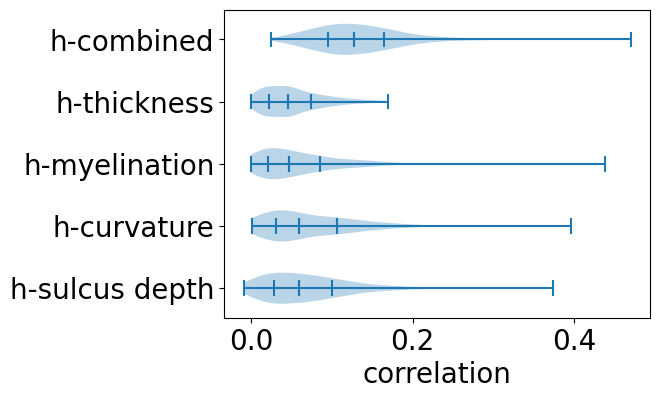

In [105]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5.5, 4) )
corr_labels = ['h-combined'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(local_h_pred_corr)] + [depytorch(single_feature_h_pred_corr[:,feature_index]) for feature_index in range(num_features)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# all_max_crit_corrs = [cc.item() for cc in max_h_node_feature_crit_corr_tensor] + [fc_sc_crit_corr_max, fc_sc_crit_corr_max]
# axs.scatter(  list( reversed(all_max_crit_corrs) ), label_x, color='red', marker='|', linewidth=2, s=80  )
# axs.scatter(  list( reversed([-cc for cc in all_max_crit_corrs]) ), label_x, color='red', marker='|', linewidth=2, s=80  )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
plt.show()

In [109]:
print( single_feature_h_pred_corr.size() )
print( local_h_pred_corr.size() )
print( torch.sum(  ( single_feature_h_pred_corr >= local_h_pred_corr.unsqueeze(dim=-1) ).int(), dim=0  ).tolist() )

torch.Size([360, 4])
torch.Size([360])
[6, 5, 4, 3]


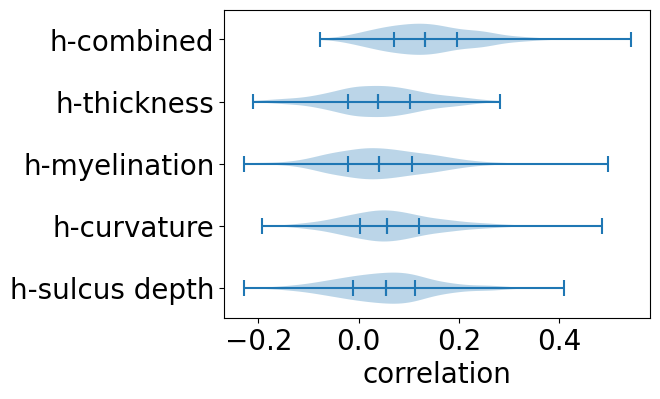

In [106]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5.5, 4) )
corr_labels = ['h-combined'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(local_h_pred_corr_test)] + [depytorch(single_feature_h_pred_corr_test[:,feature_index]) for feature_index in range(num_features)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# all_max_crit_corrs = [cc.item() for cc in max_h_node_feature_crit_corr_tensor] + [fc_sc_crit_corr_max, fc_sc_crit_corr_max]
# axs.scatter(  list( reversed(all_max_crit_corrs) ), label_x, color='red', marker='|', linewidth=2, s=80  )
# axs.scatter(  list( reversed([-cc for cc in all_max_crit_corrs]) ), label_x, color='red', marker='|', linewidth=2, s=80  )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
plt.show()

In [110]:
print( single_feature_h_pred_corr_test.size() )
print( local_h_pred_corr_test.size() )
print( torch.sum(  ( single_feature_h_pred_corr_test >= local_h_pred_corr_test.unsqueeze(dim=-1) ).int(), dim=0  ).tolist() )

torch.Size([360, 4])
torch.Size([360])
[54, 55, 66, 62]


In [111]:
local_h_pred_corr_np = depytorch(local_h_pred_corr_test)
num_nodes = local_h_pred_corr.numel()
for feature_index in range( len(feature_names) ):
    feature_local_h_pred_corr = single_feature_h_pred_corr_test[:,feature_index]
    num_greater = torch.count_nonzero(local_h_pred_corr_test > feature_local_h_pred_corr)
    test_result = stats.wilcoxon( x=local_h_pred_corr_np, y=depytorch(feature_local_h_pred_corr), alternative='greater' )
    print( feature_names[feature_index], test_result, f'{num_greater} of {num_nodes} ({num_greater/num_nodes:.3g}) combined correlations greater' )

thickness WilcoxonResult(statistic=np.float64(60711.0), pvalue=np.float64(1.4057612886095952e-46)) 306 of 360 (0.85) combined correlations greater
myelination WilcoxonResult(statistic=np.float64(60415.0), pvalue=np.float64(1.1933976503707145e-45)) 305 of 360 (0.847) combined correlations greater
curvature WilcoxonResult(statistic=np.float64(58706.0), pvalue=np.float64(1.7789083388058037e-40)) 294 of 360 (0.817) combined correlations greater
sulcus depth WilcoxonResult(statistic=np.float64(59735.0), pvalue=np.float64(1.4926297863710397e-43)) 298 of 360 (0.828) combined correlations greater


In [114]:
print( torch.median(  ( local_h_pred_corr.unsqueeze(dim=-1) - single_feature_h_pred_corr ), dim=0  ).values.tolist() )

[0.07641445845365524, 0.06842373311519623, 0.04881146550178528, 0.056887559592723846]


In [115]:
print( torch.median(  ( local_h_pred_corr_test.unsqueeze(dim=-1) - single_feature_h_pred_corr_test ), dim=0  ).values.tolist() )

[0.07977604120969772, 0.08309739828109741, 0.04953812062740326, 0.06587326526641846]


In [123]:
alpha = 0.05/num_nodes
print( single_feature_h_p_corr.size() )
single_feature_corr_is_sig = single_feature_h_p_corr < alpha
single_feature_corr_num_sig = torch.sum( single_feature_corr_is_sig.int(), dim=0 ).tolist()
print(single_feature_corr_num_sig)

torch.Size([360, 4])
[7, 27, 40, 35]


In [122]:
alpha = 0.05/num_nodes
print( single_feature_h_p_pred_corr.size() )
single_feature_corr_is_sig = single_feature_h_p_pred_corr < alpha
single_feature_corr_num_sig = torch.sum( single_feature_corr_is_sig.int(), dim=0 ).tolist()
print(single_feature_corr_num_sig)

torch.Size([360, 4])
[7, 26, 41, 35]


In [132]:
overfitting_amount = local_h_pred_corr_test[all_features_h_pred_cor_is_sig] - local_h_pred_corr[all_features_h_pred_cor_is_sig]
print( overfitting_amount.min().item(), overfitting_amount.median().item(), overfitting_amount.max().item() )

-0.27657508850097656 -0.005597621202468872 0.141973078250885


In [134]:
all_node_features = torch.load( os.path.join(other_file_dir, 'node_features_all_as_is.pt'), weights_only=False )[:,:,:4]
print( 'node features size', all_node_features.size() )
# sc = torch.load( os.path.join(other_file_dir, 'edge_features_all_as_is.pt'), weights_only=False )[training_subject_start:training_subject_end,:,0]

node features size torch.Size([837, 360, 4])


In [135]:
def load_mean_params_all(param_string:str):
    model_file = os.path.join( other_file_dir, f'ising_model_light_{param_string}.pt' )
    model = torch.load(model_file, weights_only=False)
    num_nodes = model.J.size(dim=-1)
    triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=num_nodes, device=model.J.device )
    return model.h.mean(dim=0), model.J[:,:,triu_rows,triu_cols].mean(dim=0)
h, J = load_mean_params_all(param_string=param_string)
print( h.size() )

torch.Size([837, 360])


In [164]:
def do_lstsq_split(h:torch.Tensor, features:torch.Tensor, num_training:int):
    features_train = features[:,:num_training,:]
    h_train = h[:,:num_training,:]
    coeffs = torch.linalg.lstsq(features_train, h_train).solution
    train_corr = isingmodellight.get_pairwise_correlation( mat1=h_train, mat2=torch.matmul(features_train, coeffs), epsilon=0, dim=1 )
    test_corr = isingmodellight.get_pairwise_correlation( mat1=h[:,num_training:,:], mat2=torch.matmul(features[:,num_training:,:], coeffs), epsilon=0, dim=1 )
    return train_corr.squeeze(dim=-1), test_corr.squeeze(dim=-1)
num_subjects, num_nodes = h.size()
num_features = all_node_features.size(dim=-1)
node_features_for_lstsq = all_node_features.transpose(dim0=0, dim1=1)
print( 'node_features_for_lstsq size', node_features_for_lstsq.size() )
h_for_lstsq = h.transpose(dim0=0, dim1=1).unsqueeze(dim=-1)
print( 'h_for_lstsq size', h_for_lstsq.size() )
num_training = 419
train_corr, test_corr = do_lstsq_split(h=h_for_lstsq, features=node_features_for_lstsq, num_training=num_training)
print('correlation sizes')
print( train_corr.size(), test_corr.size() )
print( f'training min {train_corr.min():.3g} mean {train_corr.mean():.3g} max {train_corr.max():.3g}' )
print( f'testing  min {test_corr.min():.3g} mean {test_corr.mean():.3g} max {test_corr.max():.3g}' )

node_features_for_lstsq size torch.Size([360, 837, 4])
h_for_lstsq size torch.Size([360, 837, 1])
correlation sizes
torch.Size([360]) torch.Size([360])
training min -0.0873 mean 0.119 max 0.389
testing  min -0.136 mean 0.0739 max 0.443


In [165]:
num_splits = 10000
train_corr_splits = torch.zeros( (num_splits, num_nodes), dtype=float_type, device=device )
test_corr_splits = torch.zeros_like(train_corr_splits)
start_time = time.time()
for split_index in range(num_splits):
    perm = torch.randperm(n=num_subjects, dtype=int_type, device=device)
    train_corr_splits[split_index,:], test_corr_splits[split_index,:] = do_lstsq_split(h=h_for_lstsq[:,perm,:], features=node_features_for_lstsq[:,perm,:], num_training=num_training)
print( f'time {time.time()-start_time:.3f}' )
print( f'training min {train_corr_splits.min():.3g} mean {train_corr_splits.mean():.3g} max {train_corr_splits.max():.3g}' )
print( f'testing  min {test_corr_splits.min():.3g} mean {test_corr_splits.mean():.3g} max {test_corr_splits.max():.3g}' )

time 194.683
training min -0.241 mean 0.121 max 0.521
testing  min -0.333 mean 0.0735 max 0.501


In [166]:
test_train_diff = torch.abs(test_corr_splits - train_corr_splits)
print( test_train_diff.min().item(), test_train_diff.median().item(), test_train_diff.max().item() )

2.2351741790771484e-08 0.05633234977722168 0.38500404357910156


In [167]:
print(  torch.count_nonzero(test_corr_splits - train_corr_splits >= 0)/test_corr_splits.numel()  )

tensor(0.2329, device='cuda:0')


In [171]:
single_feature_h_corr_results_0 = torch.load( os.path.join(file_dir, 'one_feature_h_linear_model_ising_model_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000.pt'), weights_only=False )
print( len(single_feature_h_corr_results_0) )

8


In [172]:
single_feature_h_coeffs_0 = single_feature_h_corr_results_0[0]
single_feature_h_predictions_0 = single_feature_h_corr_results_0[1]
single_feature_h_p_r_squared_0 = single_feature_h_corr_results_0[2]
single_feature_h_pred_corr_0 = single_feature_h_corr_results_0[3]
single_feature_h_p_r_squared_0 = single_feature_h_corr_results_0[4]
single_feature_h_p_pred_corr_0 = single_feature_h_corr_results_0[5]
single_feature_h_corr_0 = single_feature_h_corr_results_0[6]
single_feature_h_p_corr_0 = single_feature_h_corr_results_0[7]

In [174]:
num_nodes, num_features = single_feature_h_p_corr_0.size()
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
alpha = 0.05/num_nodes
print(f'alpha = {alpha:.3g}')
single_feature_h_corr_is_sig_0 = single_feature_h_p_corr_0 < alpha
for feature_index in range(num_features):
    num_sig = torch.count_nonzero(single_feature_h_corr_is_sig_0[:,feature_index])
    fraction_sig = num_sig/num_nodes
    print(f'{num_sig} out of {num_nodes} ({fraction_sig:.3g}) {feature_names[feature_index]}-h correlations are significant.')
    print(f'corr min {single_feature_h_corr_0[:,feature_index].min():.3g} mean {single_feature_h_corr_0[:,feature_index].mean():.3g} max {single_feature_h_corr_0[:,feature_index].max():.3g}')
    print(f'p value min {single_feature_h_p_corr_0[:,feature_index].min():.3g} mean {single_feature_h_p_corr_0[:,feature_index].mean():.3g} max {single_feature_h_p_corr_0[:,feature_index].max():.3g}')

alpha = 0.000139
2 out of 360 (0.00556) thickness-h correlations are significant.
corr min -0.13 mean -0.00557 max 0.0979
p value min 0 mean 0.442 max 0.999
8 out of 360 (0.0222) myelination-h correlations are significant.
corr min -0.152 mean -0.00162 max 0.134
p value min 0 mean 0.427 max 1
20 out of 360 (0.0556) curvature-h correlations are significant.
corr min -0.0954 mean 0.0361 max 0.204
p value min 0 mean 0.333 max 0.99
15 out of 360 (0.0417) sulcus depth-h correlations are significant.
corr min -0.0936 mean 0.0303 max 0.184
p value min 0 mean 0.377 max 1


In [176]:
single_feature_h_corr_results_1 = torch.load( os.path.join(file_dir, 'one_feature_h_linear_model_ising_model_light_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000_v3.pt'), weights_only=False )
print( len(single_feature_h_corr_results_1) )

8


In [177]:
single_feature_h_coeffs_1 = single_feature_h_corr_results_1[0]
single_feature_h_predictions_1 = single_feature_h_corr_results_1[1]
single_feature_h_p_r_squared_1 = single_feature_h_corr_results_1[2]
single_feature_h_pred_corr_1 = single_feature_h_corr_results_1[3]
single_feature_h_p_r_squared_1 = single_feature_h_corr_results_1[4]
single_feature_h_p_pred_corr_1 = single_feature_h_corr_results_1[5]
single_feature_h_corr_1 = single_feature_h_corr_results_1[6]
single_feature_h_p_corr_1 = single_feature_h_corr_results_1[7]

In [178]:
num_nodes, num_features = single_feature_h_p_corr_1.size()
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
alpha = 0.05/num_nodes
print(f'alpha = {alpha:.3g}')
single_feature_h_corr_is_sig_1 = single_feature_h_p_corr_1 < alpha
for feature_index in range(num_features):
    num_sig = torch.count_nonzero(single_feature_h_corr_is_sig_1[:,feature_index])
    fraction_sig = num_sig/num_nodes
    print(f'{num_sig} out of {num_nodes} ({fraction_sig:.3g}) {feature_names[feature_index]}-h correlations are significant.')
    print(f'corr min {single_feature_h_corr_1[:,feature_index].min():.3g} mean {single_feature_h_corr_1[:,feature_index].mean():.3g} max {single_feature_h_corr_1[:,feature_index].max():.3g}')
    print(f'p value min {single_feature_h_p_corr_1[:,feature_index].min():.3g} mean {single_feature_h_p_corr_1[:,feature_index].mean():.3g} max {single_feature_h_p_corr_1[:,feature_index].max():.3g}')

alpha = 0.000139
14 out of 360 (0.0389) thickness-h correlations are significant.
corr min -0.0955 mean 0.0368 max 0.183
p value min 0 mean 0.31 max 0.999
34 out of 360 (0.0944) myelination-h correlations are significant.
corr min -0.251 mean 0.0118 max 0.452
p value min 0 mean 0.295 max 0.995
52 out of 360 (0.144) curvature-h correlations are significant.
corr min -0.217 mean 0.0508 max 0.415
p value min 0 mean 0.226 max 0.995
44 out of 360 (0.122) sulcus depth-h correlations are significant.
corr min -0.199 mean 0.0294 max 0.382
p value min 0 mean 0.236 max 0.976


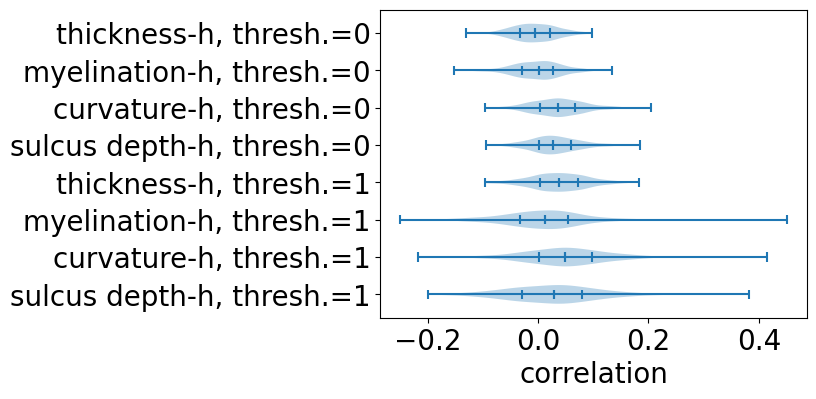

In [179]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5.5, 4) )
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
corr_labels = [ f'{fn}-h, thresh.=0' for fn in feature_names ] + [ f'{fn}-h, thresh.=1' for fn in feature_names ]
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(single_feature_h_corr_0[:,feature_index]) for feature_index in range(num_features)] + [depytorch(single_feature_h_corr_1[:,feature_index]) for feature_index in range(num_features)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# all_max_crit_corrs = [cc.item() for cc in max_h_node_feature_crit_corr_tensor] + [fc_sc_crit_corr_max, fc_sc_crit_corr_max]
# axs.scatter(  list( reversed(all_max_crit_corrs) ), label_x, color='red', marker='|', linewidth=2, s=80  )
# axs.scatter(  list( reversed([-cc for cc in all_max_crit_corrs]) ), label_x, color='red', marker='|', linewidth=2, s=80  )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
plt.show()

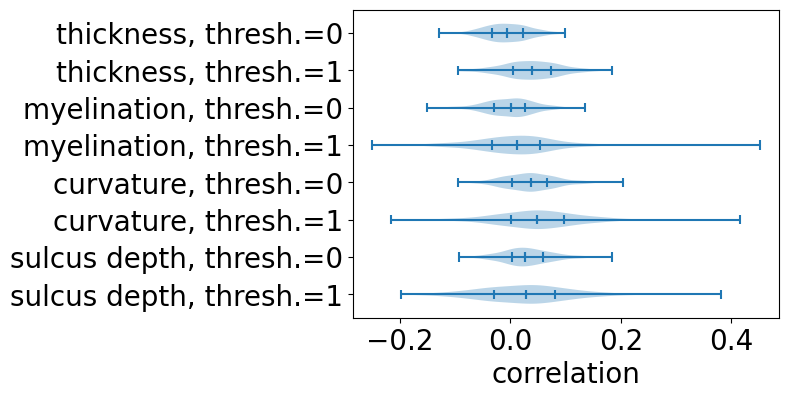

In [182]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5.5, 4) )
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
corr_labels = [val for pair in zip([f'{fn}, thresh.=0' for fn in feature_names], [f'{fn}, thresh.=1' for fn in feature_names]) for val in pair]
label_x = range( 1, len(corr_labels)+1 )
all_corrs_tensor = torch.stack( (single_feature_h_corr_0, single_feature_h_corr_1), dim=-1 ).flatten(start_dim=-2, end_dim=-1)
all_corrs = [depytorch(all_corrs_tensor[:,corr_index]) for corr_index in range( all_corrs_tensor.size(dim=-1) )]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# all_max_crit_corrs = [cc.item() for cc in max_h_node_feature_crit_corr_tensor] + [fc_sc_crit_corr_max, fc_sc_crit_corr_max]
# axs.scatter(  list( reversed(all_max_crit_corrs) ), label_x, color='red', marker='|', linewidth=2, s=80  )
# axs.scatter(  list( reversed([-cc for cc in all_max_crit_corrs]) ), label_x, color='red', marker='|', linewidth=2, s=80  )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
plt.show()

In [190]:
J_sc_corr_0 = torch.load( os.path.join(file_dir, 'sc_J_linear_model_ising_model_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000_v2.pt'), weights_only=False )
print( len(J_sc_corr_0) )

8


In [191]:
sc_J_coeffs_0 = J_sc_corr_0[0]
print( sc_J_coeffs_0.size() )
sc_J_dependent_prediction_0 = J_sc_corr_0[1]
print( sc_J_dependent_prediction_0.size() )
sc_J_r_squared_0 = J_sc_corr_0[2]
print( sc_J_r_squared_0.size() )
sc_J_pred_corr_0 = J_sc_corr_0[3]
print( sc_J_pred_corr_0.size() )
sc_J_p_r_squared_0 = J_sc_corr_0[4]
print( sc_J_p_r_squared_0.size() )
sc_J_p_pred_corr_0 = J_sc_corr_0[5]
print( sc_J_p_pred_corr_0.size() )
sc_J_corr_0 = J_sc_corr_0[6]
print( sc_J_corr_0.size() )
sc_J_p_corr_0 = J_sc_corr_0[7]
print( sc_J_p_corr_0.size() )

torch.Size([64620, 2, 1])
torch.Size([64620, 837, 1])
torch.Size([64620])
torch.Size([64620])
torch.Size([64620])
torch.Size([64620])
torch.Size([64620])
torch.Size([64620])


In [192]:
print( f'SC-J direct correlation min {sc_J_corr_0.min():.3g} mean {sc_J_corr_0.mean():.3g} max {sc_J_corr_0.max():.3g}' )
print( f'predicted J(SC)-J correlation min {sc_J_pred_corr_0.min():.3g} mean {sc_J_pred_corr_0.mean():.3g} max {sc_J_pred_corr_0.max():.3g}' )

SC-J direct correlation min -0.181 mean 0.0052 max 0.412
predicted J(SC)-J correlation min -0.0853 mean 0.0324 max 0.412


In [198]:
J_sc_corr_1 = torch.load( os.path.join(file_dir, 'sc_J_linear_model_ising_model_light_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000.pt'), weights_only=False )
print( len(J_sc_corr_1) )

8


In [199]:
sc_J_coeffs_1 = J_sc_corr_1[0]
print( sc_J_coeffs_1.size() )
sc_J_dependent_prediction_1 = J_sc_corr_1[1]
print( sc_J_dependent_prediction_1.size() )
sc_J_r_squared_1 = J_sc_corr_1[2]
print( sc_J_r_squared_1.size() )
sc_J_pred_corr_1 = J_sc_corr_1[3]
print( sc_J_pred_corr_1.size() )
sc_J_p_r_squared_1 = J_sc_corr_1[4]
print( sc_J_p_r_squared_1.size() )
sc_J_p_pred_corr_1 = J_sc_corr_1[5]
print( sc_J_p_pred_corr_1.size() )
sc_J_corr_1 = J_sc_corr_1[6]
print( sc_J_corr_1.size() )
sc_J_p_corr_1 = J_sc_corr_1[7]
print( sc_J_p_corr_1.size() )

torch.Size([64620, 2, 1])
torch.Size([64620, 837, 1])
torch.Size([64620])
torch.Size([64620])
torch.Size([64620])
torch.Size([64620])
torch.Size([64620])
torch.Size([64620])


In [200]:
print( f'SC-J direct correlation min {sc_J_corr_1.min():.3g} mean {sc_J_corr_1.mean():.3g} max {sc_J_corr_1.max():.3g}' )
print( f'predicted J(SC)-J correlation min {sc_J_pred_corr_1.min():.3g} mean {sc_J_pred_corr_1.mean():.3g} max {sc_J_pred_corr_1.max():.3g}' )

SC-J direct correlation min -0.166 mean 0.00434 max 0.404
predicted J(SC)-J correlation min -0.0941 mean 0.0322 max 0.404


In [212]:
fc_sc_corr_0 = torch.load( os.path.join(file_dir, 'sc_fc_linear_model_ising_model_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000.pt'), weights_only=False )
print( len(fc_sc_corr_0) )

8


In [213]:
sc_fc_coeffs_0 = fc_sc_corr_0[0]
print( sc_fc_coeffs_0.size() )
sc_fc_dependent_prediction_0 = fc_sc_corr_0[1]
print( sc_fc_dependent_prediction_0.size() )
sc_fc_r_squared_0 = fc_sc_corr_0[2]
print( sc_fc_r_squared_0.size() )
sc_fc_pred_corr_0 = fc_sc_corr_0[3]
print( sc_fc_pred_corr_0.size() )
sc_fc_p_r_squared_0 = fc_sc_corr_0[4]
print( sc_fc_p_r_squared_0.size() )
sc_fc_p_pred_corr_0 = fc_sc_corr_0[5]
print( sc_fc_p_pred_corr_0.size() )
sc_fc_corr_0 = fc_sc_corr_0[6]
print( sc_fc_corr_0.size() )
sc_fc_p_corr_0 = fc_sc_corr_0[7]
print( sc_fc_p_corr_0.size() )

torch.Size([64620, 2, 1])
torch.Size([64620, 837, 1])
torch.Size([64620])
torch.Size([64620])
torch.Size([64620])
torch.Size([64620])
torch.Size([64620])
torch.Size([64620])


In [214]:
print( f'FC-J direct correlation min {sc_fc_corr_0.min():.3g} mean {sc_fc_corr_0.mean():.3g} max {sc_fc_corr_0.max():.3g}' )
print( f'predicted J(FC)-J correlation min {sc_fc_pred_corr_0.min():.3g} mean {sc_fc_pred_corr_0.mean():.3g} max {sc_fc_pred_corr_0.max():.3g}' )

FC-J direct correlation min -0.172 mean 0.00393 max 0.299
predicted J(FC)-J correlation min -0.876 mean 0.0347 max 0.299


In [215]:
fc_sc_corr_1 = torch.load( os.path.join(file_dir, 'sc_fc_linear_model_ising_model_light_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000.pt'), weights_only=False )
print( len(fc_sc_corr_1) )

8


In [216]:
sc_fc_coeffs_1 = fc_sc_corr_1[0]
print( sc_fc_coeffs_1.size() )
sc_fc_dependent_prediction_1 = fc_sc_corr_1[1]
print( sc_fc_dependent_prediction_1.size() )
sc_fc_r_squared_1 = fc_sc_corr_1[2]
print( sc_fc_r_squared_1.size() )
sc_fc_pred_corr_1 = fc_sc_corr_1[3]
print( sc_fc_pred_corr_1.size() )
sc_fc_p_r_squared_1 = fc_sc_corr_1[4]
print( sc_fc_p_r_squared_1.size() )
sc_fc_p_pred_corr_1 = fc_sc_corr_1[5]
print( sc_fc_p_pred_corr_1.size() )
sc_fc_corr_1 = fc_sc_corr_1[6]
print( sc_fc_corr_1.size() )
sc_fc_p_corr_1 = fc_sc_corr_1[7]
print( sc_fc_p_corr_1.size() )

torch.Size([64620, 2, 1])
torch.Size([64620, 837, 1])
torch.Size([64620])
torch.Size([64620])
torch.Size([64620])
torch.Size([64620])
torch.Size([64620])
torch.Size([64620])


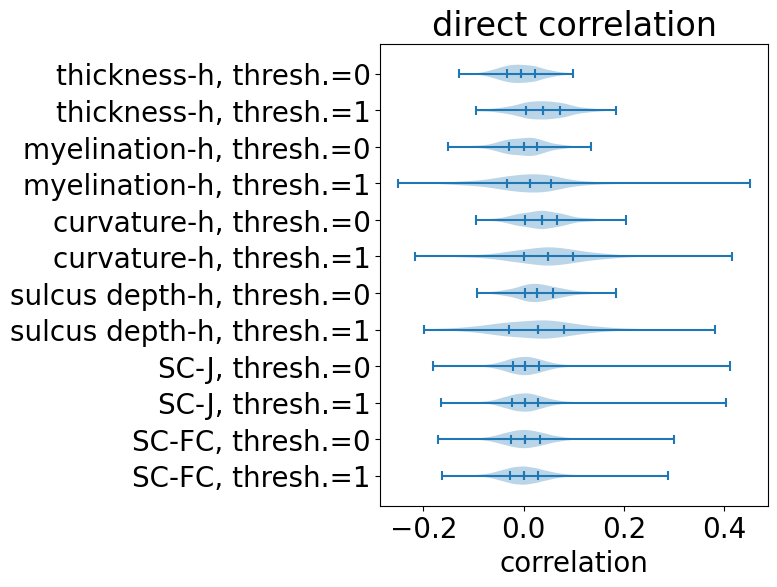

In [223]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 6) )
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
corr_labels = [val for pair in zip([f'{fn}-h, thresh.=0' for fn in feature_names], [f'{fn}-h, thresh.=1' for fn in feature_names]) for val in pair] + ['SC-J, thresh.=0'] + ['SC-J, thresh.=1'] + ['SC-FC, thresh.=0'] + ['SC-FC, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs_tensor = torch.stack( (single_feature_h_corr_0, single_feature_h_corr_1), dim=-1 ).flatten(start_dim=-2, end_dim=-1)
all_corrs = [depytorch(all_corrs_tensor[:,corr_index]) for corr_index in range( all_corrs_tensor.size(dim=-1) )] + [depytorch(sc_J_corr_0)] + [depytorch(sc_J_corr_1)] + [depytorch(sc_fc_corr_0)] + [depytorch(sc_fc_corr_1)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# all_max_crit_corrs = [cc.item() for cc in max_h_node_feature_crit_corr_tensor] + [fc_sc_crit_corr_max, fc_sc_crit_corr_max]
# axs.scatter(  list( reversed(all_max_crit_corrs) ), label_x, color='red', marker='|', linewidth=2, s=80  )
# axs.scatter(  list( reversed([-cc for cc in all_max_crit_corrs]) ), label_x, color='red', marker='|', linewidth=2, s=80  )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
axs.set_title('direct correlation')
plt.show()

In [206]:
h_correlation_results_0 = torch.load( os.path.join(file_dir, 'all_features_h_linear_model_ising_model_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000.pt'), weights_only=False )
print( len(h_correlation_results_0) )

6


In [207]:
all_features_h_coeffs_0 = h_correlation_results_0[0]
all_features_h_dependent_prediction_0 = h_correlation_results_0[1]
all_features_h_r_squared_0 = h_correlation_results_0[2]
all_features_h_pred_corr_0 = h_correlation_results_0[3]
all_features_h_p_r_squared_0 = h_correlation_results_0[4]
all_features_h_p_pred_corr_0 = h_correlation_results_0[5]

In [208]:
h_correlation_results_1 = torch.load( os.path.join(file_dir, 'all_features_h_linear_model_ising_model_light_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000_v3.pt'), weights_only=False )
print( len(h_correlation_results_1) )

6


In [209]:
all_features_h_coeffs_1 = h_correlation_results_1[0]
all_features_h_dependent_prediction_1 = h_correlation_results_1[1]
all_features_h_r_squared_1 = h_correlation_results_1[2]
all_features_h_pred_corr_1 = h_correlation_results_1[3]
all_features_h_p_r_squared_1 = h_correlation_results_1[4]
all_features_h_p_pred_corr_1 = h_correlation_results_1[5]

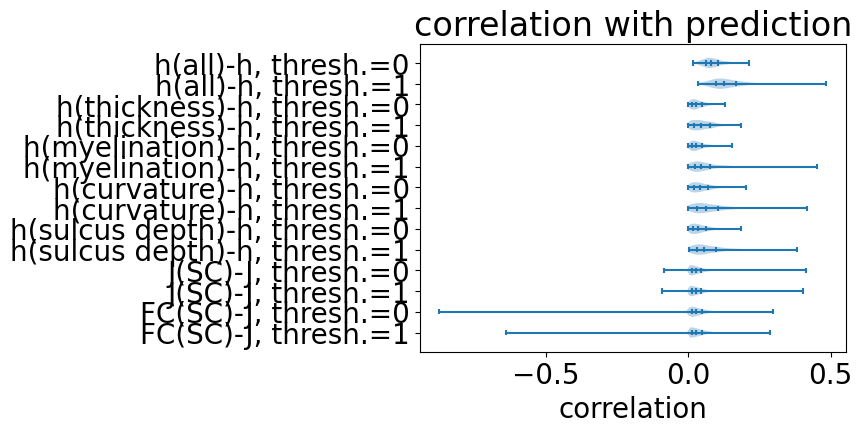

In [218]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5.5, 4) )
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
corr_labels = ['h(all)-h, thresh.=0', 'h(all)-h, thresh.=1'] + [val for pair in zip([f'h({fn})-h, thresh.=0' for fn in feature_names], [f'h({fn})-h, thresh.=1' for fn in feature_names]) for val in pair] + ['J(SC)-J, thresh.=0'] + ['J(SC)-J, thresh.=1'] + ['FC(SC)-J, thresh.=0'] + ['FC(SC)-J, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs_tensor = torch.stack( (single_feature_h_pred_corr_0, single_feature_h_pred_corr_1), dim=-1 ).flatten(start_dim=-2, end_dim=-1)
all_corrs = [depytorch(all_features_h_pred_corr_0)] + [depytorch(all_features_h_pred_corr_1)] + [depytorch(all_corrs_tensor[:,corr_index]) for corr_index in range( all_corrs_tensor.size(dim=-1) )] + [depytorch(sc_J_pred_corr_0)] + [depytorch(sc_J_pred_corr_1)] + [depytorch(sc_fc_pred_corr_0)] + [depytorch(sc_fc_pred_corr_1)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# all_max_crit_corrs = [cc.item() for cc in max_h_node_feature_crit_corr_tensor] + [fc_sc_crit_corr_max, fc_sc_crit_corr_max]
# axs.scatter(  list( reversed(all_max_crit_corrs) ), label_x, color='red', marker='|', linewidth=2, s=80  )
# axs.scatter(  list( reversed([-cc for cc in all_max_crit_corrs]) ), label_x, color='red', marker='|', linewidth=2, s=80  )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
axs.set_title('correlation with prediction')
plt.show()

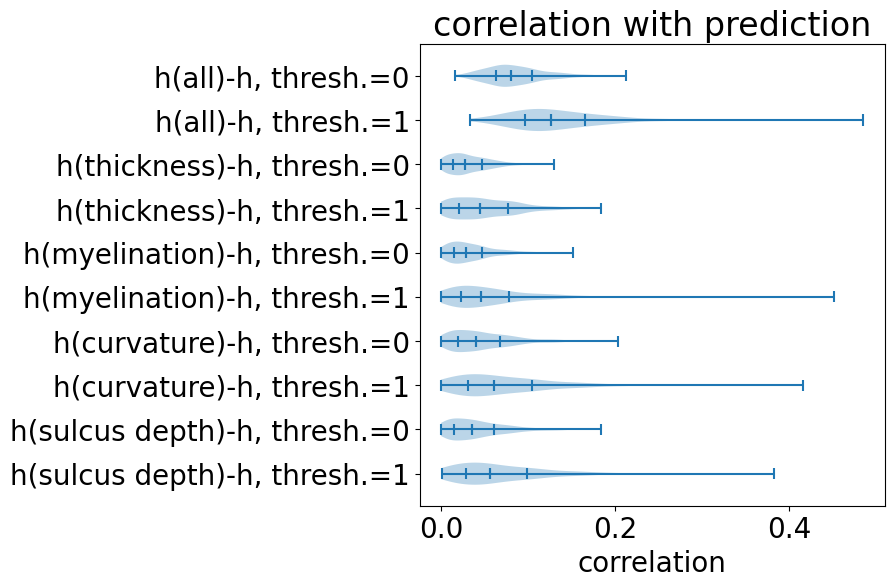

In [228]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 6) )
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
corr_labels = ['h(all)-h, thresh.=0', 'h(all)-h, thresh.=1'] + [val for pair in zip([f'h({fn})-h, thresh.=0' for fn in feature_names], [f'h({fn})-h, thresh.=1' for fn in feature_names]) for val in pair]
label_x = range( 1, len(corr_labels)+1 )
all_corrs_tensor = torch.stack( (single_feature_h_pred_corr_0, single_feature_h_pred_corr_1), dim=-1 ).flatten(start_dim=-2, end_dim=-1)
all_corrs = [depytorch(all_features_h_pred_corr_0)] + [depytorch(all_features_h_pred_corr_1)] + [depytorch(all_corrs_tensor[:,corr_index]) for corr_index in range( all_corrs_tensor.size(dim=-1) )]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# all_max_crit_corrs = [cc.item() for cc in max_h_node_feature_crit_corr_tensor] + [fc_sc_crit_corr_max, fc_sc_crit_corr_max]
# axs.scatter(  list( reversed(all_max_crit_corrs) ), label_x, color='red', marker='|', linewidth=2, s=80  )
# axs.scatter(  list( reversed([-cc for cc in all_max_crit_corrs]) ), label_x, color='red', marker='|', linewidth=2, s=80  )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
axs.set_title('correlation with prediction')
plt.show()

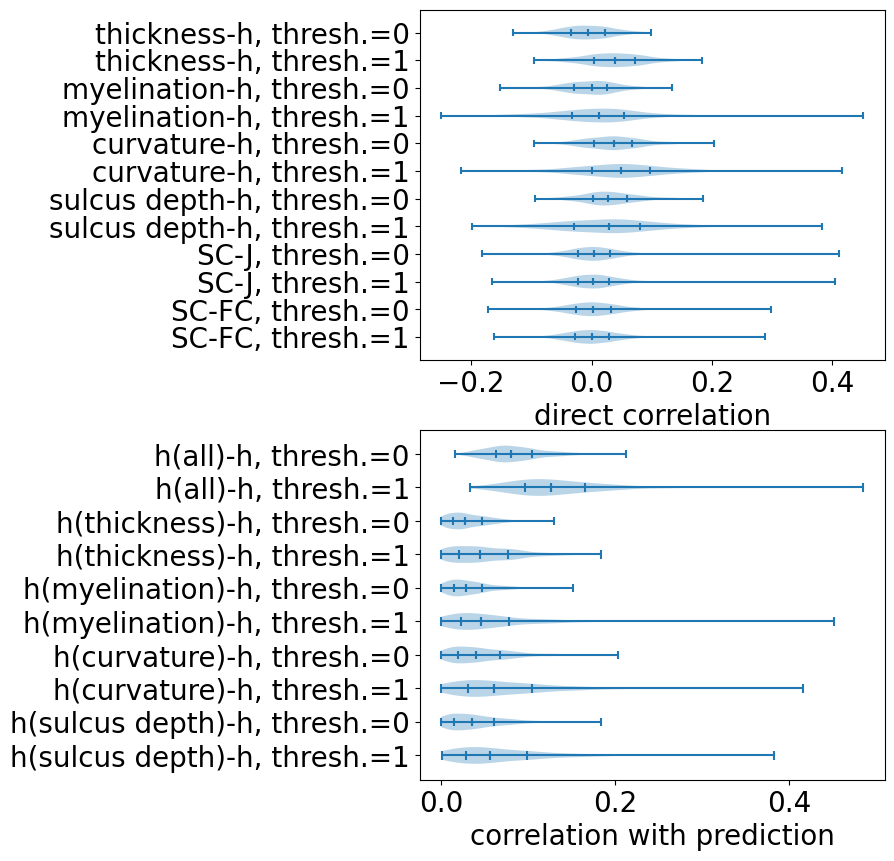

In [242]:
fig, axss = plt.subplots( nrows=2, ncols=1, figsize=(6, 10) )

axs = axss[0]
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
corr_labels = [val for pair in zip([f'{fn}-h, thresh.=0' for fn in feature_names], [f'{fn}-h, thresh.=1' for fn in feature_names]) for val in pair] + ['SC-J, thresh.=0'] + ['SC-J, thresh.=1'] + ['SC-FC, thresh.=0'] + ['SC-FC, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs_tensor = torch.stack( (single_feature_h_corr_0, single_feature_h_corr_1), dim=-1 ).flatten(start_dim=-2, end_dim=-1)
all_corrs = [depytorch(all_corrs_tensor[:,corr_index]) for corr_index in range( all_corrs_tensor.size(dim=-1) )] + [depytorch(sc_J_corr_0)] + [depytorch(sc_J_corr_1)] + [depytorch(sc_fc_corr_0)] + [depytorch(sc_fc_corr_1)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# all_max_crit_corrs = [cc.item() for cc in max_h_node_feature_crit_corr_tensor] + [fc_sc_crit_corr_max, fc_sc_crit_corr_max]
# axs.scatter(  list( reversed(all_max_crit_corrs) ), label_x, color='red', marker='|', linewidth=2, s=80  )
# axs.scatter(  list( reversed([-cc for cc in all_max_crit_corrs]) ), label_x, color='red', marker='|', linewidth=2, s=80  )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('direct correlation')

axs = axss[1]
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
corr_labels = ['h(all)-h, thresh.=0', 'h(all)-h, thresh.=1'] + [val for pair in zip([f'h({fn})-h, thresh.=0' for fn in feature_names], [f'h({fn})-h, thresh.=1' for fn in feature_names]) for val in pair]
label_x = range( 1, len(corr_labels)+1 )
all_corrs_tensor = torch.stack( (single_feature_h_pred_corr_0, single_feature_h_pred_corr_1), dim=-1 ).flatten(start_dim=-2, end_dim=-1)
all_corrs = [depytorch(all_features_h_pred_corr_0)] + [depytorch(all_features_h_pred_corr_1)] + [depytorch(all_corrs_tensor[:,corr_index]) for corr_index in range( all_corrs_tensor.size(dim=-1) )]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# all_max_crit_corrs = [cc.item() for cc in max_h_node_feature_crit_corr_tensor] + [fc_sc_crit_corr_max, fc_sc_crit_corr_max]
# axs.scatter(  list( reversed(all_max_crit_corrs) ), label_x, color='red', marker='|', linewidth=2, s=80  )
# axs.scatter(  list( reversed([-cc for cc in all_max_crit_corrs]) ), label_x, color='red', marker='|', linewidth=2, s=80  )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation with prediction')
plt.show()

Text(0.5, 0, 'correlation')

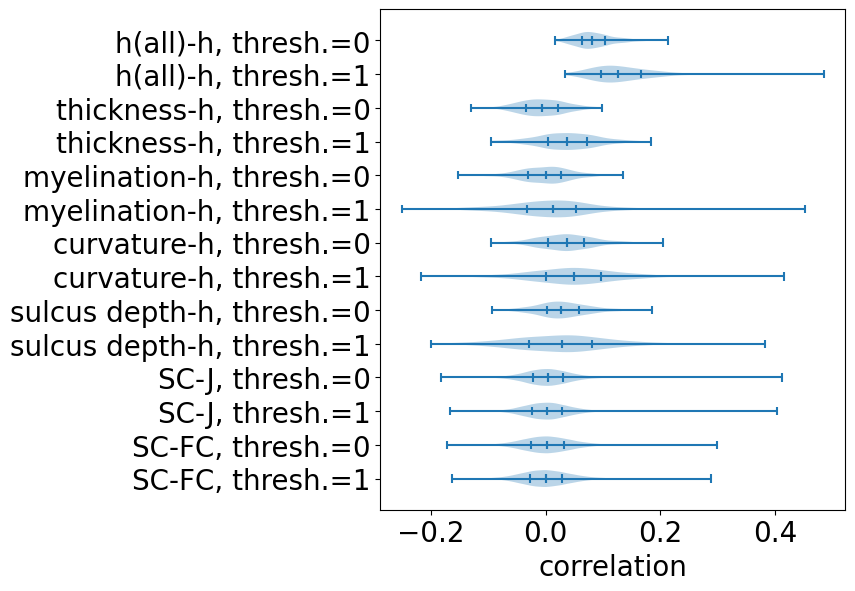

In [248]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 6.5) )

feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
corr_labels = ['h(all)-h, thresh.=0'] + ['h(all)-h, thresh.=1'] + [val for pair in zip([f'{fn}-h, thresh.=0' for fn in feature_names], [f'{fn}-h, thresh.=1' for fn in feature_names]) for val in pair] + ['SC-J, thresh.=0'] + ['SC-J, thresh.=1'] + ['SC-FC, thresh.=0'] + ['SC-FC, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs_tensor = torch.stack( (single_feature_h_corr_0, single_feature_h_corr_1), dim=-1 ).flatten(start_dim=-2, end_dim=-1)
all_corrs = [depytorch(all_features_h_pred_corr_0)] + [depytorch(all_features_h_pred_corr_1)] + [depytorch(all_corrs_tensor[:,corr_index]) for corr_index in range( all_corrs_tensor.size(dim=-1) )] + [depytorch(sc_J_corr_0)] + [depytorch(sc_J_corr_1)] + [depytorch(sc_fc_corr_0)] + [depytorch(sc_fc_corr_1)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# all_max_crit_corrs = [cc.item() for cc in max_h_node_feature_crit_corr_tensor] + [fc_sc_crit_corr_max, fc_sc_crit_corr_max]
# axs.scatter(  list( reversed(all_max_crit_corrs) ), label_x, color='red', marker='|', linewidth=2, s=80  )
# axs.scatter(  list( reversed([-cc for cc in all_max_crit_corrs]) ), label_x, color='red', marker='|', linewidth=2, s=80  )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')

Text(0.5, 1.0, 'FC-SC')

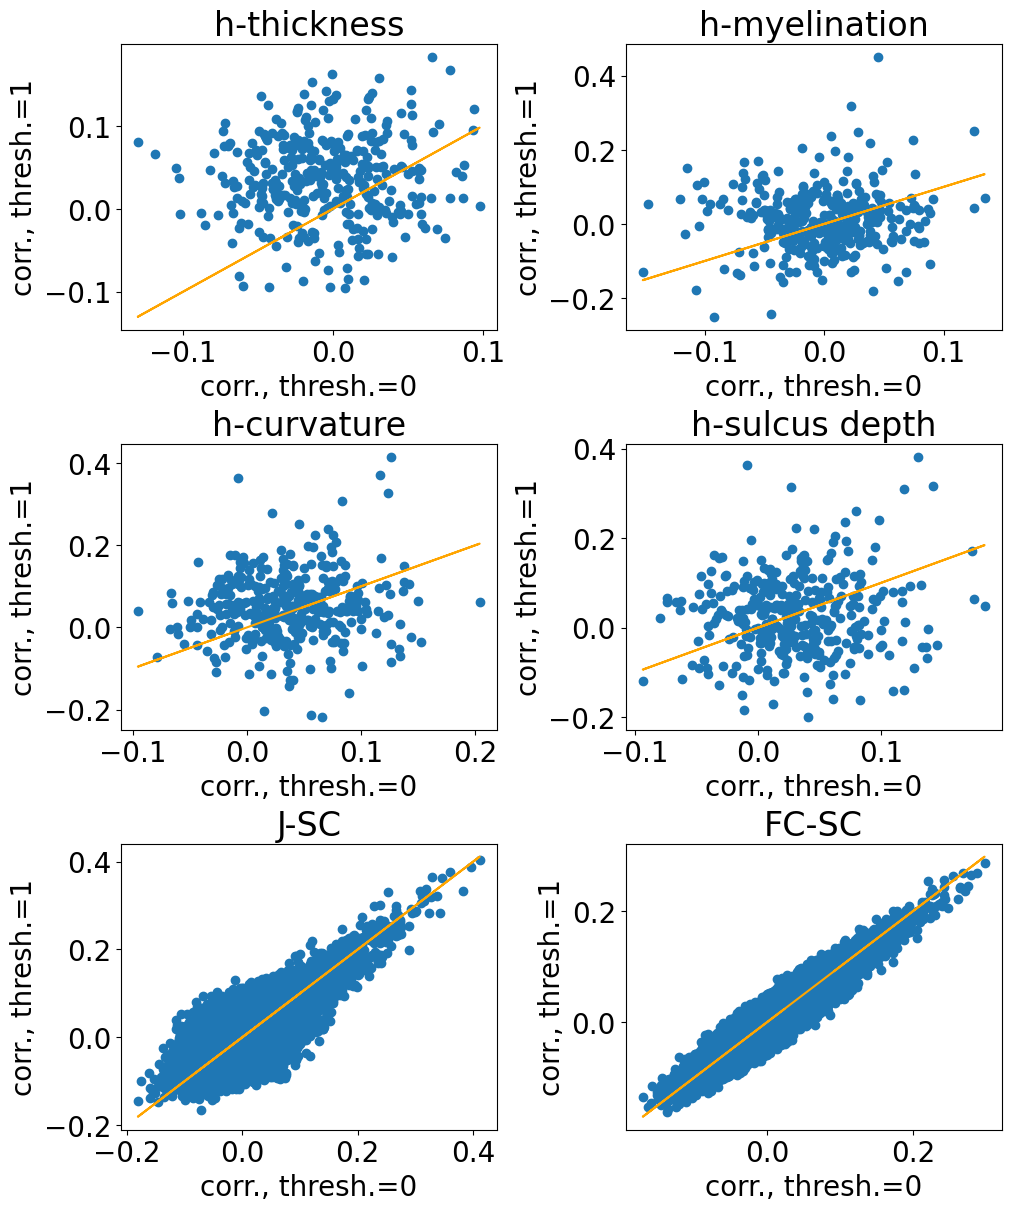

In [232]:
fig, axs = plt.subplots( nrows=3, ncols=2, figsize=(10, 12), layout='constrained' )
for feature_index, r, c in zip(  range( len(feature_names) ), [0,0,1,1], [0,1,0,1]  ):
    ax = axs[r,c]
    # , color='blue', label=f'{sig_label}, {100*sig_count/num_pairs:.3g}%'
    ax.scatter( depytorch(single_feature_h_corr_0[:,feature_index]), depytorch(single_feature_h_corr_1[:,feature_index]) )
    identity_ones = depytorch(single_feature_h_corr_0[:,feature_index])
    ax.plot( identity_ones, identity_ones, color='orange', label='identity' )
    ax.set_xlabel('corr., thresh.=0')
    ax.set_ylabel('corr., thresh.=1')
    ax.set_title(f'h-{feature_names[feature_index]}')

ax = axs[2,0]
# , color='blue', label=f'{sig_label}, {100*sig_count/num_pairs:.3g}%'
ax.scatter( depytorch(sc_J_corr_0), depytorch(sc_J_corr_1) )
identity_ones = depytorch(sc_J_corr_0)
ax.plot( identity_ones, identity_ones, color='orange', label='identity' )
ax.set_xlabel('corr., thresh.=0')
ax.set_ylabel('corr., thresh.=1')
ax.set_title(f'J-SC')

ax = axs[2,1]
# , color='blue', label=f'{sig_label}, {100*sig_count/num_pairs:.3g}%'
ax.scatter( depytorch(sc_fc_corr_0), depytorch(sc_fc_corr_1) )
identity_ones = depytorch(sc_fc_corr_0)
ax.plot( identity_ones, identity_ones, color='orange', label='identity' )
ax.set_xlabel('corr., thresh.=0')
ax.set_ylabel('corr., thresh.=1')
ax.set_title(f'FC-SC')

corr., thresh.=1=0.0513corr., thresh.=0+0.0371, R^2=0.00158
corr., thresh.=1 v. corr., thresh.=0 corr.=0.0396, p-value=0.48
corr., thresh.=1=0.138corr., thresh.=0+0.0121, R^2=0.00593
corr., thresh.=1 v. corr., thresh.=0 corr.=0.0768, p-value=0.12
corr., thresh.=1=0.17corr., thresh.=0+0.0447, R^2=0.00887
corr., thresh.=1 v. corr., thresh.=0 corr.=0.0939, p-value=0.08
corr., thresh.=1=0.167corr., thresh.=0+0.0243, R^2=0.00763
corr., thresh.=1 v. corr., thresh.=0 corr.=0.0871, p-value=0.11
corr., thresh.=1=0.596corr., thresh.=0+0.00125, R^2=0.36
corr., thresh.=1 v. corr., thresh.=0 corr.=0.6, p-value=0
corr., thresh.=1=0.915corr., thresh.=0+-0.00168, R^2=0.872
corr., thresh.=1 v. corr., thresh.=0 corr.=0.934, p-value=0


Text(0.5, 1.0, 'FC-SC')

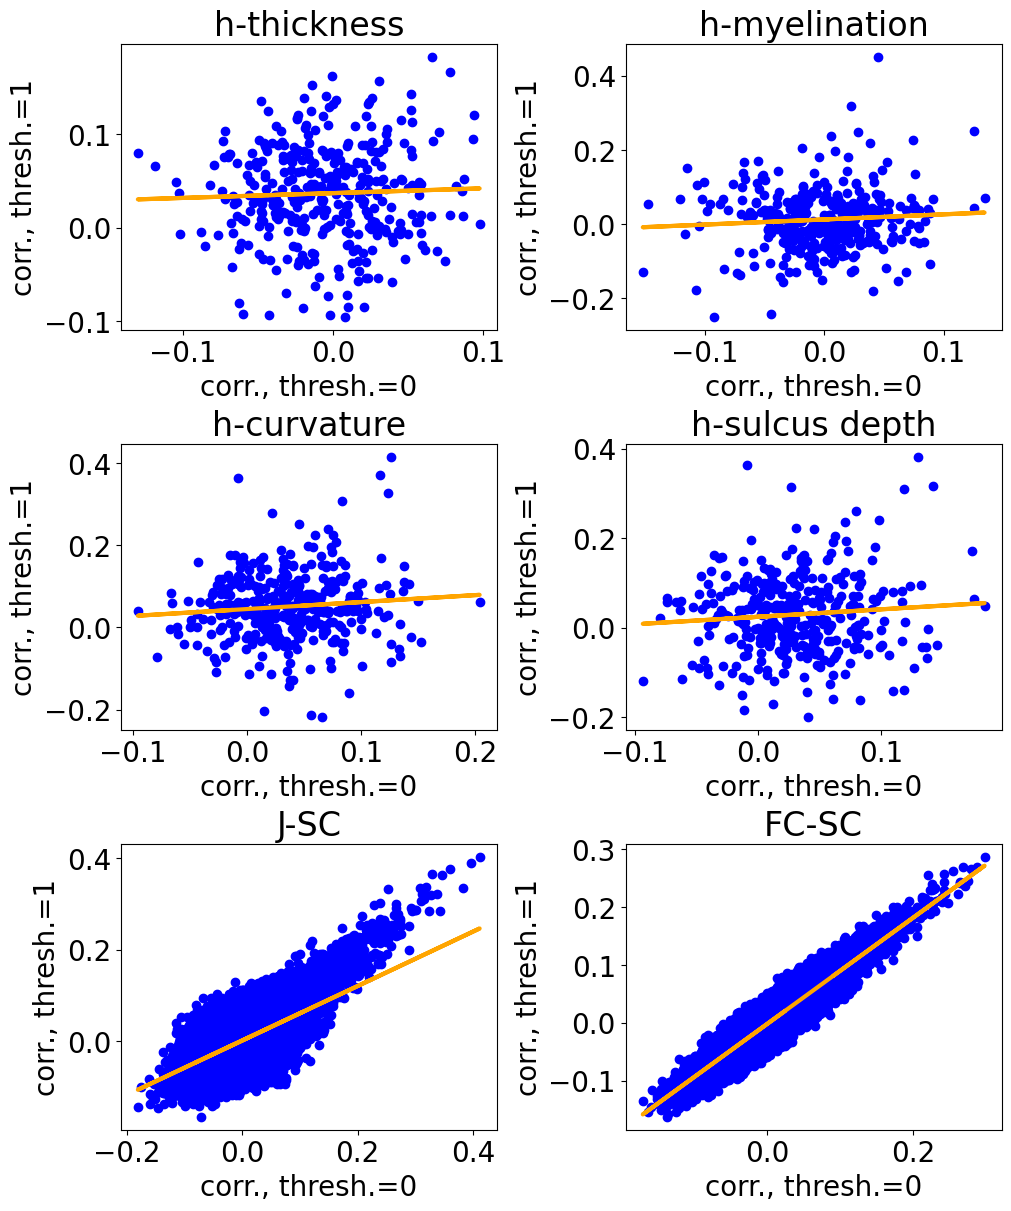

In [233]:
feature_name = 'corr., thresh.=0'
param_name = 'corr., thresh.=1'
num_perms = 100

fig, axs = plt.subplots( nrows=3, ncols=2, figsize=(10, 12), layout='constrained' )

for feature_index, r, c in zip(  range( len(feature_names) ), [0,0,1,1], [0,1,0,1]  ):
    ax = axs[r,c]
    feature = single_feature_h_corr_0[:,feature_index]
    param = single_feature_h_corr_1[:,feature_index]
    make_scatter_plot_with_regression_line_no_z(ax=ax, feature=feature, param=param, feature_name=feature_name, param_name=param_name)
    get_correlation_and_p(feature=feature, param=param, feature_name=feature_name, param_name=param_name, num_perms=num_perms)
    ax.set_title(f'h-{feature_names[feature_index]}')

ax = axs[2,0]
feature = sc_J_corr_0
param = sc_J_corr_1
make_scatter_plot_with_regression_line_no_z(ax=ax, feature=feature, param=param, feature_name=feature_name, param_name=param_name)
get_correlation_and_p(feature=feature, param=param, feature_name=feature_name, param_name=param_name, num_perms=num_perms)
ax.set_title(f'J-SC')

ax = axs[2,1]
feature = sc_fc_corr_0
param = sc_fc_corr_1
make_scatter_plot_with_regression_line_no_z(ax=ax, feature=feature, param=param, feature_name=feature_name, param_name=param_name)
get_correlation_and_p(feature=feature, param=param, feature_name=feature_name, param_name=param_name, num_perms=num_perms)
ax.set_title(f'FC-SC')

corr., thresh.=1=0.0513corr., thresh.=0+0.0371, R^2=0.00158
corr., thresh.=1 v. corr., thresh.=0 corr.=0.0396, p-value=0.46
corr., thresh.=1=0.138corr., thresh.=0+0.0121, R^2=0.00593
corr., thresh.=1 v. corr., thresh.=0 corr.=0.0768, p-value=0.1
corr., thresh.=1=0.17corr., thresh.=0+0.0447, R^2=0.00887
corr., thresh.=1 v. corr., thresh.=0 corr.=0.0939, p-value=0.05
corr., thresh.=1=0.167corr., thresh.=0+0.0243, R^2=0.00763
corr., thresh.=1 v. corr., thresh.=0 corr.=0.0871, p-value=0.08
corr., thresh.=1=0.596corr., thresh.=0+0.00125, R^2=0.36
corr., thresh.=1 v. corr., thresh.=0 corr.=0.6, p-value=0
corr., thresh.=1=0.915corr., thresh.=0+-0.00168, R^2=0.872
corr., thresh.=1 v. corr., thresh.=0 corr.=0.934, p-value=0


Text(0.5, 1.0, 'FC-SC')

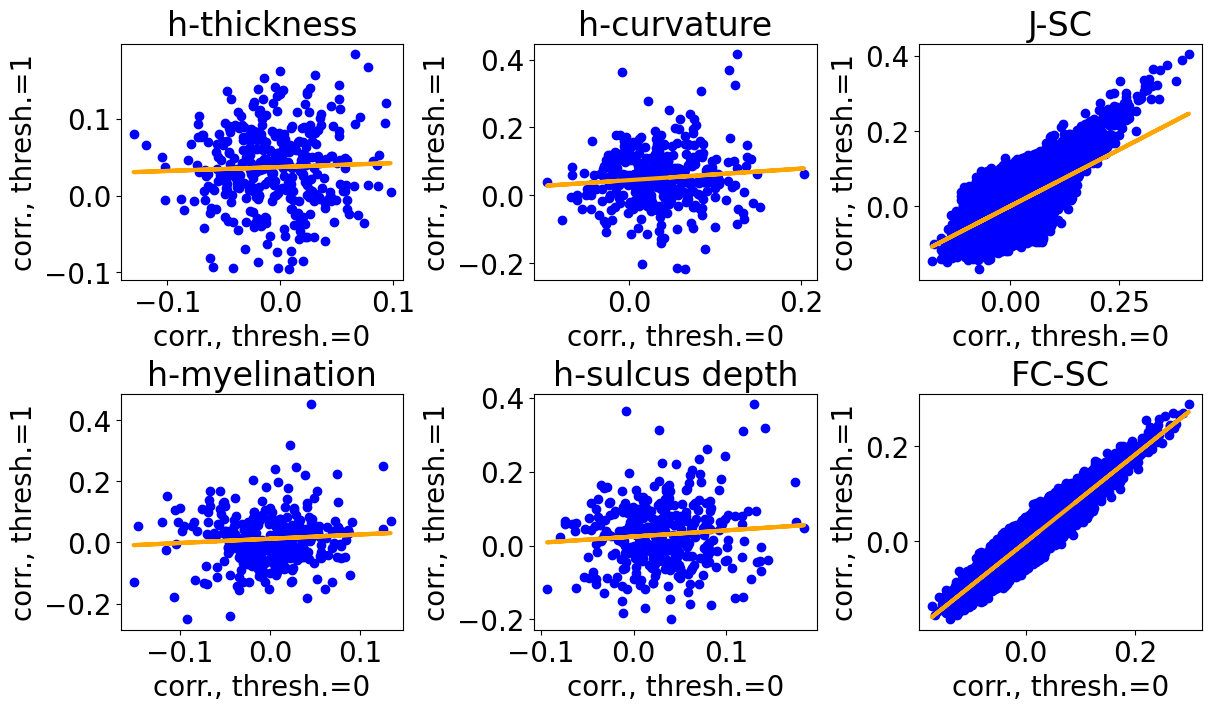

In [241]:
feature_name = 'corr., thresh.=0'
param_name = 'corr., thresh.=1'
num_perms = 100

fig, axs = plt.subplots( nrows=2, ncols=3, figsize=(12, 7), layout='constrained' )

for feature_index, r, c in zip(  range( len(feature_names) ), [0,0,1,1], [0,1,0,1]  ):
    ax = axs[c,r]
    feature = single_feature_h_corr_0[:,feature_index]
    param = single_feature_h_corr_1[:,feature_index]
    make_scatter_plot_with_regression_line_no_z(ax=ax, feature=feature, param=param, feature_name=feature_name, param_name=param_name)
    get_correlation_and_p(feature=feature, param=param, feature_name=feature_name, param_name=param_name, num_perms=num_perms)
    ax.set_title(f'h-{feature_names[feature_index]}')

ax = axs[0,2]
feature = sc_J_corr_0
param = sc_J_corr_1
make_scatter_plot_with_regression_line_no_z(ax=ax, feature=feature, param=param, feature_name=feature_name, param_name=param_name)
get_correlation_and_p(feature=feature, param=param, feature_name=feature_name, param_name=param_name, num_perms=num_perms)
ax.set_title(f'J-SC')

ax = axs[1,2]
feature = sc_fc_corr_0
param = sc_fc_corr_1
make_scatter_plot_with_regression_line_no_z(ax=ax, feature=feature, param=param, feature_name=feature_name, param_name=param_name)
get_correlation_and_p(feature=feature, param=param, feature_name=feature_name, param_name=param_name, num_perms=num_perms)
ax.set_title(f'FC-SC')

In [250]:
feature_name = 'corr., thresh.=0'
param_name = 'corr., thresh.=1'
num_perms = 1000000

for feature_index, r, c in zip(  range( len(feature_names) ), [0,0,1,1], [0,1,0,1]  ):
    feature = single_feature_h_corr_0[:,feature_index]
    param = single_feature_h_corr_1[:,feature_index]
    get_correlation_and_p(feature=feature, param=param, feature_name=feature_name, param_name=param_name, num_perms=num_perms)

feature = sc_J_corr_0
param = sc_J_corr_1
get_correlation_and_p(feature=feature, param=param, feature_name=feature_name, param_name=param_name, num_perms=num_perms)
feature = sc_fc_corr_0
param = sc_fc_corr_1
get_correlation_and_p(feature=feature, param=param, feature_name=feature_name, param_name=param_name, num_perms=num_perms)

corr., thresh.=1 v. corr., thresh.=0 corr.=0.0396, p-value=0.452
corr., thresh.=1 v. corr., thresh.=0 corr.=0.0768, p-value=0.145
corr., thresh.=1 v. corr., thresh.=0 corr.=0.0939, p-value=0.0744
corr., thresh.=1 v. corr., thresh.=0 corr.=0.0871, p-value=0.0978
corr., thresh.=1 v. corr., thresh.=0 corr.=0.6, p-value=0
corr., thresh.=1 v. corr., thresh.=0 corr.=0.934, p-value=0


(tensor(0.9339, device='cuda:0'), tensor(0., device='cuda:0'))